In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd "/content/gdrive/MyDrive/ARDF_SSD"

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1qYHA6AgfkviPjK9bxK3OfHqP1cktD-Up/ARDF_SSD


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install rdkit pubchempy pyxlsb xlrd -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 63.1 MB/s eta 0:00:00


# InChIKey Retrieval Workflow


This workflow compares InChIs from four different sources: PubChem, OPSIN, NCI (CACTUS), and NIST Chemistry WebBook. The workflow sequentially checks each source (PubChem → NIST → OPSIN → NCI) in the specified order and validates the InChI from the first successful retrieval.

**The workflow is executed as follows:**
- Query the source using the original CAS Number/Chemical name.
- Query the source using the formatted CAS Number/Chemical name.
- Retrieve Synonyms from PubChem and try using them for querying PubChem in case there was no InChI retrieved from the original name.




In [ ]:
import pandas as pd

In [ ]:
filtered_df = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/3.LifeStageData-InvertebratesMerged&SpeciesFiltered.csv')

In [ ]:
filtered_df

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage


In [ ]:
filtered_df['Chemical Name'].value_counts()

,count
Chemical Name,
Sulfuric acid copper(2+) salt (1:1),5768
Cadmium chloride (CdCl2),2926
N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1),2276
"4,4'-(1-Methylethylidene)bisphenol",1982
"Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester",1897
...,...
2-Methyl-4-nitrobenzenamine,1
4-Methyl-2-nitrobenzenamine,1
"N-[2-Chloro-5-(trifluoromethyl)phenyl]-2,4-dinitro-6-(trifluoromethyl)benzenamine",1


After comparing structures, the returned InChI depends on the outcome of the comparison. Here’s the decision flow:

1. **If PubChem and OPSIN InChIs are identical:**
   - The PubChem (or OPSIN) InChI is returned.

2. **If PubChem and OPSIN InChIs differ but both are valid:**
   - A structural comparison is performed using RDKit.
   - **If the structures are identical (similarity = 1.0):**
     - The PubChem InChI is returned (you can adjust this to return the OPSIN InChI if preferred).
   - **If the structures are not identical:**
     - A decision is made based on your preference, but typically, you would choose either:
       - The PubChem InChI (default in the current implementation), or
       - You can modify it to return the InChI with the highest validation confidence.

3. **If only one source (PubChem or OPSIN) has a valid InChI:**
   - The valid InChI from that source is returned.

4. **If neither source provides a valid InChI:**
   - `None` is returned, indicating no valid InChI was found.


### Customization:
- You can decide which InChI to return in the case of structure mismatch. The code currently defaults to returning the PubChem InChI. If you'd prefer to return the OPSIN InChI or apply another rule, you can modify the `return` statement accordingly.

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException, Timeout
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0,
            'pubchem_valid': 0,
            'nist_valid': 0,
            'opsin_valid': 0,
            'nci_valid': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")


    def format_cas_number(self, cas_number):
        """
        Formats a CAS number in the correct format.
        """
        cas_number = str(cas_number)
        check_digit = cas_number[-1]
        middle_part = cas_number[-3:-1]
        first_part = cas_number[:-3]
        return f"{first_part}-{middle_part}-{check_digit}"


    def format_chemical_name(self, chemical_name):
        """
        Formats the chemical name by removing the last part if it is in parentheses.
        Returns both the formatted chemical name and the last part inside the parentheses (if present).
        """
        smiles_candidate = None
        if " " in chemical_name:
            parts = chemical_name.split(" ")
            last_part = parts[-1]
            if "(" in last_part and ")" in last_part:
                smiles_candidate = last_part.strip("()")
                chemical_name = " ".join(parts[:-1])
                logging.info(f"Formatted chemical name to: {chemical_name} and extracted potential SMILES: {smiles_candidate}")
        return chemical_name, smiles_candidate


    def get_synonyms_pubchem(self, chemical_name):
        """
        Retrieves synonyms for a given chemical name from PubChem.
        """
        base_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/synonyms/JSON"
        try:
            response = requests.get(base_url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                synonyms = data['InformationList']['Information'][0]['Synonym']
                return synonyms
            else:
                logging.error(f"Failed to retrieve synonyms from PubChem for {chemical_name}.")
                return None
        except Exception as e:
            logging.error(f"Error retrieving synonyms for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            return inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None


    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        return mol is not None


    def retrieve_inchi_with_synonyms(self, source_name, retrieve_function, chemical_name):
        """
        Attempts to retrieve the InChI and validate it, using synonyms if the first attempt fails.
        """
        inchi = retrieve_function(chemical_name)
        if not inchi:
            logging.info(f"No InChI retrieved from {source_name} for {chemical_name}, trying synonyms.")
            synonyms = self.get_synonyms_pubchem(chemical_name)
            if synonyms:
                for synonym in synonyms:
                    inchi = retrieve_function(synonym)
                    if inchi and self.validate_inchi(inchi):
                        chemical_name = synonym  # Update the name to the synonym
                        break
        if inchi and self.validate_inchi(inchi):
            self.counters[f'{source_name.lower()}_valid'] += 1
            logging.info(f"Valid InChI found from {source_name}.")
            return inchi
        return None


    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by sequentially retrieving from PubChem, NIST, OPSIN, and NCI.
        If no InChI is retrieved from PubChem, tries retrieving synonyms and re-attempts for all sources.
        Also attempts to use the last part of the formatted chemical name as a SMILES string to generate InChI using RDKit.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")

        # Format the chemical name and extract potential SMILES from the last part
        formatted_name, smiles_candidate = self.format_chemical_name(chemical_name)

        sources = [
            ("PubChem", self.retrieve_inchi_pubchem),
            ("NIST", lambda name: self.retrieve_inchi_nist(cas_number) if cas_number else None),
            ("OPSIN", self.retrieve_inchi_opsin),
            ("NCI", self.retrieve_inchi_nci)
        ]

        valid_inchi = None
        valid_source = None
        validation_info = []  # List to store validation information

        # Try to retrieve InChI using the original CAS number and chemical name first
        for source_name, retrieve_function in sources:
            inchi = self.retrieve_inchi_with_synonyms(source_name, retrieve_function, chemical_name)
            if inchi:
                valid_inchi = inchi
                valid_source = source_name
                validation_info.append(f"Original name: {chemical_name}")
                break

        # If no valid InChI is found, attempt to use the SMILES candidate extracted from the last part
        if not valid_inchi and smiles_candidate:
            mol = Chem.MolFromSmiles(smiles_candidate)
            if mol:
                valid_inchi = Chem.MolToInchi(mol)
                valid_source = "SMILES from parentheses"
                validation_info.append(f"SMILES: {smiles_candidate}")
                logging.info(f"Valid InChI generated from Candidate SMILES extracted from Chemical Name: {valid_inchi}")

        # If still no valid InChI, try the formatted chemical name
        if not valid_inchi and formatted_name != chemical_name:
            logging.info(f"Retrying with formatted chemical name: {formatted_name}")
            for source_name, retrieve_function in sources:
                inchi = self.retrieve_inchi_with_synonyms(source_name, retrieve_function, formatted_name)
                if inchi:
                    valid_inchi = inchi
                    valid_source = f"{source_name} (formatted name)"
                    validation_info.append(f"Formatted name: {formatted_name}")
                    break

        # If no valid InChI is found and we have a CAS number, try with the formatted CAS number
        if not valid_inchi and cas_number:
            formatted_cas_number = self.format_cas_number(cas_number)
            logging.info(f"Retrying with formatted CAS number: {formatted_cas_number}")
            for source_name, retrieve_function in sources:
                inchi = retrieve_function(formatted_cas_number)
                if inchi and self.validate_inchi(inchi):
                    valid_inchi = inchi
                    valid_source = f"{source_name} (formatted CAS)"
                    validation_info.append(f"Formatted CAS: {formatted_cas_number}")
                    break

        # Finalize and return the result
        if valid_inchi:
            self.counters['single_valid'] += 1
            notes = f"Validated InChI found from {valid_source}. " + ", ".join(validation_info)
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"

        return valid_inchi, notes


    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)


    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df


    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")


# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
processed_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv', index=False)

In [ ]:
filtered_df['Chemical Name'].value_counts()

,count
Chemical Name,
Sulfuric acid copper(2+) salt (1:1),5768
Cadmium chloride (CdCl2),2926
N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1),2276
"4,4'-(1-Methylethylidene)bisphenol",1982
"Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester",1897
...,...
2-Methyl-4-nitrobenzenamine,1
4-Methyl-2-nitrobenzenamine,1
"N-[2-Chloro-5-(trifluoromethyl)phenyl]-2,4-dinitro-6-(trifluoromethyl)benzenamine",1


In [ ]:
processed_df['Chemical Name'].value_counts()

,count
Chemical Name,
Sulfuric acid copper(2+) salt (1:1),5768
Cadmium chloride (CdCl2),2926
N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1),2276
"4,4'-(1-Methylethylidene)bisphenol",1982
"Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester",1897
...,...
"2-Chlorohexahydro-4-methyl-4H-1,3,2-benzodioxaphosphorin 2-sulfide",1
"(4-Methyl-1,3-dithian-2-ylidene)phosphoramide acid, Dimethyl ester",1
"Ethyl phosphonodithioic acid, O-Ethyl-S-o-tolyl ester",1


In [ ]:
processed_df['InChI_Verification'].value_counts().to_dict()

{'Validated InChI found from PubChem. Original name: Sulfuric acid copper(2+) salt (1:1)': 5768,
 'Validated InChI found from NCI. Original name: Cadmium chloride (CdCl2)': 2926,
 'Validated InChI found from OPSIN. Original name: N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1)': 2276,
 "Validated InChI found from PubChem. Original name: 4,4'-(1-Methylethylidene)bisphenol": 1982,
 'Validated InChI found from PubChem. Original name: Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester': 1897,
 'Validated InChI found from OPSIN. Original name: Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl]': 1806,
 'Validated InChI found from NIST. Original name: (17beta)Estra-1,3,5(10)triene-3,17-diol': 1692,
 'Validated InChI found from PubChem. Original name: Copper': 1683,
 'Validated InChI found from PubChem. Original name: Coppe

In [ ]:
processed_df['InChI_Verification'].str.contains('smiles', case=False, na=False).sum()

0

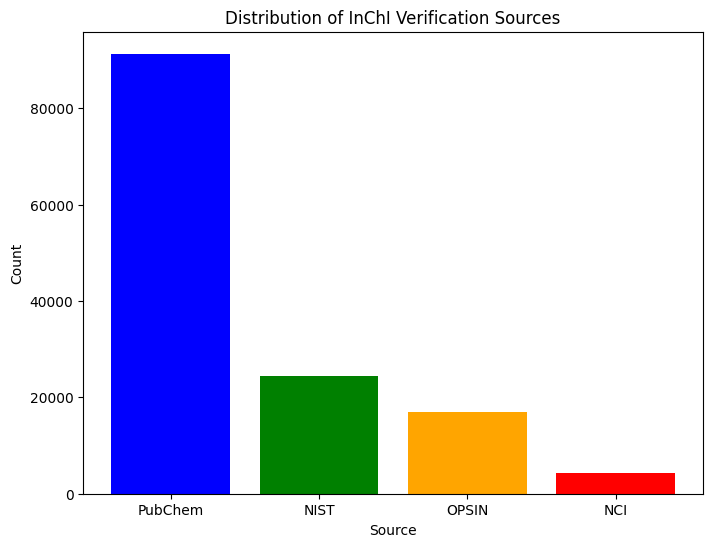

In [ ]:
import matplotlib.pyplot as plt

# Summing up the counts of values containing the specific keywords (case insensitive)
pubchem_count = processed_df['InChI_Verification'].str.contains('pubchem', case=False, na=False).sum()
nist_count = processed_df['InChI_Verification'].str.contains('nist', case=False, na=False).sum()
opsin_count = processed_df['InChI_Verification'].str.contains('opsin', case=False, na=False).sum()
nci_count = processed_df['InChI_Verification'].str.contains('nci', case=False, na=False).sum()

# Preparing data for the distribution plot
counts = {'PubChem': pubchem_count, 'NIST': nist_count, 'OPSIN': opsin_count, 'NCI': nci_count}

# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Distribution of InChI Verification Sources')
plt.show()

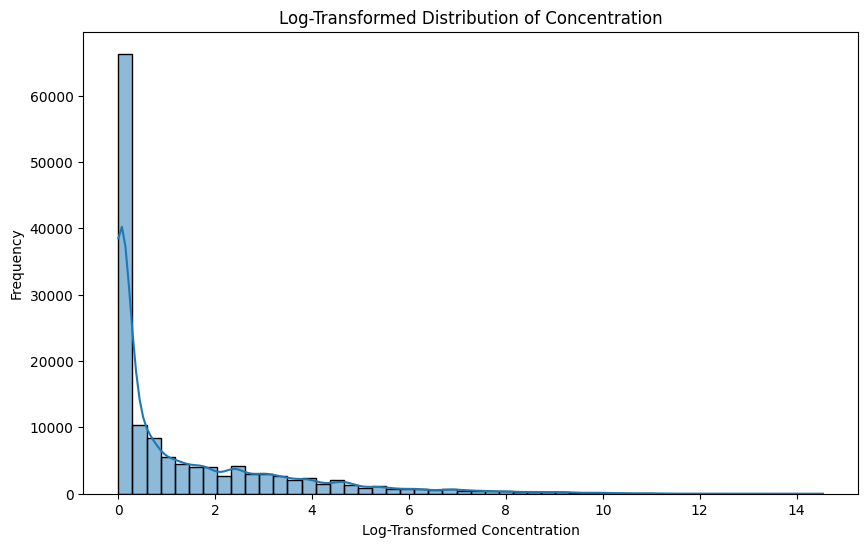

In [ ]:
import numpy as np
import seaborn as sns

processed_df['Log Conc 1 Mean (Standardized)'] = np.log1p(processed_df['Conc 1 Mean (Standardized)'])

plt.figure(figsize=(10, 6))
sns.histplot(processed_df['Log Conc 1 Mean (Standardized)'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Concentration')
plt.xlabel('Log-Transformed Concentration')
plt.ylabel('Frequency')
plt.show()

# Old Implementations

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException, Timeout
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0,
            'pubchem_valid': 0,
            'nist_valid': 0,
            'opsin_valid': 0,
            'nci_valid': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")

    def get_synonyms_pubchem(self, chemical_name):
        """
        Retrieves synonyms for a given chemical name from PubChem.
        """
        base_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/synonyms/JSON"
        try:
            response = requests.get(base_url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                synonyms = data['InformationList']['Information'][0]['Synonym']
                return synonyms
            else:
                logging.error(f"Failed to retrieve synonyms from PubChem for {chemical_name}.")
                return None
        except Exception as e:
            logging.error(f"Error retrieving synonyms for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            return inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        return mol is not None

    def retrieve_inchi_with_synonyms(self, source_name, retrieve_function, chemical_name):
        """
        Attempts to retrieve the InChI and validate it, using synonyms if the first attempt fails.
        """
        inchi = retrieve_function(chemical_name)
        if not inchi:
            logging.info(f"No InChI retrieved from {source_name} for {chemical_name}, trying synonyms.")
            synonyms = self.get_synonyms_pubchem(chemical_name)
            if synonyms:
                for synonym in synonyms:
                    inchi = retrieve_function(synonym)
                    if inchi and self.validate_inchi(inchi):
                        chemical_name = synonym  # Update the name to the synonym
                        break
        if inchi and self.validate_inchi(inchi):
            self.counters[f'{source_name.lower()}_valid'] += 1
            logging.info(f"Valid InChI found from {source_name}.")
            return inchi
        return None

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by sequentially retrieving from PubChem, NIST, OPSIN, and NCI.
        If no InChI is retrieved from PubChem, tries retrieving synonyms and re-attempts for all sources.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")
        sources = [
            ("PubChem", self.retrieve_inchi_pubchem),
            ("NIST", lambda name: self.retrieve_inchi_nist(cas_number) if cas_number else None),
            ("OPSIN", self.retrieve_inchi_opsin),
            ("NCI", self.retrieve_inchi_nci)
        ]

        valid_inchi = None
        valid_source = None

        for source_name, retrieve_function in sources:
            inchi = self.retrieve_inchi_with_synonyms(source_name, retrieve_function, chemical_name)
            if inchi:
                valid_inchi = inchi
                valid_source = source_name
                break

        if valid_inchi:
            self.counters['single_valid'] += 1
            notes = f"Validated InChI found from {valid_source}"
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"

        return valid_inchi, notes

    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
expected_indices = pd.RangeIndex(start=processed_df.index.min(), stop=processed_df.index.max() + 1)
missing_indices = expected_indices.difference(processed_df.index)
missing_df = filtered_df.loc[missing_indices]
missing_df

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,Standardized_InChI,InChI_Verification
1000,1332656,Copper chloride hydroxide (Cu2Cl(OH)3),Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,2.0,Static,Fresh water,4.300000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,None,No valid InChI found
1001,1332656,Copper chloride hydroxide (Cu2Cl(OH)3),Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,3.0,Static,Fresh water,13.450000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,None,No valid InChI found
1002,1332656,Copper chloride hydroxide (Cu2Cl(OH)3),Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0,Static,Fresh water,2.400000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,None,No valid InChI found
1003,1332656,Copper chloride hydroxide (Cu2Cl(OH)3),Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,3.0,Static,Fresh water,2.800000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,None,No valid InChI found
1004,1332656,Copper chloride hydroxide (Cu2Cl(OH)3),Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0,Static,Fresh water,2.830000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,None,No valid InChI found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139058,13463417,(T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethi...,Paracentrotus lividus,"Sea Urchin, Echinoderm",Other Invertebrates,Egg,2.0,Static,Salt water,0.007415,mg/L,Development,Normal,EC50,Reproductive stage,None,No valid InChI found
139059,13463417,(T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethi...,Paracentrotus lividus,"Sea Urchin, Echinoderm",Other Invertebrates,Egg,2.0,Static,Salt water,0.007094,mg/L,Growth,Length,EC50,Reproductive stage,None,No valid InChI found
139108,54944568,"[2S-[2 alpha, 5 alpha, 6 beta(S*)-]] 6[[[(2,3-...",Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0,Static,Fresh water,10715.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,None,No valid InChI found
139121,68411303,"Benzenesulfonic acid, C10-13 Alkylderivs., Sod...",Brachionus calyciflorus,Rotifer,Other Invertebrates,Cyst,2.0,Static,Fresh water,2.000000,mg/L,Behavior,"Distance moved, change in direct movement",EC50,Reproductive stage,None,No valid InChI found


In [ ]:
missing_df = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-NoInChIRetrieved.csv')

In [ ]:
processed_df['InChI_Verification'].value_counts().to_dict()

{'Validated InChI found from PubChem. Original name: Sulfuric acid copper(2+) salt (1:1)': 5768,
 'Validated InChI found from NCI. Original name: Cadmium chloride (CdCl2)': 2926,
 'Validated InChI found from OPSIN. Original name: N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1)': 2276,
 "Validated InChI found from PubChem. Original name: 4,4'-(1-Methylethylidene)bisphenol": 1982,
 'Validated InChI found from PubChem. Original name: Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester': 1897,
 'Validated InChI found from OPSIN. Original name: Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl]': 1806,
 'Validated InChI found from NIST. Original name: (17beta)Estra-1,3,5(10)triene-3,17-diol': 1692,
 'Validated InChI found from PubChem. Original name: Copper': 1683,
 'Validated InChI found from PubChem. Original name: Coppe

In [ ]:
processed_df_missing['Chemical Name'].value_counts()

,count
Chemical Name,
Cadmium chloride (CdCl2),2926
"Nitric acid, Lead (2+) salt (2:1)",885
"5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1)",182
"Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl]",108
"[N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc",105
"alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl)",78
"2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c']difuran-5,10a(8H)-dicarboxylic acid 5-10a-dimethyl ester",66
Manganese chloride (MnCl2),58
Chromic acid (H2Cr2O7) disodium salt,58


In [ ]:
processed_df_missing[['Chemical Name', 'InChI_Verification']].value_counts().to_dict()

{('Cadmium chloride (CdCl2)',
  'Validated InChI found from NCI. Original name: Cadmium chloride (CdCl2)'): 2926,
 ('Nitric acid, Lead (2+) salt (2:1)',
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 10099-74-8'): 885,
 ('5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1)',
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 1420-04-8'): 182,
 ('Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl]',
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 118399-22-7'): 108,
 ("[N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc",
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 8018-01-7'): 105,
 ('alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1

In [ ]:
missing_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-NoInChIRetrieved.csv', index=False)

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException, Timeout
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            return inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        return mol is not None

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.
        """
        logging.info("Comparing molecular structures.")
        if mol1 is None or mol2 is None:
            logging.warning("One or both molecules are invalid for comparison.")
            return 0.0

        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by sequentially retrieving from PubChem, NIST, OPSIN, and NCI.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")
        sources = [
            ("PubChem", self.retrieve_inchi_pubchem),
            ("NIST", lambda name: self.retrieve_inchi_nist(cas_number) if cas_number else None),
            ("OPSIN", self.retrieve_inchi_opsin),
            ("NCI", self.retrieve_inchi_nci)
        ]

        valid_inchi = None
        valid_source = None

        for source_name, retrieve_function in sources:
            inchi = retrieve_function(chemical_name)
            if inchi and self.validate_inchi(inchi):
                valid_inchi = inchi
                valid_source = source_name
                logging.info(f"Valid InChI found from {source_name}.")
                break

        if valid_inchi:
            self.counters['single_valid'] += 1
            notes = f"Validated InChI found from {valid_source}"
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"

        return valid_inchi, notes

    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
# Assuming 'filtered_df' is your DataFrame with a column named 'Chemical Name' and optionally 'CAS Number'
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-21 09:52:20,944 - root - INFO - Initialized InChIStandardizer with counters.
2024-08-21 09:52:20,945 - root - INFO - Starting parallel processing of chemicals.
2024-08-21 09:52:20,968 - root - INFO - Processing single chemical: Formaldehyde
2024-08-21 09:52:20,970 - root - INFO - Standardizing InChI for Formaldehyde.
2024-08-21 09:52:20,972 - root - INFO - Retrieving InChI from PubChem for Formaldehyde.
2024-08-21 09:52:20,973 - root - INFO - Processing single chemical: N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide
2024-08-21 09:52:20,973 - root - INFO - Processing single chemical: (17beta)Estra-1,3,5(10)triene-3,17-diol
2024-08-21 09:52:21,023 - root - INFO - Standardizing InChI for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide.
2024-08-21 09:52:21,061 - root - INFO - Standardizing InChI for (17beta)Estra-1,3,5(10)triene-3,17-diol.
2024-08-21 09:52:21,089 - root - INFO - Retrieving InChI from PubChem for N,N-Bis(2-chloroe

KeyboardInterrupt: 

In [ ]:
def retrieve_inchi_unichem(chemical_name):
    url = f"https://www.ebi.ac.uk/unichem/rest/src_compound_id/{chemical_name}/1"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get('stdinchikey', None)
    return None

retrieve_inchi_unichem('aspirin')

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            # logging.info(f"Retrieved InChI from PubChem for {chemical_name}: {inchi}")
            return inchi
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                inchi = response.text.strip()
                # logging.info(f"Retrieved InChI from OPSIN for {chemical_name}: {inchi}")
                return inchi
            return None
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timout=10)
            if response.status_code == 200:
                inchi = response.text.strip()
                # logging.info(f"Retrieved InChI from NCI for {chemical_name}: {inchi}")
                return inchi
            return None
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        inchi = inchi_element.text.strip()
                        # logging.info(f"Retrieved InChI from NIST for CAS {cas_number}: {inchi}")
                        return inchi
            return None
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        valid = mol is not None
        # if valid:
            # logging.info("InChI validation successful.")
        # else:
        #     logging.warning("InChI validation failed.")
        return valid

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.
        """
        logging.info("Comparing molecular structures.")
        if mol1 is None or mol2 is None:
            logging.warning("One or both molecules are invalid for comparison.")
            return 0.0

        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        # logging.info(f"Structural similarity: {similarity}")
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by comparing results from PubChem, OPSIN, NIST, and NCI.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        nci_inchi = self.retrieve_inchi_nci(chemical_name)
        nist_inchi = None
        notes = ""

        valid_inchis = []
        if pubchem_inchi and self.validate_inchi(pubchem_inchi):
            valid_inchis.append(('PubChem', pubchem_inchi))
        if opsin_inchi and self.validate_inchi(opsin_inchi):
            valid_inchis.append(('OPSIN', opsin_inchi))
        if nci_inchi and self.validate_inchi(nci_inchi):
            valid_inchis.append(('NCI', nci_inchi))
        if cas_number:
            nist_inchi = self.retrieve_inchi_nist(cas_number)
            if nist_inchi and self.validate_inchi(nist_inchi):
                valid_inchis.append(('NIST', nist_inchi))

        if len(valid_inchis) > 1:
            all_match = all(inchi == valid_inchis[0][1] for _, inchi in valid_inchis)
            if all_match:
                self.counters['multiple_valid_match'] += 1
                notes = f"Match from multiple sources: {[source for source, _ in valid_inchis]}"
                # logging.info(notes)
            else:
                similarity_scores = []
                for i in range(len(valid_inchis)):
                    for j in range(i + 1, len(valid_inchis)):
                        mol1 = Chem.MolFromInchi(valid_inchis[i][1])
                        mol2 = Chem.MolFromInchi(valid_inchis[j][1])
                        similarity = self.compare_structures(mol1, mol2)
                        similarity_scores.append(similarity)

                avg_similarity = sum(similarity_scores) / len(similarity_scores)
                if avg_similarity == 1.0:
                    self.counters['multiple_valid_match'] += 1
                    notes = "Structural match from multiple sources after comparison"
                    # logging.info(notes)
                else:
                    self.counters['no_match'] += 1
                    notes = f"Structure mismatch (average similarity: {avg_similarity:.2f})"
                    logging.warning(notes)
        elif len(valid_inchis) == 1:
            self.counters['single_valid'] += 1
            # notes = f"Found only in {valid_inchis[0][0]} and validated"
            logging.info(notes)
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"
            logging.warning(notes)

        return valid_inchis[0][1] if valid_inchis else None, notes

    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        # logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    # logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-20 17:10:25,644 - root - INFO - Retrieving InChI from NCI for Carbonochloridic acid, methyl ester.
2024-08-20 17:10:25,646 - root - ERROR - Failed to retrieve InChI from NCI for Carbonochloridic acid, methyl ester: Session.request() got an unexpected keyword argument 'timout'
2024-08-20 17:10:25,647 - root - INFO - Validating InChI: InChI=1S/C2H3ClO2/c1-5-2(3)4/h1H3
2024-08-20 17:10:25,649 - root - INFO - Validating InChI: InChI=1/C2H3ClO2/c1-5-2(3)4/h1H3
2024-08-20 17:10:25,650 - root - INFO - Retrieving InChI from NIST for CAS 79221.
2024-08-20 17:10:25,742 - root - INFO - Retrieving InChI from NCI for (17beta)-17-Hydroxyandrost-4-ene-3,11-dione.
2024-08-20 17:10:25,744 - root - INFO - Validating InChI: InChI=1S/C19H26O3/c1-18-8-7-12(20)9-11(18)3-4-13-14-5-6-16(22)19(14,2)10-15(21)17(13)18/h9,13-14,16-17,22H,3-8,10H2,1-2H3/t13-,14-,16-,17+,18-,19-/m0/s1
2024-08-20 17:10:25,745 - root - INFO - Validating InChI: InChI=1/C19H26O3/c1-18-8-7-12(20)9-11(18)3-4-13-14-5-6-16(22)19(14

[17:11:32] WARNING: not removing hydrogen atom without neighbors
[17:11:32] WARNING: not removing hydrogen atom without neighbors


2024-08-20 17:11:32,943 - root - INFO - Validating InChI: InChI=1S/C24H40N8O4/c33-15-11-31(12-16-34)23-26-20-19(21(27-23)29-7-3-1-4-8-29)25-24(32(13-17-35)14-18-36)28-22(20)30-9-5-2-6-10-30/h33-36H,1-18H2
2024-08-20 17:11:32,946 - root - INFO - Comparing molecular structures.
2024-08-20 17:11:32,948 - root - INFO - Standardizing InChI for 2-(2-Ethylhexyl)-3a,4,7,7a-tetrahydro-4,7-methano-1H-isoindole-1,3-(2H)dione.
2024-08-20 17:11:32,949 - root - INFO - Retrieving InChI from PubChem for 2-(2-Ethylhexyl)-3a,4,7,7a-tetrahydro-4,7-methano-1H-isoindole-1,3-(2H)dione.
2024-08-20 17:11:33,044 - root - INFO - 
2024-08-20 17:11:33,047 - root - INFO - Standardizing InChI for Silicic acid (H4SiO4).
2024-08-20 17:11:33,048 - root - INFO - Retrieving InChI from PubChem for Silicic acid (H4SiO4).
2024-08-20 17:11:33,091 - root - INFO - 
2024-08-20 17:11:33,092 - root - INFO - Standardizing InChI for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydrox

[17:11:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



Streaming output truncated to the last 5000 lines.
2024-08-20 17:11:50,175 - root - INFO - Retrieving InChI from NCI for Merulidial.
2024-08-20 17:11:50,177 - root - INFO - Validating InChI: InChI=1S/C15H20O3/c1-13(2)4-9-10(5-13)12(18)14(3)7-15(14,8-17)11(9)6-16/h6,8,10,12,18H,4-5,7H2,1-3H3/t10-,12+,14+,15+/m1/s1
2024-08-20 17:11:50,180 - root - INFO - Retrieving InChI from NIST for CAS 68053327.
2024-08-20 17:11:50,184 - root - INFO - Retrieving InChI from NCI for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea.
2024-08-20 17:11:50,186 - root - ERROR - Failed to retrieve InChI from NCI for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea: Session.request() got an unexpected keyword argument 'timout'
2024-08-20 17:11:50,188 - root - INFO - Validating InChI: InChI=1S/C10H11F3N2O/c1-15(2)9(16)14-8-5-3-4-7(6-8)10(11,12)13/h3-6H,1-2H3,(H,14,16)
2024-08-20 17:11:50,190 - root - INFO - Validating InChI: InChI=1/C10H11F3N2O/c1-15(2)9(16)14-8-5-3-4-7(6-8)10(11,12)13/h3-6H,1-2H3,(H,14,16)/f/h14H

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,Standardized_InChI,InChI_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/CH2O/c1-2/h1H2,Structural match from multiple sources after c...
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,Structural match from multiple sources after c...
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Structural match from multiple sources after c...
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Structural match from multiple sources after c...
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Structural match from multiple sources after c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,"InChI=1S/C15H18ClN3O/c1-11(12-2-3-12)15(20,8-1...",Structural match from multiple sources after c...
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,InChI=1S/C10H15NO.ClH/c1-3-11(4-2)9-6-5-7-10(1...,Structural match from multiple sources after c...
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,InChI=1/C32H47F5O3S/c1-30-17-15-26-25-12-11-24...,
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,InChI=1/C22H17ClF3N3O7/c1-33-18(30)21-10-12-9-...,


In [ ]:
processed_df['InChI_Verification'].value_counts().to_dict()

{'Structural match from multiple sources after comparison': 69495,
 '': 32601,
 "Match from multiple sources: ['PubChem', 'NIST']": 14705,
 'Structure mismatch (average similarity: 0.69)': 2609,
 'Structure mismatch (average similarity: 0.50)': 1714,
 'Structure mismatch (average similarity: 0.70)': 656,
 'Structure mismatch (average similarity: 0.60)': 588,
 'Structure mismatch (average similarity: 0.71)': 422,
 'Structure mismatch (average similarity: 0.33)': 388,
 'Structure mismatch (average similarity: 0.54)': 344,
 'Structure mismatch (average similarity: 0.48)': 300,
 'Structure mismatch (average similarity: 0.64)': 287,
 'Structure mismatch (average similarity: 0.17)': 255,
 'Structure mismatch (average similarity: 0.27)': 237,
 'Structure mismatch (average similarity: 0.74)': 232,
 'Structure mismatch (average similarity: 0.47)': 226,
 'Structure mismatch (average similarity: 0.53)': 221,
 'Structure mismatch (average similarity: 0.56)': 206,
 'Structure mismatch (average simi

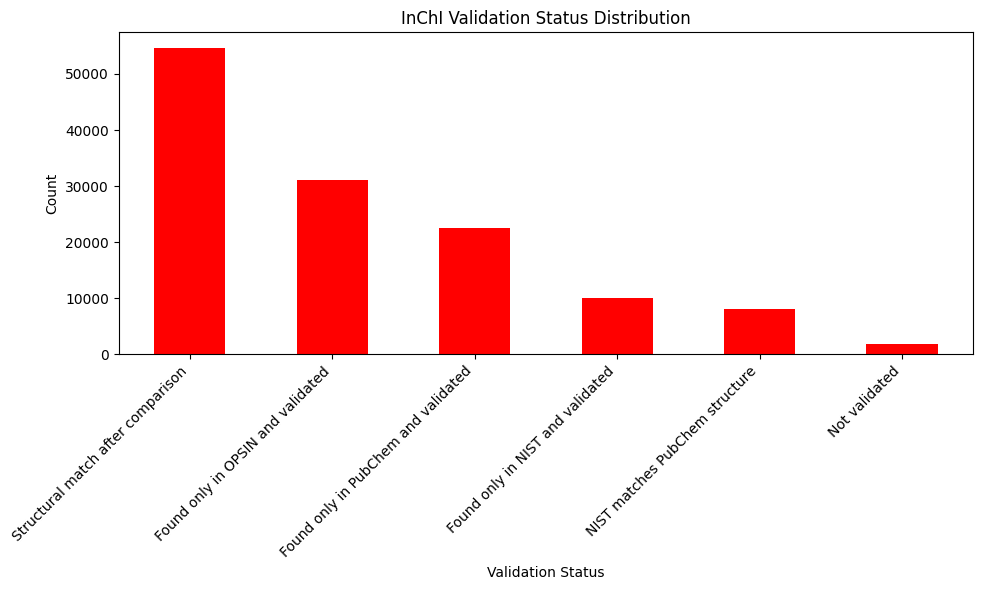

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Count the occurrences of each verification status
value_counts = processed_df['InChI_Verification'].value_counts()

# Separate the top 4 values and sum the rest under "Not validated"
top_4_values = value_counts.nlargest(5)
other_values_sum = value_counts.iloc[5:].sum()

# Add "Not validated" to the top 4 values
top_4_values['Not validated'] = other_values_sum

# Create a bar plot
plt.figure(figsize=(10, 6))
top_4_values.plot(kind='bar', color='red')
plt.title('InChI Validation Status Distribution')
plt.ylabel('Count')
plt.xlabel('Validation Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'opsin_only': 0,
            'nist_only': 0,
            'match': 0,
            'validated_match': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'structure_mismatch': 0,
            'pubchem_only_validated': 0,
            'opsin_only_validated': 0,
            'nist_only_validated': 0,
            'validation_failed': 0
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.

        Args:
            mol1 (rdkit.Chem.Mol): The first RDKit molecule.
            mol2 (rdkit.Chem.Mol): The second RDKit molecule.

        Returns:
            float: A similarity score between 0 and 1, where 1 means identical structures.
        """
        if mol1 is None or mol2 is None:
            return 0.0  # Can't compare if one of the molecules is invalid

        # Use the new MorganGenerator for generating molecular fingerprints
        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)

        # Compute the Tanimoto similarity between the two fingerprints
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by comparing results from PubChem, OPSIN, and NIST.
        If both InChIs are valid but differ, performs a structural comparison.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        nist_inchi = None
        notes = ""

        # Both InChIs are found
        if pubchem_inchi and opsin_inchi:
            pubchem_mol = Chem.MolFromInchi(pubchem_inchi)
            opsin_mol = Chem.MolFromInchi(opsin_inchi)

            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Mismatch between PubChem and OPSIN InChIs, perform structure comparison
                pubchem_valid = self.validate_inchi(pubchem_inchi)
                opsin_valid = self.validate_inchi(opsin_inchi)

                if pubchem_valid and opsin_valid:
                    similarity = self.compare_structures(pubchem_mol, opsin_mol)
                    if similarity == 1.0:
                        self.counters['validated_match'] += 1
                        notes = "Structural match after comparison"
                    else:
                        self.counters['structure_mismatch'] += 1
                        notes = f"Structure mismatch (similarity: {similarity:.2f})"
                        # Retrieve NIST InChI in case of mismatch
                        if cas_number:
                            nist_inchi = self.retrieve_inchi_nist(cas_number)
                            if nist_inchi:
                                nist_mol = Chem.MolFromInchi(nist_inchi)
                                if self.compare_structures(pubchem_mol, nist_mol) == 1.0:
                                    self.counters['nist_only_validated'] += 1
                                    notes = "NIST matches PubChem structure"
                                    return nist_inchi, notes
                                elif self.compare_structures(opsin_mol, nist_mol) == 1.0:
                                    self.counters['nist_only_validated'] += 1
                                    notes = "NIST matches OPSIN structure"
                                    return nist_inchi, notes
                                else:
                                    self.counters['nist_only'] += 1
                                    notes = "NIST structure mismatch"
                elif pubchem_valid:
                    self.counters['pubchem_only_validated'] += 1
                    notes = "Mismatch; PubChem InChI is valid"
                elif opsin_valid:
                    self.counters['opsin_only_validated'] += 1
                    notes = "Mismatch; OPSIN InChI is valid"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Mismatch; both InChIs failed validation"

        # Handle single source cases
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"
        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"
        else:
            if cas_number:
                nist_inchi = self.retrieve_inchi_nist(cas_number)
                if nist_inchi and self.validate_inchi(nist_inchi):
                    self.counters['nist_only_validated'] += 1
                    notes = "Found only in NIST and validated"
                else:
                    self.counters['nist_only'] += 1
                    notes = "Found only in NIST but validation failed"
            else:
                self.counters['no_inchi_found'] += 1
                notes = "No InChI found"

        return pubchem_inchi or opsin_inchi or nist_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names and CAS numbers.
            chemical_name_column (str): The column in DataFrame containing the chemical names.
            cas_number_column (str): The column in DataFrame containing CAS numbers.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()
        processed_count = 0

        results = {}
        for _, row in unique_chemicals.iterrows():
            chemical_name = row[chemical_name_column]
            cas_number = row[cas_number_column]
            results[chemical_name] = self.standardize_inchi(chemical_name, cas_number)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-20 09:59:47,199 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:49,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:51,724 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:52,260 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:53,242 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:54,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:55,193 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:00:02,644 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:00:03,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:00:04,159 - pubchempy - INFO - '

[10:02:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[10:02:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[10:02:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:02:50] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:02:50,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:02:52,087 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:02:52,506 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:02:57,491 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:02,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:04,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:05,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:06,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:09,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[10:03:10] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:03:10] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:03:12,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:13,641 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:15,292 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:16,180 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:16,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:18,613 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:19,498 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:22,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:24,163 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:26,083 - pubchempy - INFO - '

[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors


2024-08-20 10:09:41,776 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:43,324 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:47,284 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:49,648 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:52,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:53,576 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:56,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:56,447 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:57,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:58,498 - pubchempy - INFO - '

[10:14:20] Unusual charge on atom 24 number of radical electrons set to zero
[10:14:20] Unusual charge on atom 24 number of radical electrons set to zero


2024-08-20 10:14:23,849 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:24,973 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:27,424 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:28,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:28,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:29,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:29,681 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:30,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:31,469 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:31,995 - pubchempy - INFO - '

[10:16:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:16:01] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:16:03,700 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:06,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:07,415 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:08,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:09,683 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[10:16:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:16:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

[10:16:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:16:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:16:12,096 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:12,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:13,788 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:15,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:16,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:16,915 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:17,419 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:18,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:19,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:19,661 - pubchempy - INFO - '

[10:22:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[10:22:08] ERROR: Explicit valence for atom # 0 Cl, 3, is greater than permitted



2024-08-20 10:22:08,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:09,955 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:10,877 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:11,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:12,269 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:12,791 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:13,917 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:15,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:17,393 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:18,284 - pubchempy - INFO - '

[10:26:08] WARNING: not removing hydrogen atom without neighbors
[10:26:08] WARNING: not removing hydrogen atom without neighbors
[10:26:08] WARNING: not removing hydrogen atom without neighbors
[10:26:08] WARNING: not removing hydrogen atom without neighbors


2024-08-20 10:26:11,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:12,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:15,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:16,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:16,588 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:17,125 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:18,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:19,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:19,699 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:21,570 - pubchempy - INFO - '

[10:33:41] WARNING: not removing hydrogen atom without neighbors
[10:33:41] WARNING: not removing hydrogen atom without neighbors


2024-08-20 10:33:41,972 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:43,612 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[10:33:43] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-20 10:33:44,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:45,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:46,475 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:47,372 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:49,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:50,399 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:55,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:57,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:58,857 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:34:06,715 - pubchempy - INFO - '

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,Standardized_InChI,InChI_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/CH2O/c1-2/h1H2,Structural match after comparison
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,Structural match after comparison
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,"InChI=1S/C15H18ClN3O/c1-11(12-2-3-12)15(20,8-1...",Structural match after comparison
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,InChI=1S/C10H15NO.ClH/c1-3-11(4-2)9-6-5-7-10(1...,Structural match after comparison
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,InChI=1/C32H47F5O3S/c1-30-17-15-26-25-12-11-24...,Found only in OPSIN and validated
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,InChI=1/C22H17ClF3N3O7/c1-33-18(30)21-10-12-9-...,Found only in OPSIN and validated


In [ ]:
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'opsin_only': 0,
            'nist_only': 0,
            'match': 0,
            'validated_match': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'structure_mismatch': 0,
            'pubchem_only_validated': 0,
            'opsin_only_validated': 0,
            'nist_only_validated': 0,
            'validation_failed': 0
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.

        Args:
            mol1 (rdkit.Chem.Mol): The first RDKit molecule.
            mol2 (rdkit.Chem.Mol): The second RDKit molecule.

        Returns:
            float: A similarity score between 0 and 1, where 1 means identical structures.
        """
        if mol1 is None or mol2 is None:
            return 0.0  # Can't compare if one of the molecules is invalid

        # Use the new MorganGenerator for generating molecular fingerprints
        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)

        # Compute the Tanimoto similarity between the two fingerprints
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by comparing results from PubChem, OPSIN, and NIST.
        If both InChIs are valid but differ, performs a structural comparison.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        nist_inchi = None
        notes = ""

        # Both InChIs are found
        if pubchem_inchi and opsin_inchi:
            pubchem_mol = Chem.MolFromInchi(pubchem_inchi)
            opsin_mol = Chem.MolFromInchi(opsin_inchi)

            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Mismatch between PubChem and OPSIN InChIs, perform structure comparison
                pubchem_valid = self.validate_inchi(pubchem_inchi)
                opsin_valid = self.validate_inchi(opsin_inchi)

                if pubchem_valid and opsin_valid:
                    similarity = self.compare_structures(pubchem_mol, opsin_mol)
                    if similarity == 1.0:
                        self.counters['validated_match'] += 1
                        notes = "Structural match after comparison"
                    else:
                        self.counters['structure_mismatch'] += 1
                        notes = f"Structure mismatch (similarity: {similarity:.2f})"
                elif pubchem_valid:
                    self.counters['pubchem_only_validated'] += 1
                    notes = "Mismatch; PubChem InChI is valid"
                elif opsin_valid:
                    self.counters['opsin_only_validated'] += 1
                    notes = "Mismatch; OPSIN InChI is valid"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Mismatch; both InChIs failed validation"

        # Handle single source cases
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"
        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"
        else:
            if cas_number:
                nist_inchi = self.retrieve_inchi_nist(cas_number)
                if nist_inchi and self.validate_inchi(nist_inchi):
                    self.counters['nist_only_validated'] += 1
                    notes = "Found only in NIST and validated"
                else:
                    self.counters['nist_only'] += 1
                    notes = "Found only in NIST but validation failed"
            else:
                self.counters['no_inchi_found'] += 1
                notes = "No InChI found"

        return pubchem_inchi or opsin_inchi or nist_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names and CAS numbers.
            chemical_name_column (str): The column in DataFrame containing the chemical names.
            cas_number_column (str): The column in DataFrame containing CAS numbers.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()
        processed_count = 0

        results = {}
        for _, row in unique_chemicals.iterrows():
            chemical_name = row[chemical_name_column]
            cas_number = row[cas_number_column]
            results[chemical_name] = self.standardize_inchi(chemical_name, cas_number)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-20 08:46:35,429 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:37,908 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:39,477 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:39,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:40,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:42,473 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:42,887 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:48,489 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:49,477 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:49,985 - pubchempy - INFO - '

[08:49:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[08:49:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-20 08:49:12,572 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:13,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:14,168 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:19,070 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:24,371 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:26,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:27,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:28,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:31,135 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:33,570 - pubchempy - INFO - '

[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors


2024-08-20 08:54:56,823 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:54:58,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:02,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:04,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:06,903 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:07,984 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:10,169 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:10,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:12,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:12,735 - pubchempy - INFO - '

[08:59:25] Unusual charge on atom 24 number of radical electrons set to zero
[08:59:25] Unusual charge on atom 24 number of radical electrons set to zero


2024-08-20 08:59:27,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:28,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:31,101 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:31,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:32,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:33,019 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:33,519 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:34,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:35,311 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:35,824 - pubchempy - INFO - '

[09:01:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[09:01:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

[09:01:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[09:01:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 09:01:11,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:12,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:13,780 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:15,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:15,924 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:16,833 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:17,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:18,687 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:19,097 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:19,612 - pubchempy - INFO - '

[09:07:04] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[09:07:04] ERROR: Explicit valence for atom # 0 Cl, 3, is greater than permitted



2024-08-20 09:07:04,542 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:06,132 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:07,045 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:07,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:08,492 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:09,107 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:10,195 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:11,765 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:12,782 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:13,786 - pubchempy - INFO - '

[09:10:49] WARNING: not removing hydrogen atom without neighbors
[09:10:49] WARNING: not removing hydrogen atom without neighbors
[09:10:49] WARNING: not removing hydrogen atom without neighbors
[09:10:49] WARNING: not removing hydrogen atom without neighbors


2024-08-20 09:10:51,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:53,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:55,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:56,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:56,631 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:57,061 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:58,483 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:59,007 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:59,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:11:01,304 - pubchempy - INFO - '

[09:17:57] WARNING: not removing hydrogen atom without neighbors
[09:17:57] WARNING: not removing hydrogen atom without neighbors


2024-08-20 09:17:58,197 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:17:59,822 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[09:17:59] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-20 09:18:00,338 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:01,127 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:02,578 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:03,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:05,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:06,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:11,925 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:14,090 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:15,153 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:23,131 - pubchempy - INFO - '

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,Standardized_InChI,InChI_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/CH2O/c1-2/h1H2,Structural match after comparison
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,Structural match after comparison
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,"InChI=1S/C15H18ClN3O/c1-11(12-2-3-12)15(20,8-1...",Structural match after comparison
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,InChI=1S/C10H15NO.ClH/c1-3-11(4-2)9-6-5-7-10(1...,Structural match after comparison
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,InChI=1/C32H47F5O3S/c1-30-17-15-26-25-12-11-24...,Found only in OPSIN and validated
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,InChI=1/C22H17ClF3N3O7/c1-33-18(30)21-10-12-9-...,Found only in OPSIN and validated


In [ ]:
import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = "https://webbook.nist.gov/cgi/cbook.cgi?ID=50282&Units=SI"

# Send a GET request to the webpage
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the element containing the IUPAC Standard InChI (search for the label "IUPAC Standard InChI:")
    inchi_label = soup.find('strong', string="IUPAC Standard InChI:")

    if inchi_label:
        # The InChI itself is in the following sibling span tag
        inchi_element = inchi_label.find_next('span')
        if inchi_element:
            inchi = inchi_element.text.strip()
            print("IUPAC Standard InChI:", inchi)
        else:
            print("InChI element not found.")
    else:
        print("InChI label not found on the page.")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

IUPAC Standard InChI: InChI=1S/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-11(13)2-4-15(14)16(18)6-7-17(18)20/h3,5,10,14-17,19-20H,2,4,6-9H2,1H3/t14?,15?,16?,17-,18?/m1/s1


In [ ]:
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'opsin_only': 0,
            'match': 0,
            'validated_match': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'structure_mismatch': 0,
            'pubchem_only_validated': 0,
            'opsin_only_validated': 0,
            'validation_failed': 0
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.

        Args:
            mol1 (rdkit.Chem.Mol): The first RDKit molecule.
            mol2 (rdkit.Chem.Mol): The second RDKit molecule.

        Returns:
            float: A similarity score between 0 and 1, where 1 means identical structures.
        """
        if mol1 is None or mol2 is None:
            return 0.0  # Can't compare if one of the molecules is invalid

        # Generate molecular fingerprints for both molecules
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2)

        # Compute the Tanimoto similarity between the two fingerprints
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name):
        """
        Standardizes and validates InChI by comparing results from PubChem and OPSIN.
        If both InChIs are valid but differ, performs a structural comparison.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        notes = ""

        # Both InChIs are found
        if pubchem_inchi and opsin_inchi:
            pubchem_mol = Chem.MolFromInchi(pubchem_inchi)
            opsin_mol = Chem.MolFromInchi(opsin_inchi)

            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Mismatch between PubChem and OPSIN InChIs, perform structure comparison
                pubchem_valid = self.validate_inchi(pubchem_inchi)
                opsin_valid = self.validate_inchi(opsin_inchi)

                if pubchem_valid and opsin_valid:
                    similarity = self.compare_structures(pubchem_mol, opsin_mol)
                    if similarity == 1.0:
                        self.counters['validated_match'] += 1
                        notes = "Structural match after comparison"
                    else:
                        self.counters['structure_mismatch'] += 1
                        notes = f"Structure mismatch (similarity: {similarity:.2f})"
                elif pubchem_valid:
                    self.counters['pubchem_only_validated'] += 1
                    notes = "Mismatch; PubChem InChI is valid"
                elif opsin_valid:
                    self.counters['opsin_only_validated'] += 1
                    notes = "Mismatch; OPSIN InChI is valid"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Mismatch; both InChIs failed validation"

        # Handle single source cases
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"
        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No InChI found"

        return pubchem_inchi or opsin_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column in DataFrame containing the chemical names.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[chemical_name_column].drop_duplicates()
        processed_count = 0

        results = {}
        for chemical_name in unique_chemicals:
            results[chemical_name] = self.standardize_inchi(chemical_name)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
# Assuming 'filtered_df' is your DataFrame with a column named 'Chemical Name'
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

[18:28:45] DEPRECATION WARNING: please use MorganGenerator
[18:28:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:45,706 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:45] DEPRECATION WARNING: please use MorganGenerator
[18:28:45] DEPRECATION WARNING: please use MorganGenerator
[18:28:46] DEPRECATION WARNING: please use MorganGenerator
[18:28:46] DEPRECATION WARNING: please use MorganGenerator
[18:28:47] DEPRECATION WARNING: please use MorganGenerator
[18:28:47] DEPRECATION WARNING: please use MorganGenerator
[18:28:48] DEPRECATION WARNING: please use MorganGenerator
[18:28:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:48,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:48] DEPRECATION WARNING: please use MorganGenerator
[18:28:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:50,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:49] DEPRECATION WARNING: please use MorganGenerator
[18:28:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:50,587 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:28:51,159 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:28:52,361 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:52,944 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:56] DEPRECATION WARNING: please use MorganGenerator
[18:28:56] DEPRECATION WARNING: please use MorganGenerator
[18:28:57] DEPRECATION WARNING: please use MorganGenerator
[18:28:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:58,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:58] DEPRECATION WARNING: please use MorganGenerator
[18:28:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:59,534 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:29:00,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:02] DEPRECATION WARNING: please use MorganGenerator
[18:29:02] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:05] DEPRECATION WARNING: please use MorganGenerator
[18:29:05] DEPRECATION WARNING: please use MorganGenerator
[18:29:06] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:07,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:07] DEPRECATION WARNING: please use MorganGenerator
[18:29:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:08,463 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:09] DEPRECATION WARNING: please use MorganGenerator
[18:29:09] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:11] DEPRECATION WARNING: please use MorganGenerator
[18:29:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:11,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:11] DEPRECATION WARNING: please use MorganGenerator
[18:29:11] DEPRECATION WARNING: please use MorganGenerator
[18:29:12] DEPRECATION WARNING: please use MorganGenerator
[18:29:12] DEPRECATION WARNING: please use MorganGenerator
[18:29:13] DEPRECATION WARNING: please use MorganGenerator
[18:29:13] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:15,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:15] DEPRECATION WARNING: please use MorganGenerator
[18:29:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:16,272 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:29:17,474 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:17] DEPRECATION WARNING: please use MorganGenerator
[18:29:17] DEPRECATION WARNING: please use MorganGenerator
[18:29:18] DEPRECATION WARNING: please use MorganGenerator
[18:29:18] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:20] DEPRECATION WARNING: please use MorganGenerator
[18:29:20] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:22] DEPRECATION WARNING: please use MorganGenerator
[18:29:22] DEPRECATION WARNING: please use MorganGenerator
[18:29:23] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:23,842 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:23] DEPRECATION WARNING: please use MorganGenerator
[18:29:23] DEPRECATION WARNING: please use MorganGenerator
[18:29:24] DEPRECATION WARNING: please use MorganGenerator
[18:29:24] DEPRECATION WARNING: please use MorganGenerator
[18:29:25] DEPRECATION WARNING: please use MorganGenerator
[18:29:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:26,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:26] DEPRECATION WARNING: please use MorganGenerator
[18:29:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:26,874 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:27] DEPRECATION WARNING: please use MorganGenerator
[18:29:27] DEPRECATION WARNING: please use MorganGenerator
[18:29:28] DEPRECATION WARNING: please use MorganGenerator
[18:29:28] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:30] DEPRECATION WARNING: please use MorganGenerator
[18:29:30] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:32] DEPRECATION WARNING: please use MorganGenerator
[18:29:32] DEPRECATION WARNING: please use MorganGenerator
[18:29:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:34,099 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:34] DEPRECATION WARNING: please use MorganGenerator
[18:29:34] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:36] DEPRECATION WARNING: please use MorganGenerator
[18:29:36] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:38] DEPRECATION WARNING: please use MorganGenerator
[18:29:38] DEPRECATION WARNING: please use MorganGenerator
[18:29:39] DEPRECATION WARNING: please use MorganGenerator
[18:29:39] DEPRECATION WARNING: please use MorganGenerator
[18:29:39] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:57,100 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:57] DEPRECATION WARNING: please use MorganGenerator
[18:29:57] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:59,541 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:59] DEPRECATION WARNING: please use MorganGenerator
[18:29:59] DEPRECATION WARNING: please use MorganGenerator
[18:30:00] DEPRECATION WARNING: please use MorganGenerator
[18:30:00] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:02] DEPRECATION WARNING: please use MorganGenerator
[18:30:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:03,283 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:03] DEPRECATION WARNING: please use MorganGenerator
[18:30:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:03,850 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:04] DEPRECATION WARNING: please use MorganGenerator
[18:30:04] DEPRECATION WARNING: please use MorganGenerator
[18:30:05] DEPRECATION WARNING: please use MorganGenerator
[18:30:05] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:07,450 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:07] DEPRECATION WARNING: please use MorganGenerator
[18:30:07] DEPRECATION WARNING: please use MorganGenerator
[18:30:08] DEPRECATION WARNING: please use MorganGenerator
[18:30:08] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:10,450 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:11,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:12,203 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:12] DEPRECATION WARNING: please use MorganGenerator
[18:30:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:12,774 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:13] DEPRECATION WARNING: please use MorganGenerator
[18:30:13] DEPRECATION WARNING: please use MorganGenerator
[18:30:14] DEPRECATION WARNING: please use MorganGenerator
[18:30:14] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:16,475 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:16] DEPRECATION WARNING: please use MorganGenerator
[18:30:16] DEPRECATION WARNING: please use MorganGenerator
[18:30:17] DEPRECATION WARNING: please use MorganGenerator
[18:30:17] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:19] DEPRECATION WARNING: please use MorganGenerator
[18:30:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:20,141 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:20] DEPRECATION WARNING: please use MorganGenerator
[18:30:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:20,717 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:21,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:21] DEPRECATION WARNING: please use MorganGenerator
[18:30:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:22,476 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:23,069 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:24] DEPRECATION WARNING: please use MorganGenerator
[18:30:24] DEPRECATION WARNING: please use MorganGenerator
[18:30:24] DEPRECATION WARNING: please use MorganGenerator
[18:30:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:25,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:25] DEPRECATION WARNING: please use MorganGenerator
[18:30:25] DEPRECATION WARNING: please use MorganGenerator
[18:30:26] DEPRECATION WARNING: please use MorganGenerator
[18:30:26] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:29] DEPRECATION WARNING: please use MorganGenerator
[18:30:29] DEPRECATION WARNING: please use MorganGenerator
[18:30:30] DEPRECATION WARNING: please use MorganGenerator
[18:30:30] DEPRECATION WARNING: please use MorganGenerator
[18:30:30] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:30:44,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:46] DEPRECATION WARNING: please use MorganGenerator
[18:30:46] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:48,433 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:48] DEPRECATION WARNING: please use MorganGenerator
[18:30:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:49,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:49,583 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:50] DEPRECATION WARNING: please use MorganGenerator
[18:30:50] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:52] DEPRECATION WARNING: please use MorganGenerator
[18:30:52] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:55] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:30:56,182 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:56] DEPRECATION WARNING: please use MorganGenerator
[18:30:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:57,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:57] DEPRECATION WARNING: please use MorganGenerator
[18:30:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:58,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:59,139 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:01] DEPRECATION WARNING: please use MorganGenerator
[18:31:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:02,159 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:02] DEPRECATION WARNING: please use MorganGenerator
[18:31:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:03,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:03] DEPRECATION WARNING: please use MorganGenerator
[18:31:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:03,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:04] DEPRECATION WARNING: please use MorganGenerator
[18:31:04] DEPRECATION WARNING: please use MorganGenerator
[18:31:05] DEPRECATION WARNING: please use MorganGenerator
[18:31:05] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:07] DEPRECATION WARNING: please use MorganGenerator
[18:31:07] DEPRECATION WARNING: please use MorganGenerator
[18:31:08] DEPRECATION WARNING: please use MorganGenerator
[18:31:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:08,855 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:08] DEPRECATION WARNING: please use MorganGenerator
[18:31:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:10,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:09] DEPRECATION WARNING: please use MorganGenerator
[18:31:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:11,303 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:11] DEPRECATION WARNING: please use MorganGenerator
[18:31:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:11,890 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:13,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:13] DEPRECATION WARNING: please use MorganGenerator
[18:31:13] DEPRECATION WARNING: please use MorganGenerator
[18:31:14] DEPRECATION WARNING: please use MorganGenerator
[18:31:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:15,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:15] DEPRECATION WARNING: please use MorganGenerator
[18:31:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:15,853 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:16,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:17,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:17] DEPRECATION WARNING: please use MorganGenerator
[18:31:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:18,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:19,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:19] DEPRECATION WARNING: please use MorganGenerator
[18:31:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:19,995 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:20,576 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:21,772 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:21] DEPRECATION WARNING: please use MorganGenerator
[18:31:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:22,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:23,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:23] DEPRECATION WARNING: please use MorganGenerator
[18:31:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:24,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:24] DEPRECATION WARNING: please use MorganGenerator
[18:31:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:25,318 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:25,929 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:27] DEPRECATION WARNING: please use MorganGenerator
[18:31:27] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:29] DEPRECATION WARNING: please use MorganGenerator
[18:31:29] DEPRECATION WARNING: please use MorganGenerator
[18:31:30] DEPRECATION WARNING: please use MorganGenerator
[18:31:30] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:32] DEPRECATION WARNING: please use MorganGenerator
[18:31:32] DEPRECATION WARNING: please use MorganGenerator
[18:31:33] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:31:33,953 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[18:31:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[18:31:33] DEPRECATION WARNING: please use MorganGenerator
[18:31:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:35,133 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:35,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:36] DEPRECATION WARNING: please use MorganGenerator
[18:31:36] DEPRECATION WARNING: please use MorganGenerator
[18:31:37] DEPRECATION WARNING: please use MorganGenerator
[18:31:37] DEPRECATION WARNING: please use MorganGenerator
[18:31:38] DEPRECATION WARNING: please use MorganGenerator
[18:31:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:41,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:40] DEPRECATION WARNING: please use MorganGenerator
[18:31:40] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:47,276 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:48] DEPRECATION WARNING: please use MorganGenerator
[18:31:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:49,625 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:50,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:50,784 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:51] DEPRECATION WARNING: please use MorganGenerator
[18:31:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:53,249 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:54] DEPRECATION WARNING: please use MorganGenerator
[18:31:54] DEPRECATION WARNING: please use MorganGenerator
[18:31:54] DEPRECATION WARNING: please use MorganGenerator
[18:31:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:56,203 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:56] DEPRECATION WARNING: please use MorganGenerator
[18:31:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:57,355 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:57] DEPRECATION WARNING: please use MorganGenerator
[18:31:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:59,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:59,703 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:00,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:01,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:02,070 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:03] DEPRECATION WARNING: please use MorganGenerator
[18:32:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:05,583 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:06,756 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:06] DEPRECATION WARNING: please use MorganGenerator
[18:32:06] DEPRECATION WARNING: please use MorganGenerator
[18:32:07] DEPRECATION WARNING: please use MorganGenerator
[18:32:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:08,536 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:09] DEPRECATION WARNING: please use MorganGenerator
[18:32:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:10,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:10] DEPRECATION WARNING: please use MorganGenerator
[18:32:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:10,943 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:11,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:12,698 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:13,912 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:15,265 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:17] DEPRECATION WARNING: please use MorganGenerator
[18:32:17] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:19,495 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:20,656 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:21,251 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:22,409 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:22] DEPRECATION WARNING: please use MorganGenerator
[18:32:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:22,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:24] DEPRECATION WARNING: please use MorganGenerator
[18:32:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:25,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:25] DEPRECATION WARNING: please use MorganGenerator
[18:32:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:26,541 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:27] DEPRECATION WARNING: please use MorganGenerator
[18:32:27] DEPRECATION WARNING: please use MorganGenerator
[18:32:28] DEPRECATION WARNING: please use MorganGenerator
[18:32:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:29,055 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:28] DEPRECATION WARNING: please use MorganGenerator
[18:32:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:30,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:30] DEPRECATION WARNING: please use MorganGenerator
[18:32:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:30,818 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:32,042 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:31] DEPRECATION WARNING: please use MorganGenerator
[18:32:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:32,623 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:33,206 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:34,373 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:34] DEPRECATION WARNING: please use MorganGenerator
[18:32:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:34,950 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:35,522 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:36] DEPRECATION WARNING: please use MorganGenerator
[18:32:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:37,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:37] DEPRECATION WARNING: please use MorganGenerator
[18:32:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:38,560 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:39,140 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:39,697 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:40,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:41,471 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:41] DEPRECATION WARNING: please use MorganGenerator
[18:32:41] DEPRECATION WARNING: please use MorganGenerator
[18:32:42] DEPRECATION WARNING: please use MorganGenerator
[18:32:42] DEPRECATION WARNING: please use MorganGenerator
[18:32:43] DEPRECATION WARNING: please use MorganGenerator
[18:32:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:43,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:44,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:45,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:46,454 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:46] DEPRECATION WARNING: please use MorganGenerator
[18:32:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:47,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:47,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:48,226 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:48,803 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:49,386 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:49,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:50,558 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:53,279 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:53] DEPRECATION WARNING: please use MorganGenerator
[18:32:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:53,857 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:55,026 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:54] DEPRECATION WARNING: please use MorganGenerator
[18:32:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:55,605 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:56,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:56] DEPRECATION WARNING: please use MorganGenerator
[18:32:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:57,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:58,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:58] DEPRECATION WARNING: please use MorganGenerator
[18:32:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:59,827 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:00,394 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:01,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:01] DEPRECATION WARNING: please use MorganGenerator
[18:33:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:02,136 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:03,491 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:03] DEPRECATION WARNING: please use MorganGenerator
[18:33:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:04,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:04,649 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:05,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:05] DEPRECATION WARNING: please use MorganGenerator
[18:33:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:06,406 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:07,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:07] DEPRECATION WARNING: please use MorganGenerator
[18:33:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:08,150 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:08,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:09,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:09,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:11,047 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:11,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:12] DEPRECATION WARNING: please use MorganGenerator
[18:33:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:13,422 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:13] DEPRECATION WARNING: please use MorganGenerator
[18:33:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:14,793 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:14] DEPRECATION WARNING: please use MorganGenerator
[18:33:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:15,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:15,972 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:16,563 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:17,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:18] DEPRECATION WARNING: please use MorganGenerator
[18:33:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:18,899 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:18] DEPRECATION WARNING: please use MorganGenerator
[18:33:18] DEPRECATION WARNING: please use MorganGenerator
[18:33:19] DEPRECATION WARNING: please use MorganGenerator
[18:33:19] DEPRECATION WARNING: please use MorganGenerator
[18:33:20] DEPRECATION WARNING: please use MorganGenerator
[18:33:20] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:23] DEPRECATION WARNING: please use MorganGenerator
[18:33:23] DEPRECATION WARNING: please use MorganGenerator
[18:33:24] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:33:25,322 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:25] DEPRECATION WARNING: please use MorganGenerator
[18:33:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:25,877 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:26] DEPRECATION WARNING: please use MorganGenerator
[18:33:26] DEPRECATION WARNING: please use MorganGenerator
[18:33:27] DEPRECATION WARNING: please use MorganGenerator
[18:33:27] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:29] DEPRECATION WARNING: please use MorganGenerator
[18:33:29] DEPRECATION WARNING: please use MorganGenerator
[18:33:30] DEPRECATION WARNING: please use MorganGenerator
[18:33:30] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:33:48,003 - root - INFO - Processed 500 compounds.


[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:49] DEPRECATION WARNING: please use MorganGenerator
[18:33:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:49,878 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:49] DEPRECATION WARNING: please use MorganGenerator
[18:33:49] DEPRECATION WARNING: please use MorganGenerator
[18:33:50] DEPRECATION WARNING: please use MorganGenerator
[18:33:50] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:53] DEPRECATION WARNING: please use MorganGenerator
[18:33:53] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:55] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:34:01,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:01] DEPRECATION WARNING: please use MorganGenerator
[18:34:01] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:03] DEPRECATION WARNING: please use MorganGenerator
[18:34:03] DEPRECATION WARNING: please use MorganGenerator
[18:34:04] DEPRECATION WARNING: please use MorganGenerator
[18:34:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:04,852 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:04] DEPRECATION WARNING: please use MorganGenerator
[18:34:04] DEPRECATION WARNING: please use MorganGenerator
[18:34:05] DEPRECATION WARNING: please use MorganGenerator
[18:34:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:06,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:06] DEPRECATION WARNING: please use MorganGenerator
[18:34:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:07,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:07] DEPRECATION WARNING: please use MorganGenerator
[18:34:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:08,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:08] DEPRECATION WARNING: please use MorganGenerator
[18:34:08] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:11] DEPRECATION WARNING: please use MorganGenerator
[18:34:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:11,879 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:11] DEPRECATION WARNING: please use MorganGenerator
[18:34:11] DEPRECATION WARNING: please use MorganGenerator
[18:34:13] DEPRECATION WARNING: please use MorganGenerator
[18:34:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:14,211 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:14] DEPRECATION WARNING: please use MorganGenerator
[18:34:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:14,870 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:15,519 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:16,674 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:17,266 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:17,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:18,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:18] DEPRECATION WARNING: please use MorganGenerator
[18:34:18] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:21,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:22] DEPRECATION WARNING: please use MorganGenerator
[18:34:22] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:24,949 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:24] DEPRECATION WARNING: please use MorganGenerator
[18:34:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:26,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:26] DEPRECATION WARNING: please use MorganGenerator
[18:34:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:27,352 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:27,945 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:29] DEPRECATION WARNING: please use MorganGenerator
[18:34:29] DEPRECATION WARNING: please use MorganGenerator
[18:34:29] DEPRECATION WARNING: please use MorganGenerator
[18:34:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:30,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:30] DEPRECATION WARNING: please use MorganGenerator
[18:34:30] DEPRECATION WARNING: please use MorganGenerator
[18:34:31] DEPRECATION WARNING: please use MorganGenerator
[18:34:31] DEPRECATION WARNING: please use MorganGenerator
[18:34:32] DEPRECATION WARNING: please use MorganGenerator
[18:34:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:33,383 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:33] DEPRECATION WARNING: please use MorganGenerator
[18:34:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:34,571 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:35] DEPRECATION WARNING: please use MorganGenerator
[18:34:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:36,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:36] DEPRECATION WARNING: please use MorganGenerator
[18:34:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:37,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:37] DEPRECATION WARNING: please use MorganGenerator
[18:34:37] DEPRECATION WARNING: please use MorganGenerator
[18:34:38] DEPRECATION WARNING: please use MorganGenerator
[18:34:38] DEPRECATION WARNING: please use MorganGenerator
[18:34:39] DEPRECATION WARNING: please use MorganGenerator
[18:34:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:40,200 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:40] DEPRECATION WARNING: please use MorganGenerator
[18:34:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:40,793 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:41,394 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:42] DEPRECATION WARNING: please use MorganGenerator
[18:34:42] DEPRECATION WARNING: please use MorganGenerator
[18:34:43] DEPRECATION WARNING: please use MorganGenerator
[18:34:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:44,737 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:45,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:47] DEPRECATION WARNING: please use MorganGenerator
[18:34:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:47,840 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:48,421 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:48,998 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:49,588 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:50,802 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:50] DEPRECATION WARNING: please use MorganGenerator
[18:34:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:52,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:51] DEPRECATION WARNING: please use MorganGenerator
[18:34:51] DEPRECATION WARNING: please use MorganGenerator
[18:34:53] DEPRECATION WARNING: please use MorganGenerator
[18:34:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:53,757 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:53] DEPRECATION WARNING: please use MorganGenerator
[18:34:53] DEPRECATION WARNING: please use MorganGenerator
[18:34:54] DEPRECATION WARNING: please use MorganGenerator
[18:34:54] DEPRECATION WARNING: please use MorganGenerator
[18:34:55] DEPRECATION WARNING: please use MorganGenerator
[18:34:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:56,336 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:56] DEPRECATION WARNING: please use MorganGenerator
[18:34:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:58,439 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:59,027 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:59,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:00] DEPRECATION WARNING: please use MorganGenerator
[18:35:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:01,429 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:01] DEPRECATION WARNING: please use MorganGenerator
[18:35:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:02,573 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:02] DEPRECATION WARNING: please use MorganGenerator
[18:35:02] DEPRECATION WARNING: please use MorganGenerator
[18:35:03] DEPRECATION WARNING: please use MorganGenerator
[18:35:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:04,471 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:04] DEPRECATION WARNING: please use MorganGenerator
[18:35:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:07,562 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:07] DEPRECATION WARNING: please use MorganGenerator
[18:35:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:08,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:08] DEPRECATION WARNING: please use MorganGenerator
[18:35:08] DEPRECATION WARNING: please use MorganGenerator
[18:35:09] DEPRECATION WARNING: please use MorganGenerator
[18:35:09] DEPRECATION WARNING: please use MorganGenerator
[18:35:10] DEPRECATION WARNING: please use MorganGenerator
[18:35:10] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:13] DEPRECATION WARNING: please use MorganGenerator
[18:35:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:14,754 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:15] DEPRECATION WARNING: please use MorganGenerator
[18:35:15] DEPRECATION WARNING: please use MorganGenerator
[18:35:16] DEPRECATION WARNING: please use MorganGenerator
[18:35:16] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:20] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:35:24,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:25,350 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:25,926 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:26,514 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:27,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:27,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:28,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:28,877 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:30,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:31] DEPRECATION WARNING: please use MorganGenerator
[18:35:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:32,456 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:33,032 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:33,607 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:34,778 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:34] DEPRECATION WARNING: please use MorganGenerator
[18:35:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:35,363 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:35,939 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:37,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:38] DEPRECATION WARNING: please use MorganGenerator
[18:35:38] DEPRECATION WARNING: please use MorganGenerator
[18:35:39] DEPRECATION WARNING: please use MorganGenerator
[18:35:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:41,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:42,371 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:42] DEPRECATION WARNING: please use MorganGenerator
[18:35:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:42,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:44,142 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:44,816 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:46,055 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:47,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:48,430 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:48] DEPRECATION WARNING: please use MorganGenerator
[18:35:48] DEPRECATION WARNING: please use MorganGenerator
[18:35:49] DEPRECATION WARNING: please use MorganGenerator
[18:35:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:50,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:50] DEPRECATION WARNING: please use MorganGenerator
[18:35:50] DEPRECATION WARNING: please use MorganGenerator
[18:35:51] DEPRECATION WARNING: please use MorganGenerator
[18:35:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:52,234 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:53] DEPRECATION WARNING: please use MorganGenerator
[18:35:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:54,049 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:53] DEPRECATION WARNING: please use MorganGenerator
[18:35:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:55,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:55] DEPRECATION WARNING: please use MorganGenerator
[18:35:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:55,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:56,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:57] DEPRECATION WARNING: please use MorganGenerator
[18:35:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:58,193 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:58] DEPRECATION WARNING: please use MorganGenerator
[18:35:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:58,782 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:59,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:59,931 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:00,500 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:01,071 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:01,696 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:02,267 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:02,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:03,392 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:03,960 - pubchempy - INFO - '

[18:36:05] DEPRECATION WARNING: please use MorganGenerator
[18:36:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:06,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:06] DEPRECATION WARNING: please use MorganGenerator
[18:36:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:07,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:08,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:09,221 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:09,778 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:10,359 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:10,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:11,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:12,141 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:12,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:13,271 - pubchempy - INFO - '

[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:29] DEPRECATION WARNING: please use MorganGenerator
[18:36:29] DEPRECATION WARNING: please use MorganGenerator
[18:36:30] DEPRECATION WARNING: please use MorganGenerator
[18:36:30] DEPRECATION WARNING: please use MorganGenerator
[18:36:31] DEPRECATION WARNING: please use MorganGenerator
[18:36:31] DEPRECATION WARNING: please use MorganGenerator
[18:36:32] DEPRECATION WARNING: please use MorganGenerator
[18:36:32] DEPRECATION WARNING: please use MorganGenerator
[18:36:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:36:33,421 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:33] DEPRECATION WARNING: please use MorganGenerator
[18:36:33] DEPRECATION WARNING: please use MorganGenerator
[18:36:34] DEPRECATION WARNING: please use MorganGenerator
[18:36:34] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:37] DEPRECATION WARNING: please use MorganGenerator
[18:36:37] DEPRECATION WARNING: please use MorganGenerator
[18:36:38] DEPRECATION WARNING: please use MorganGenerator
[18:36:38] DEPRECATION WARNING: please use MorganGenerator
[18:36:38] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:36:40,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:40] DEPRECATION WARNING: please use MorganGenerator
[18:36:40] DEPRECATION WARNING: please use MorganGenerator
[18:36:41] DEPRECATION WARNING: please use MorganGenerator
[18:36:41] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:44] DEPRECATION WARNING: please use MorganGenerator
[18:36:44] DEPRECATION WARNING: please use MorganGenerator
[18:36:45] DEPRECATION WARNING: please use MorganGenerator
[18:36:45] DEPRECATION WARNING: please use MorganGenerator
[18:36:46] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:36:47,356 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:47] DEPRECATION WARNING: please use MorganGenerator
[18:36:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:47,932 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:48] DEPRECATION WARNING: please use MorganGenerator
[18:36:48] DEPRECATION WARNING: please use MorganGenerator
[18:36:49] DEPRECATION WARNING: please use MorganGenerator
[18:36:49] DEPRECATION WARNING: please use MorganGenerator
[18:36:50] DEPRECATION WARNING: please use MorganGenerator
[18:36:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:50,840 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:50] DEPRECATION WARNING: please use MorganGenerator
[18:36:50] DEPRECATION WARNING: please use MorganGenerator
[18:36:51] DEPRECATION WARNING: please use MorganGenerator
[18:36:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:52,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:52] DEPRECATION WARNING: please use MorganGenerator
[18:36:52] DEPRECATION WARNING: please use MorganGenerator
[18:36:53] DEPRECATION WARNING: please use MorganGenerator
[18:36:53] DEPRECATION WARNING: please use MorganGenerator
[18:36:54] DEPRECATION WARNING: please use MorganGenerator
[18:36:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:55,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:55] DEPRECATION WARNING: please use MorganGenerator
[18:36:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:55,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:56] DEPRECATION WARNING: please use MorganGenerator
[18:36:56] DEPRECATION WARNING: please use MorganGenerator
[18:36:57] DEPRECATION WARNING: please use MorganGenerator
[18:36:57] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:59] DEPRECATION WARNING: please use MorganGenerator
[18:36:59] DEPRECATION WARNING: please use MorganGenerator
[18:37:00] DEPRECATION WARNING: please use MorganGenerator
[18:37:00] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:02,357 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] DEPRECATION WARNING: please use MorganGenerator
[18:37:02] DEPRECATION WARNING: please use MorganGenerator
[18:37:03] DEPRECATION WARNING: please use MorganGenerator
[18:37:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:04,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:04] DEPRECATION WARNING: please use MorganGenerator
[18:37:04] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:06] DEPRECATION WARNING: please use MorganGenerator
[18:37:06] DEPRECATION WARNING: please use MorganGenerator
[18:37:07] DEPRECATION WARNING: please use MorganGenerator
[18:37:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:08,378 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:08] DEPRECATION WARNING: please use MorganGenerator
[18:37:08] DEPRECATION WARNING: please use MorganGenerator
[18:37:10] DEPRECATION WARNING: please use MorganGenerator
[18:37:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:10,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:11] DEPRECATION WARNING: please use MorganGenerator
[18:37:11] DEPRECATION WARNING: please use MorganGenerator
[18:37:12] DEPRECATION WARNING: please use MorganGenerator
[18:37:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:13,166 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:13] DEPRECATION WARNING: please use MorganGenerator
[18:37:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:14,386 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:14] DEPRECATION WARNING: please use MorganGenerator
[18:37:14] DEPRECATION WARNING: please use MorganGenerator
[18:37:15] DEPRECATION WARNING: please use MorganGenerator
[18:37:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:16,228 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:16] DEPRECATION WARNING: please use MorganGenerator
[18:37:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:16,816 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:17] DEPRECATION WARNING: please use MorganGenerator
[18:37:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:18,611 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:19,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:19,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:20] DEPRECATION WARNING: please use MorganGenerator
[18:37:20] DEPRECATION WARNING: please use MorganGenerator
[18:37:21] DEPRECATION WARNING: please use MorganGenerator
[18:37:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:22,218 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:22] DEPRECATION WARNING: please use MorganGenerator
[18:37:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:22,804 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:23] DEPRECATION WARNING: please use MorganGenerator
[18:37:23] DEPRECATION WARNING: please use MorganGenerator
[18:37:24] DEPRECATION WARNING: please use MorganGenerator
[18:37:24] DEPRECATION WARNING: please use MorganGenerator
[18:37:25] DEPRECATION WARNING: please use MorganGenerator
[18:37:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:25,782 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:25] DEPRECATION WARNING: please use MorganGenerator
[18:37:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:26,931 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:26] DEPRECATION WARNING: please use MorganGenerator
[18:37:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:28,682 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:30] DEPRECATION WARNING: please use MorganGenerator
[18:37:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:31,900 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:31] DEPRECATION WARNING: please use MorganGenerator
[18:37:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:32,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:33,048 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:33,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:34,200 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:35] DEPRECATION WARNING: please use MorganGenerator
[18:37:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:36,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:36] DEPRECATION WARNING: please use MorganGenerator
[18:37:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:37,206 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:37,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:38,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:39] DEPRECATION WARNING: please use MorganGenerator
[18:37:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:40,154 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:40] DEPRECATION WARNING: please use MorganGenerator
[18:37:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:41,374 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:41] DEPRECATION WARNING: please use MorganGenerator
[18:37:41] DEPRECATION WARNING: please use MorganGenerator
[18:37:42] DEPRECATION WARNING: please use MorganGenerator
[18:37:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:43,188 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:43,784 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:44,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:44,971 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:46] DEPRECATION WARNING: please use MorganGenerator
[18:37:46] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:48] DEPRECATION WARNING: please use MorganGenerator
[18:37:48] DEPRECATION WARNING: please use MorganGenerator
[18:37:49] DEPRECATION WARNING: please use MorganGenerator
[18:37:49] DEPRECATION WARNING: please use MorganGenerator
[18:37:50] DEPRECATION WARNING: please use MorganGenerator
[18:37:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:51,097 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:50] DEPRECATION WARNING: please use MorganGenerator
[18:37:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:52,270 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:52,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:53,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:54,038 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:54,622 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:55,234 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:55,819 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:56,428 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:57,033 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:57,626 - pubchempy - INFO - '

[18:38:04] DEPRECATION WARNING: please use MorganGenerator
[18:38:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:05,720 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:06,345 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:06,942 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:07,547 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:08] DEPRECATION WARNING: please use MorganGenerator
[18:38:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:09,438 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:09] DEPRECATION WARNING: please use MorganGenerator
[18:38:09] DEPRECATION WARNING: please use MorganGenerator
[18:38:10] DEPRECATION WARNING: please use MorganGenerator
[18:38:10] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:13] DEPRECATION WARNING: please use MorganGenerator
[18:38:13] DEPRECATION WARNING: please use MorganGenerator
[18:38:14] DEPRECATION WARNING: please use MorganGenerator
[18:38:14] DEPRECATION WARNING: please use MorganGenerator
[18:38:14] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:38:15,495 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:15] DEPRECATION WARNING: please use MorganGenerator
[18:38:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:16,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:16] DEPRECATION WARNING: please use MorganGenerator
[18:38:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:17,953 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:17] DEPRECATION WARNING: please use MorganGenerator
[18:38:17] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:20] DEPRECATION WARNING: please use MorganGenerator
[18:38:20] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:23] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:38:31,737 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:31] DEPRECATION WARNING: please use MorganGenerator
[18:38:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:32,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:32] DEPRECATION WARNING: please use MorganGenerator
[18:38:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:33,537 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:34] DEPRECATION WARNING: please use MorganGenerator
[18:38:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:35,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:35] DEPRECATION WARNING: please use MorganGenerator
[18:38:35] DEPRECATION WARNING: please use MorganGenerator
[18:38:36] DEPRECATION WARNING: please use MorganGenerator
[18:38:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:37,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:37] DEPRECATION WARNING: please use MorganGenerator
[18:38:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:38,384 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:38,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:41] DEPRECATION WARNING: please use MorganGenerator
[18:38:41] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:43] DEPRECATION WARNING: please use MorganGenerator
[18:38:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:44,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:44] DEPRECATION WARNING: please use MorganGenerator
[18:38:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:44,740 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:45] DEPRECATION WARNING: please use MorganGenerator
[18:38:45] DEPRECATION WARNING: please use MorganGenerator
[18:38:46] DEPRECATION WARNING: please use MorganGenerator
[18:38:46] DEPRECATION WARNING: please use MorganGenerator
[18:38:47] DEPRECATION WARNING: please use MorganGenerator
[18:38:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:47,938 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:47] DEPRECATION WARNING: please use MorganGenerator
[18:38:47] DEPRECATION WARNING: please use MorganGenerator
[18:38:49] DEPRECATION WARNING: please use MorganGenerator
[18:38:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:49,613 - root - INFO - Processed 1000 compounds.
2024-08-19 18:38:49,720 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:49] DEPRECATION WARNING: please use MorganGenerator
[18:38:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:50,309 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:51] DEPRECATION WARNING: please use MorganGenerator
[18:38:51] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:54,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:54] DEPRECATION WARNING: please use MorganGenerator
[18:38:54] DEPRECATION WARNING: please use MorganGenerator
[18:38:55] DEPRECATION WARNING: please use MorganGenerator
[18:38:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:58,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:58] DEPRECATION WARNING: please use MorganGenerator
[18:38:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:58,869 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:59,453 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:00,036 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:01,222 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:01] DEPRECATION WARNING: please use MorganGenerator
[18:39:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:01,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:02] DEPRECATION WARNING: please use MorganGenerator
[18:39:02] DEPRECATION WARNING: please use MorganGenerator
[18:39:03] DEPRECATION WARNING: please use MorganGenerator
[18:39:03] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:05,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:05] DEPRECATION WARNING: please use MorganGenerator
[18:39:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:06,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:06] DEPRECATION WARNING: please use MorganGenerator
[18:39:06] DEPRECATION WARNING: please use MorganGenerator
[18:39:07] DEPRECATION WARNING: please use MorganGenerator
[18:39:07] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:09] DEPRECATION WARNING: please use MorganGenerator
[18:39:09] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:11] DEPRECATION WARNING: please use MorganGenerator
[18:39:11] DEPRECATION WARNING: please use MorganGenerator
[18:39:11] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:39:29,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:31] DEPRECATION WARNING: please use MorganGenerator
[18:39:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:32,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:33,130 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:33,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:34,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:34,885 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:35,464 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:37] DEPRECATION WARNING: please use MorganGenerator
[18:39:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:37,813 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:38] DEPRECATION WARNING: please use MorganGenerator
[18:39:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:39,663 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:39] DEPRECATION WARNING: please use MorganGenerator
[18:39:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:40,922 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:40] DEPRECATION WARNING: please use MorganGenerator
[18:39:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:41,509 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:44] DEPRECATION WARNING: please use MorganGenerator
[18:39:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:45,668 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:46,847 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:47] DEPRECATION WARNING: please use MorganGenerator
[18:39:47] DEPRECATION WARNING: please use MorganGenerator
[18:39:48] DEPRECATION WARNING: please use MorganGenerator
[18:39:48] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:50] DEPRECATION WARNING: please use MorganGenerator
[18:39:50] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:52,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:52] DEPRECATION WARNING: please use MorganGenerator
[18:39:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:52,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:53,587 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:54,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:54,771 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:55,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:55,933 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:56,506 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:57,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:57,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:58,316 - pubchempy - INFO - '

[18:40:01] DEPRECATION WARNING: please use MorganGenerator
[18:40:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:03,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:03] DEPRECATION WARNING: please use MorganGenerator
[18:40:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:03,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:04,931 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:04] DEPRECATION WARNING: please use MorganGenerator
[18:40:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:05,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:06,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:06,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:07,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:07,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:08,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:09,585 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:09] DEPRECATION WARNING: please use MorganGenerator
[18:40:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:10,166 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:10,755 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:11] DEPRECATION WARNING: please use MorganGenerator
[18:40:11] DEPRECATION WARNING: please use MorganGenerator
[18:40:12] DEPRECATION WARNING: please use MorganGenerator
[18:40:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:13,203 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:13] DEPRECATION WARNING: please use MorganGenerator
[18:40:13] DEPRECATION WARNING: please use MorganGenerator
[18:40:14] DEPRECATION WARNING: please use MorganGenerator
[18:40:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:15,035 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:14] DEPRECATION WARNING: please use MorganGenerator
[18:40:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:17,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:17] DEPRECATION WARNING: please use MorganGenerator
[18:40:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:17,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:18,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:19,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:19,746 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:20,337 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:21,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:21] DEPRECATION WARNING: please use MorganGenerator
[18:40:21] DEPRECATION WARNING: please use MorganGenerator
[18:40:22] DEPRECATION WARNING: please use MorganGenerator
[18:40:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:23,379 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:23] DEPRECATION WARNING: please use MorganGenerator
[18:40:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:23,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:25,160 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:25] DEPRECATION WARNING: please use MorganGenerator
[18:40:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:25,734 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:26,305 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:27,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:27] DEPRECATION WARNING: please use MorganGenerator
[18:40:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:28,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:28,648 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:29,862 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:30,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:31,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:31] DEPRECATION WARNING: please use MorganGenerator
[18:40:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:32,214 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:32,799 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:33,383 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:33,981 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:34,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:35,131 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:35,730 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:36,342 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:37,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:37] DEPRECATION WARNING: please use MorganGenerator
[18:40:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:38,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:38,805 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:39] DEPRECATION WARNING: please use MorganGenerator
[18:40:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:40,577 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:41,158 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:42] DEPRECATION WARNING: please use MorganGenerator
[18:40:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:42,950 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:42] DEPRECATION WARNING: please use MorganGenerator
[18:40:42] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:45] DEPRECATION WARNING: please use MorganGenerator
[18:40:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:46,008 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:46,590 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:47,308 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:47,916 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:48,529 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:49,101 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:50,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:50] DEPRECATION WARNING: please use MorganGenerator
[18:40:50] DEPRECATION WARNING: please use MorganGenerator
[18:40:51] DEPRECATION WARNING: please use MorganGenerator
[18:40:51] DEPRECATION WARNING: please use MorganGenerator
[18:40:52] DEPRECATION WARNING: please use MorganGenerator
[18:40:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:52,811 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:52] DEPRECATION WARNING: please use MorganGenerator
[18:40:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:53,400 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:53,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:54,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:55,171 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:55,744 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:56,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:58,086 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:58,650 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:59,818 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:59] DEPRECATION WARNING: please use MorganGenerator
[18:40:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:00,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:01,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:01] DEPRECATION WARNING: please use MorganGenerator
[18:41:01] DEPRECATION WARNING: please use MorganGenerator
[18:41:02] DEPRECATION WARNING: please use MorganGenerator
[18:41:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:03,459 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:03] DEPRECATION WARNING: please use MorganGenerator
[18:41:03] DEPRECATION WARNING: please use MorganGenerator
[18:41:04] DEPRECATION WARNING: please use MorganGenerator
[18:41:04] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:06,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:06] DEPRECATION WARNING: please use MorganGenerator
[18:41:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:07,781 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:07] DEPRECATION WARNING: please use MorganGenerator
[18:41:07] DEPRECATION WARNING: please use MorganGenerator
[18:41:08] DEPRECATION WARNING: please use MorganGenerator
[18:41:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:09,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:09] DEPRECATION WARNING: please use MorganGenerator
[18:41:09] DEPRECATION WARNING: please use MorganGenerator
[18:41:10] DEPRECATION WARNING: please use MorganGenerator
[18:41:10] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:12,712 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:12] DEPRECATION WARNING: please use MorganGenerator
[18:41:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:13,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:14,502 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:14] DEPRECATION WARNING: please use MorganGenerator
[18:41:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:15,103 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:15,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:17] DEPRECATION WARNING: please use MorganGenerator
[18:41:17] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:19,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:19] DEPRECATION WARNING: please use MorganGenerator
[18:41:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:20,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:20,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:21,347 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:23,078 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:23,665 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:24,891 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:24] DEPRECATION WARNING: please use MorganGenerator
[18:41:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:26,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:26] DEPRECATION WARNING: please use MorganGenerator
[18:41:26] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:28] DEPRECATION WARNING: please use MorganGenerator
[18:41:28] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:41:33,923 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:34] Unusual charge on atom 24 number of radical electrons set to zero
[18:41:34] Unusual charge on atom 24 number of radical electrons set to zero
[18:41:34] DEPRECATION WARNING: please use MorganGenerator
[18:41:34] DEPRECATION WARNING: please use MorganGenerator
[18:41:36] DEPRECATION WARNING: please use MorganGenerator
[18:41:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:37,492 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:37] DEPRECATION WARNING: please use MorganGenerator
[18:41:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:38,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:38] DEPRECATION WARNING: please use MorganGenerator
[18:41:38] DEPRECATION WARNING: please use MorganGenerator
[18:41:39] DEPRECATION WARNING: please use MorganGenerator
[18:41:39] DEPRECATION WARNING: please use MorganGenerator
[18:41:40] DEPRECATION WARNING: please use MorganGenerator
[18:41:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:41,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:41] DEPRECATION WARNING: please use MorganGenerator
[18:41:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:41,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:42,475 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:43,100 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:43,672 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:44,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:44,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:45,483 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:46,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:46,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:47,932 - pubchempy - INFO - '

[18:41:47] DEPRECATION WARNING: please use MorganGenerator
[18:41:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:48,522 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:49,724 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:49] DEPRECATION WARNING: please use MorganGenerator
[18:41:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:50,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:50,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:51,458 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:52,617 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:52] DEPRECATION WARNING: please use MorganGenerator
[18:41:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:53,815 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:53] DEPRECATION WARNING: please use MorganGenerator
[18:41:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:55,049 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:54] DEPRECATION WARNING: please use MorganGenerator
[18:41:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:55,658 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:56] DEPRECATION WARNING: please use MorganGenerator
[18:41:56] DEPRECATION WARNING: please use MorganGenerator
[18:41:57] DEPRECATION WARNING: please use MorganGenerator
[18:41:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:58,327 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:58] DEPRECATION WARNING: please use MorganGenerator
[18:41:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:59,505 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:00,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:01,274 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:01] DEPRECATION WARNING: please use MorganGenerator
[18:42:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:01,859 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:02,462 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:03,664 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:03] DEPRECATION WARNING: please use MorganGenerator
[18:42:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:04,251 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:04,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:05,471 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:06,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:07,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:07] DEPRECATION WARNING: please use MorganGenerator
[18:42:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:07,815 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:08,376 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:08,953 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:10,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:10] DEPRECATION WARNING: please use MorganGenerator
[18:42:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:11,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:11] DEPRECATION WARNING: please use MorganGenerator
[18:42:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:12,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:12] DEPRECATION WARNING: please use MorganGenerator
[18:42:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:13,211 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:13,787 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:14,377 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:15] DEPRECATION WARNING: please use MorganGenerator
[18:42:15] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:17] DEPRECATION WARNING: please use MorganGenerator
[18:42:17] DEPRECATION WARNING: please use MorganGenerator
[18:42:19] DEPRECATION WARNING: please use MorganGenerator
[18:42:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:19,952 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:19] DEPRECATION WARNING: please use MorganGenerator
[18:42:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:20,520 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:21,116 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:21,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:22,338 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:22,920 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:23,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:24,077 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:24,681 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:25,271 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:25,831 - pubchempy - INFO - '

[18:42:27] DEPRECATION WARNING: please use MorganGenerator
[18:42:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:28,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:28] DEPRECATION WARNING: please use MorganGenerator
[18:42:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:28,926 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:29,503 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:30,079 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:32] DEPRECATION WARNING: please use MorganGenerator
[18:42:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:33,134 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:33] DEPRECATION WARNING: please use MorganGenerator
[18:42:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:34,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:34] DEPRECATION WARNING: please use MorganGenerator
[18:42:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:34,937 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:37] DEPRECATION WARNING: please use MorganGenerator
[18:42:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:37,910 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:37] DEPRECATION WARNING: please use MorganGenerator
[18:42:37] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:40,304 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:40] DEPRECATION WARNING: please use MorganGenerator
[18:42:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:40,878 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:41] DEPRECATION WARNING: please use MorganGenerator
[18:42:41] DEPRECATION WARNING: please use MorganGenerator
[18:42:42] DEPRECATION WARNING: please use MorganGenerator
[18:42:42] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:45,636 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:45] DEPRECATION WARNING: please use MorganGenerator
[18:42:45] DEPRECATION WARNING: please use MorganGenerator
[18:42:46] DEPRECATION WARNING: please use MorganGenerator
[18:42:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:47,488 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:47] DEPRECATION WARNING: please use MorganGenerator
[18:42:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:48,690 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:48] DEPRECATION WARNING: please use MorganGenerator
[18:42:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:49,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:51] DEPRECATION WARNING: please use MorganGenerator
[18:42:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:52,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:52] DEPRECATION WARNING: please use MorganGenerator
[18:42:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:52,925 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:54,106 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:53] DEPRECATION WARNING: please use MorganGenerator
[18:42:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:54,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:58,256 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:58] DEPRECATION WARNING: please use MorganGenerator
[18:42:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:58,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:01,215 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:01] DEPRECATION WARNING: please use MorganGenerator
[18:43:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:01,795 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:02,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:02] DEPRECATION WARNING: please use MorganGenerator
[18:43:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:03,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:04,174 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:05] DEPRECATION WARNING: please use MorganGenerator
[18:43:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:05,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:05] DEPRECATION WARNING: please use MorganGenerator
[18:43:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:06,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:07] DEPRECATION WARNING: please use MorganGenerator
[18:43:07] DEPRECATION WARNING: please use MorganGenerator
[18:43:08] DEPRECATION WARNING: please use MorganGenerator
[18:43:08] DEPRECATION WARNING: please use MorganGenerator
[18:43:09] DEPRECATION WARNING: please use MorganGenerator
[18:43:09] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:12] DEPRECATION WARNING: please use MorganGenerator
[18:43:12] DEPRECATION WARNING: please use MorganGenerator
[18:43:13] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:43:15,522 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:17] DEPRECATION WARNING: please use MorganGenerator
[18:43:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:17,969 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:17] DEPRECATION WARNING: please use MorganGenerator
[18:43:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:18,547 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:19,121 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:20,290 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:22,661 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[18:43:22] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

[18:43:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[18:43:22] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-19 18:43:23,256 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:23,839 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:25,127 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:25,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:26,302 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:26,879 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:28,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:28,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:29,230 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:29,818 - pubchempy - INFO - '

[18:43:32] DEPRECATION WARNING: please use MorganGenerator
[18:43:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:32,955 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:33,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:34,134 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:34,721 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:35,293 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:35,886 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:36,461 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:37,045 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:37,650 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:38,228 - pubchempy - INFO - '

[18:43:40] DEPRECATION WARNING: please use MorganGenerator
[18:43:40] DEPRECATION WARNING: please use MorganGenerator
[18:43:41] DEPRECATION WARNING: please use MorganGenerator
[18:43:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:41,827 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:41] DEPRECATION WARNING: please use MorganGenerator
[18:43:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:43,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:42] DEPRECATION WARNING: please use MorganGenerator
[18:43:42] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:45,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:45] DEPRECATION WARNING: please use MorganGenerator
[18:43:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:47,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:47] DEPRECATION WARNING: please use MorganGenerator
[18:43:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:47,873 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:49,089 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:48] DEPRECATION WARNING: please use MorganGenerator
[18:43:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:49,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:50,244 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:50,722 - root - INFO - Processed 1500 compounds.
2024-08-19 18:43:52,615 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:52] DEPRECATION WARNING: please use MorganGenerator
[18:43:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:54,444 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:54] DEPRECATION WARNING: please use MorganGenerator
[18:43:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:55,027 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:55,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:56,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:57] DEPRECATION WARNING: please use MorganGenerator
[18:43:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:58,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:59,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:59] DEPRECATION WARNING: please use MorganGenerator
[18:43:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:59,783 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:01] DEPRECATION WARNING: please use MorganGenerator
[18:44:01] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:04] DEPRECATION WARNING: please use MorganGenerator
[18:44:04] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:06] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:44:11,893 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:11] DEPRECATION WARNING: please use MorganGenerator
[18:44:11] DEPRECATION WARNING: please use MorganGenerator
[18:44:13] DEPRECATION WARNING: please use MorganGenerator
[18:44:13] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:15] DEPRECATION WARNING: please use MorganGenerator
[18:44:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:16,226 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:16] DEPRECATION WARNING: please use MorganGenerator
[18:44:16] DEPRECATION WARNING: please use MorganGenerator
[18:44:17] DEPRECATION WARNING: please use MorganGenerator
[18:44:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:18,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:20] DEPRECATION WARNING: please use MorganGenerator
[18:44:20] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:22,524 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:22] DEPRECATION WARNING: please use MorganGenerator
[18:44:22] DEPRECATION WARNING: please use MorganGenerator
[18:44:23] DEPRECATION WARNING: please use MorganGenerator
[18:44:23] DEPRECATION WARNING: please use MorganGenerator
[18:44:24] DEPRECATION WARNING: please use MorganGenerator
[18:44:24] DEPRECATION WARNING: please use MorganGenerator
[18:44:25] DEPRECATION WARNING: please use MorganGenerator
[18:44:25] DEPRECATION WARNING: please use MorganGenerator
[18:44:26] DEPRECATION WARNING: please use MorganGenerator
[18:44:26] DEPRECATION WARNING: please use MorganGenerator
[18:44:27] DEPRECATION WARNING: please use MorganGenerator
[18:44:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:28,245 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:29] DEPRECATION WARNING: please use MorganGenerator
[18:44:29] DEPRECATION WARNING: please use MorganGenerator
[18:44:30] DEPRECATION WARNING: please use MorganGenerator
[18:44:30] DEPRECATION WARNING: please use MorganGenerator
[18:44:31] DEPRECATION WARNING: please use MorganGenerator
[18:44:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:32,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:32] DEPRECATION WARNING: please use MorganGenerator
[18:44:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:33,396 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:33] DEPRECATION WARNING: please use MorganGenerator
[18:44:33] DEPRECATION WARNING: please use MorganGenerator
[18:44:34] DEPRECATION WARNING: please use MorganGenerator
[18:44:34] DEPRECATION WARNING: please use MorganGenerator
[18:44:35] DEPRECATION WARNING: please use MorganGenerator
[18:44:35] DEPRECATION WARNING: please use MorganGenerator
[18:44:36] DEPRECATION WARNING: please use MorganGenerator
[18:44:36] DEPRECATION WARNING: please use MorganGenerator
[18:44:37] DEPRECATION WARNING: please use MorganGenerator
[18:44:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:38,258 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:38] DEPRECATION WARNING: please use MorganGenerator
[18:44:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:39,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:39,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:43,536 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:43] DEPRECATION WARNING: please use MorganGenerator
[18:44:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:44,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:45,328 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:45] DEPRECATION WARNING: please use MorganGenerator
[18:44:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:46,542 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:46] DEPRECATION WARNING: please use MorganGenerator
[18:44:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:47,214 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:48] DEPRECATION WARNING: please use MorganGenerator
[18:44:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:49,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:48] DEPRECATION WARNING: please use MorganGenerator
[18:44:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:50,239 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:51,449 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:51] DEPRECATION WARNING: please use MorganGenerator
[18:44:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:52,041 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:52,605 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:53,799 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:53] DEPRECATION WARNING: please use MorganGenerator
[18:44:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:54,390 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:54,976 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:55,565 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:56,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:56,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:57,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:57,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:58,483 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:59,071 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:02] DEPRECATION WARNING: please use MorganGenerator
[18:45:02] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:04] DEPRECATION WARNING: please use MorganGenerator
[18:45:04] DEPRECATION WARNING: please use MorganGenerator
[18:45:05] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:45:10,121 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:10] DEPRECATION WARNING: please use MorganGenerator
[18:45:10] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:12] DEPRECATION WARNING: please use MorganGenerator
[18:45:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:13,132 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:13] DEPRECATION WARNING: please use MorganGenerator
[18:45:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:13,724 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:14] DEPRECATION WARNING: please use MorganGenerator
[18:45:14] DEPRECATION WARNING: please use MorganGenerator
[18:45:15] DEPRECATION WARNING: please use MorganGenerator
[18:45:15] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:17] DEPRECATION WARNING: please use MorganGenerator
[18:45:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:18,617 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:18] DEPRECATION WARNING: please use MorganGenerator
[18:45:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:19,204 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:19,797 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:20] DEPRECATION WARNING: please use MorganGenerator
[18:45:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:21,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:21] DEPRECATION WARNING: please use MorganGenerator
[18:45:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:22,181 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:22,734 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:23,310 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:24] DEPRECATION WARNING: please use MorganGenerator
[18:45:24] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:27,697 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:27] DEPRECATION WARNING: please use MorganGenerator
[18:45:27] DEPRECATION WARNING: please use MorganGenerator
[18:45:28] DEPRECATION WARNING: please use MorganGenerator
[18:45:28] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:30] DEPRECATION WARNING: please use MorganGenerator
[18:45:30] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:32] DEPRECATION WARNING: please use MorganGenerator
[18:45:32] DEPRECATION WARNING: please use MorganGenerator
[18:45:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:45:38,018 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:37] DEPRECATION WARNING: please use MorganGenerator
[18:45:37] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:40] DEPRECATION WARNING: please use MorganGenerator
[18:45:40] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:42,394 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:43,648 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:43] DEPRECATION WARNING: please use MorganGenerator
[18:45:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:44,224 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:45,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:45] DEPRECATION WARNING: please use MorganGenerator
[18:45:45] DEPRECATION WARNING: please use MorganGenerator
[18:45:46] DEPRECATION WARNING: please use MorganGenerator
[18:45:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:47,269 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:48,470 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:48] DEPRECATION WARNING: please use MorganGenerator
[18:45:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:49,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:49,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:50,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:51] DEPRECATION WARNING: please use MorganGenerator
[18:45:51] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:53] DEPRECATION WARNING: please use MorganGenerator
[18:45:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:54,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:53] DEPRECATION WARNING: please use MorganGenerator
[18:45:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:54,575 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:55,739 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:55] DEPRECATION WARNING: please use MorganGenerator
[18:45:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:56,315 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:57] DEPRECATION WARNING: please use MorganGenerator
[18:45:57] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:59] DEPRECATION WARNING: please use MorganGenerator
[18:45:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:00,009 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:59] DEPRECATION WARNING: please use MorganGenerator
[18:45:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:00,594 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:01] DEPRECATION WARNING: please use MorganGenerator
[18:46:01] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:03] DEPRECATION WARNING: please use MorganGenerator
[18:46:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:04,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:04] DEPRECATION WARNING: please use MorganGenerator
[18:46:04] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:06] DEPRECATION WARNING: please use MorganGenerator
[18:46:06] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:08] DEPRECATION WARNING: please use MorganGenerator
[18:46:08] DEPRECATION WARNING: please use MorganGenerator
[18:46:09] DEPRECATION WARNING: please use MorganGenerator
[18:46:09] DEPRECATION WARNING: please use MorganGenerator
[18:46:09] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:46:22,332 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:22] DEPRECATION WARNING: please use MorganGenerator
[18:46:22] DEPRECATION WARNING: please use MorganGenerator
[18:46:23] DEPRECATION WARNING: please use MorganGenerator
[18:46:23] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:25,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:25] DEPRECATION WARNING: please use MorganGenerator
[18:46:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:25,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:26,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:27,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:28,308 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:28] DEPRECATION WARNING: please use MorganGenerator
[18:46:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:28,880 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:29] DEPRECATION WARNING: please use MorganGenerator
[18:46:29] DEPRECATION WARNING: please use MorganGenerator
[18:46:30] DEPRECATION WARNING: please use MorganGenerator
[18:46:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:31,191 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:31] DEPRECATION WARNING: please use MorganGenerator
[18:46:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:32,384 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:33] DEPRECATION WARNING: please use MorganGenerator
[18:46:33] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:35,604 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:35] DEPRECATION WARNING: please use MorganGenerator
[18:46:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:36,177 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:37,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:37] DEPRECATION WARNING: please use MorganGenerator
[18:46:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:37,951 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:38,523 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:39,105 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:39,681 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:41] DEPRECATION WARNING: please use MorganGenerator
[18:46:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:42,086 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:41] DEPRECATION WARNING: please use MorganGenerator
[18:46:41] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:45] DEPRECATION WARNING: please use MorganGenerator
[18:46:45] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:47,539 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:47] DEPRECATION WARNING: please use MorganGenerator
[18:46:47] DEPRECATION WARNING: please use MorganGenerator
[18:46:48] DEPRECATION WARNING: please use MorganGenerator
[18:46:48] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:50] DEPRECATION WARNING: please use MorganGenerator
[18:46:50] DEPRECATION WARNING: please use MorganGenerator
[18:46:51] DEPRECATION WARNING: please use MorganGenerator
[18:46:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:51,798 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:51] DEPRECATION WARNING: please use MorganGenerator
[18:46:51] DEPRECATION WARNING: please use MorganGenerator
[18:46:52] DEPRECATION WARNING: please use MorganGenerator
[18:46:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:53,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:53] DEPRECATION WARNING: please use MorganGenerator
[18:46:53] DEPRECATION WARNING: please use MorganGenerator
[18:46:54] DEPRECATION WARNING: please use MorganGenerator
[18:46:54] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:56] DEPRECATION WARNING: please use MorganGenerator
[18:46:56] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:58] DEPRECATION WARNING: please use MorganGenerator
[18:46:58] DEPRECATION WARNING: please use MorganGenerator
[18:46:59] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:47:02,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:02] DEPRECATION WARNING: please use MorganGenerator
[18:47:02] DEPRECATION WARNING: please use MorganGenerator
[18:47:03] DEPRECATION WARNING: please use MorganGenerator
[18:47:03] DEPRECATION WARNING: please use MorganGenerator
[18:47:04] DEPRECATION WARNING: please use MorganGenerator
[18:47:04] DEPRECATION WARNING: please use MorganGenerator
[18:47:05] DEPRECATION WARNING: please use MorganGenerator
[18:47:05] DEPRECATION WARNING: please use MorganGenerator
[18:47:06] DEPRECATION WARNING: please use MorganGenerator
[18:47:06] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:08,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:08] DEPRECATION WARNING: please use MorganGenerator
[18:47:08] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:10] DEPRECATION WARNING: please use MorganGenerator
[18:47:10] DEPRECATION WARNING: please use MorganGenerator
[18:47:11] DEPRECATION WARNING: please use MorganGenerator
[18:47:11] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:13] DEPRECATION WARNING: please use MorganGenerator
[18:47:13] DEPRECATION WARNING: please use MorganGenerator
[18:47:14] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:47:15,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:15] DEPRECATION WARNING: please use MorganGenerator
[18:47:15] DEPRECATION WARNING: please use MorganGenerator
[18:47:16] DEPRECATION WARNING: please use MorganGenerator
[18:47:16] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:18,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:18] DEPRECATION WARNING: please use MorganGenerator
[18:47:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:19,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:19] DEPRECATION WARNING: please use MorganGenerator
[18:47:19] DEPRECATION WARNING: please use MorganGenerator
[18:47:20] DEPRECATION WARNING: please use MorganGenerator
[18:47:20] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:22] DEPRECATION WARNING: please use MorganGenerator
[18:47:22] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:24] DEPRECATION WARNING: please use MorganGenerator
[18:47:24] DEPRECATION WARNING: please use MorganGenerator
[18:47:25] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:47:25,886 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:25] DEPRECATION WARNING: please use MorganGenerator
[18:47:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:27,066 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:26] DEPRECATION WARNING: please use MorganGenerator
[18:47:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:28,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:28] DEPRECATION WARNING: please use MorganGenerator
[18:47:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:29,460 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:29] DEPRECATION WARNING: please use MorganGenerator
[18:47:29] DEPRECATION WARNING: please use MorganGenerator
[18:47:30] DEPRECATION WARNING: please use MorganGenerator
[18:47:30] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:32] DEPRECATION WARNING: please use MorganGenerator
[18:47:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:32,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:32] DEPRECATION WARNING: please use MorganGenerator
[18:47:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:33,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:34,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:34,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:35,951 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:35] DEPRECATION WARNING: please use MorganGenerator
[18:47:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:36,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:37,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:38,307 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:38] DEPRECATION WARNING: please use MorganGenerator
[18:47:38] DEPRECATION WARNING: please use MorganGenerator
[18:47:39] DEPRECATION WARNING: please use MorganGenerator
[18:47:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:40,173 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:40] DEPRECATION WARNING: please use MorganGenerator
[18:47:40] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:42] DEPRECATION WARNING: please use MorganGenerator
[18:47:42] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:44,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:44] DEPRECATION WARNING: please use MorganGenerator
[18:47:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:45,732 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:45] DEPRECATION WARNING: please use MorganGenerator
[18:47:45] DEPRECATION WARNING: please use MorganGenerator
[18:47:46] DEPRECATION WARNING: please use MorganGenerator
[18:47:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:47,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:47] DEPRECATION WARNING: please use MorganGenerator
[18:47:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:48,224 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:49] DEPRECATION WARNING: please use MorganGenerator
[18:47:49] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:51,504 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:51] DEPRECATION WARNING: please use MorganGenerator
[18:47:51] DEPRECATION WARNING: please use MorganGenerator
[18:47:52] DEPRECATION WARNING: please use MorganGenerator
[18:47:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:53,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:53] DEPRECATION WARNING: please use MorganGenerator
[18:47:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:53,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:54,497 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:55,081 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:55,647 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:56] DEPRECATION WARNING: please use MorganGenerator
[18:47:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:57,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:57] DEPRECATION WARNING: please use MorganGenerator
[18:47:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:58,037 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:58,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:59,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:00] DEPRECATION WARNING: please use MorganGenerator
[18:48:00] DEPRECATION WARNING: please use MorganGenerator
[18:48:01] DEPRECATION WARNING: please use MorganGenerator
[18:48:01] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:03,603 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:03] DEPRECATION WARNING: please use MorganGenerator
[18:48:03] DEPRECATION WARNING: please use MorganGenerator
[18:48:04] DEPRECATION WARNING: please use MorganGenerator
[18:48:04] DEPRECATION WARNING: please use MorganGenerator
[18:48:05] DEPRECATION WARNING: please use MorganGenerator
[18:48:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:05,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:07,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:07] DEPRECATION WARNING: please use MorganGenerator
[18:48:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:08,293 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:09,505 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:09] DEPRECATION WARNING: please use MorganGenerator
[18:48:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:10,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:10,675 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:11,267 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:11,845 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:12,424 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:13,005 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:13,568 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:14,145 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:14,719 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:15,299 - pubchempy - INFO - '

[18:48:19] DEPRECATION WARNING: please use MorganGenerator
[18:48:19] DEPRECATION WARNING: please use MorganGenerator
[18:48:19] DEPRECATION WARNING: please use MorganGenerator
[18:48:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:20,565 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:21,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:21] DEPRECATION WARNING: please use MorganGenerator
[18:48:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:22,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:22,983 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:23,591 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:24] DEPRECATION WARNING: please use MorganGenerator
[18:48:24] DEPRECATION WARNING: please use MorganGenerator
[18:48:25] DEPRECATION WARNING: please use MorganGenerator
[18:48:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:26,111 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:26] DEPRECATION WARNING: please use MorganGenerator
[18:48:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:26,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:27,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:27,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:28] DEPRECATION WARNING: please use MorganGenerator
[18:48:28] DEPRECATION WARNING: please use MorganGenerator
[18:48:29] DEPRECATION WARNING: please use MorganGenerator
[18:48:29] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:32] DEPRECATION WARNING: please use MorganGenerator
[18:48:32] DEPRECATION WARNING: please use MorganGenerator
[18:48:33] DEPRECATION WARNING: please use MorganGenerator
[18:48:33] DEPRECATION WARNING: please use MorganGenerator
[18:48:33] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:48:35,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:35] DEPRECATION WARNING: please use MorganGenerator
[18:48:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:36,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:37] DEPRECATION WARNING: please use MorganGenerator
[18:48:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:38,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:38] DEPRECATION WARNING: please use MorganGenerator
[18:48:38] DEPRECATION WARNING: please use MorganGenerator
[18:48:39] DEPRECATION WARNING: please use MorganGenerator
[18:48:39] DEPRECATION WARNING: please use MorganGenerator
[18:48:40] DEPRECATION WARNING: please use MorganGenerator
[18:48:40] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:43] DEPRECATION WARNING: please use MorganGenerator
[18:48:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:44,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:43] DEPRECATION WARNING: please use MorganGenerator
[18:48:43] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:46,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:46] DEPRECATION WARNING: please use MorganGenerator
[18:48:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:47,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:47] DEPRECATION WARNING: please use MorganGenerator
[18:48:47] DEPRECATION WARNING: please use MorganGenerator
[18:48:48] DEPRECATION WARNING: please use MorganGenerator
[18:48:48] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:50] DEPRECATION WARNING: please use MorganGenerator
[18:48:50] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:52] DEPRECATION WARNING: please use MorganGenerator
[18:48:52] DEPRECATION WARNING: please use MorganGenerator
[18:48:53] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:48:53,704 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:54,801 - root - INFO - Processed 2000 compounds.
2024-08-19 18:48:54,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:56,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:57,280 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:57] DEPRECATION WARNING: please use MorganGenerator
[18:48:57] DEPRECATION WARNING: please use MorganGenerator
[18:48:58] DEPRECATION WARNING: please use MorganGenerator
[18:48:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:59,109 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:58] DEPRECATION WARNING: please use MorganGenerator
[18:48:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:00,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:00] DEPRECATION WARNING: please use MorganGenerator
[18:49:00] DEPRECATION WARNING: please use MorganGenerator
[18:49:01] DEPRECATION WARNING: please use MorganGenerator
[18:49:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:02,143 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:02] DEPRECATION WARNING: please use MorganGenerator
[18:49:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:02,733 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:03,305 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:03,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:04,468 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:05,675 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:05] DEPRECATION WARNING: please use MorganGenerator
[18:49:05] DEPRECATION WARNING: please use MorganGenerator
[18:49:06] DEPRECATION WARNING: please use MorganGenerator
[18:49:06] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:08,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:08] DEPRECATION WARNING: please use MorganGenerator
[18:49:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:09,228 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:10] DEPRECATION WARNING: please use MorganGenerator
[18:49:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:11,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:11,577 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:12,150 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:12,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:13,333 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:14,595 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:14] DEPRECATION WARNING: please use MorganGenerator
[18:49:14] DEPRECATION WARNING: please use MorganGenerator
[18:49:15] DEPRECATION WARNING: please use MorganGenerator
[18:49:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:16,418 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:16] DEPRECATION WARNING: please use MorganGenerator
[18:49:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:17,612 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:17] DEPRECATION WARNING: please use MorganGenerator
[18:49:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:18,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:19,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:19] DEPRECATION WARNING: please use MorganGenerator
[18:49:19] DEPRECATION WARNING: please use MorganGenerator
[18:49:20] DEPRECATION WARNING: please use MorganGenerator
[18:49:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:21,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:21] DEPRECATION WARNING: please use MorganGenerator
[18:49:21] DEPRECATION WARNING: please use MorganGenerator
[18:49:22] DEPRECATION WARNING: please use MorganGenerator
[18:49:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:22,996 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:22] DEPRECATION WARNING: please use MorganGenerator
[18:49:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:23,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:24,211 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:24,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:25] DEPRECATION WARNING: please use MorganGenerator
[18:49:25] DEPRECATION WARNING: please use MorganGenerator
[18:49:26] DEPRECATION WARNING: please use MorganGenerator
[18:49:26] DEPRECATION WARNING: please use MorganGenerator
[18:49:27] DEPRECATION WARNING: please use MorganGenerator
[18:49:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:27,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:27] DEPRECATION WARNING: please use MorganGenerator
[18:49:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:28,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:29] DEPRECATION WARNING: please use MorganGenerator
[18:49:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:30,363 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:30] DEPRECATION WARNING: please use MorganGenerator
[18:49:30] DEPRECATION WARNING: please use MorganGenerator
[18:49:31] DEPRECATION WARNING: please use MorganGenerator
[18:49:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:32,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:32] DEPRECATION WARNING: please use MorganGenerator
[18:49:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:32,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:34,000 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:33] DEPRECATION WARNING: please use MorganGenerator
[18:49:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:35,807 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:35] DEPRECATION WARNING: please use MorganGenerator
[18:49:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:36,378 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:36,944 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:37] DEPRECATION WARNING: please use MorganGenerator
[18:49:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:38,678 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:38] DEPRECATION WARNING: please use MorganGenerator
[18:49:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:39,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:39] DEPRECATION WARNING: please use MorganGenerator
[18:49:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:40,461 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:41,691 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:41] DEPRECATION WARNING: please use MorganGenerator
[18:49:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:42,264 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:42,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:43,427 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:44,029 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:45,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:45] DEPRECATION WARNING: please use MorganGenerator
[18:49:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:45,818 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:47,040 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:46] DEPRECATION WARNING: please use MorganGenerator
[18:49:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:47,615 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:48,194 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:48,777 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:49] DEPRECATION WARNING: please use MorganGenerator
[18:49:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:50,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:50] DEPRECATION WARNING: please use MorganGenerator
[18:49:50] DEPRECATION WARNING: please use MorganGenerator
[18:49:51] DEPRECATION WARNING: please use MorganGenerator
[18:49:51] DEPRECATION WARNING: please use MorganGenerator
[18:49:52] DEPRECATION WARNING: please use MorganGenerator
[18:49:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:52,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:52] DEPRECATION WARNING: please use MorganGenerator
[18:49:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:53,797 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:54,367 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:54,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:55,558 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:56,762 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:56] DEPRECATION WARNING: please use MorganGenerator
[18:49:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:57,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:57] DEPRECATION WARNING: please use MorganGenerator
[18:49:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:58,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:59,890 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:59] DEPRECATION WARNING: please use MorganGenerator
[18:49:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:00,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:01,642 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:01] DEPRECATION WARNING: please use MorganGenerator
[18:50:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:02,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:02,799 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:03,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:04] DEPRECATION WARNING: please use MorganGenerator
[18:50:04] DEPRECATION WARNING: please use MorganGenerator
[18:50:05] DEPRECATION WARNING: please use MorganGenerator
[18:50:05] DEPRECATION WARNING: please use MorganGenerator
[18:50:06] DEPRECATION WARNING: please use MorganGenerator
[18:50:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:06,967 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:06] DEPRECATION WARNING: please use MorganGenerator
[18:50:06] DEPRECATION WARNING: please use MorganGenerator
[18:50:08] DEPRECATION WARNING: please use MorganGenerator
[18:50:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:08,790 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:08] DEPRECATION WARNING: please use MorganGenerator
[18:50:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:09,975 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:10,558 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:11] DEPRECATION WARNING: please use MorganGenerator
[18:50:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:12,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:12] DEPRECATION WARNING: please use MorganGenerator
[18:50:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:12,907 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:13,476 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:15] DEPRECATION WARNING: please use MorganGenerator
[18:50:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:15,835 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:15] DEPRECATION WARNING: please use MorganGenerator
[18:50:15] DEPRECATION WARNING: please use MorganGenerator
[18:50:16] DEPRECATION WARNING: please use MorganGenerator
[18:50:16] DEPRECATION WARNING: please use MorganGenerator
[18:50:17] DEPRECATION WARNING: please use MorganGenerator
[18:50:17] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:19] DEPRECATION WARNING: please use MorganGenerator
[18:50:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:20,067 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:19] DEPRECATION WARNING: please use MorganGenerator
[18:50:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:20,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:21] DEPRECATION WARNING: please use MorganGenerator
[18:50:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:22,447 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:24,839 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:25,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:26,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:28] DEPRECATION WARNING: please use MorganGenerator
[18:50:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:31,392 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:31] DEPRECATION WARNING: please use MorganGenerator
[18:50:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:31,959 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:33] DEPRECATION WARNING: please use MorganGenerator
[18:50:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:33,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:33] DEPRECATION WARNING: please use MorganGenerator
[18:50:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:35,537 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:35] DEPRECATION WARNING: please use MorganGenerator
[18:50:35] DEPRECATION WARNING: please use MorganGenerator
[18:50:37] DEPRECATION WARNING: please use MorganGenerator
[18:50:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:38,580 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:39,175 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:39,747 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:40,313 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:40,917 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:41] DEPRECATION WARNING: please use MorganGenerator
[18:50:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:43,310 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:43] DEPRECATION WARNING: please use MorganGenerator
[18:50:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:44,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:44] DEPRECATION WARNING: please use MorganGenerator
[18:50:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:45,093 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:45,690 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:46,291 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:47,479 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:47] DEPRECATION WARNING: please use MorganGenerator
[18:50:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:48,053 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:48,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:49,807 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:50,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:50,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:52] DEPRECATION WARNING: please use MorganGenerator
[18:50:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:53,415 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:53] DEPRECATION WARNING: please use MorganGenerator
[18:50:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:53,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:54,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:55,136 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:55,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:56,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:57,512 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:57] DEPRECATION WARNING: please use MorganGenerator
[18:50:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:58,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:59] DEPRECATION WARNING: please use MorganGenerator
[18:50:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:59,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:59] DEPRECATION WARNING: please use MorganGenerator
[18:50:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:00,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:01,021 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:01,614 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:02,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:02,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:03,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:03,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:04,646 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:05,234 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:05,805 - pubchempy - INFO - '

[18:51:06] DEPRECATION WARNING: please use MorganGenerator
[18:51:06] DEPRECATION WARNING: please use MorganGenerator
[18:51:07] DEPRECATION WARNING: please use MorganGenerator
[18:51:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:08,184 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:08] DEPRECATION WARNING: please use MorganGenerator
[18:51:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:08,750 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:09,343 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:09,919 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:11,142 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:11,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:12,287 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:13,498 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:13] DEPRECATION WARNING: please use MorganGenerator
[18:51:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:14,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:15,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:15] DEPRECATION WARNING: please use MorganGenerator
[18:51:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:16,500 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:17,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:17,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:18,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:18,865 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:19,437 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:20,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:21,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:22,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:22,968 - pubchempy - INFO - '

[18:51:24] DEPRECATION WARNING: please use MorganGenerator
[18:51:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:24,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:25,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:25,859 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:26,436 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:27,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:27,585 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:28,162 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:28,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:29,329 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:29,928 - pubchempy - INFO - '

[18:51:33] DEPRECATION WARNING: please use MorganGenerator
[18:51:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:34,638 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:34] DEPRECATION WARNING: please use MorganGenerator
[18:51:34] DEPRECATION WARNING: please use MorganGenerator
[18:51:35] DEPRECATION WARNING: please use MorganGenerator
[18:51:35] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:37] DEPRECATION WARNING: please use MorganGenerator
[18:51:37] DEPRECATION WARNING: please use MorganGenerator
[18:51:38] DEPRECATION WARNING: please use MorganGenerator
[18:51:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:38,888 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:39] DEPRECATION WARNING: please use MorganGenerator
[18:51:39] DEPRECATION WARNING: please use MorganGenerator
[18:51:40] DEPRECATION WARNING: please use MorganGenerator
[18:51:40] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:42] DEPRECATION WARNING: please use MorganGenerator
[18:51:42] DEPRECATION WARNING: please use MorganGenerator
[18:51:43] DEPRECATION WARNING: please use MorganGenerator
[18:51:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:43,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:43] DEPRECATION WARNING: please use MorganGenerator
[18:51:43] DEPRECATION WARNING: please use MorganGenerator
[18:51:44] DEPRECATION WARNING: please use MorganGenerator
[18:51:44] DEPRECATION WARNING: please use MorganGenerator
[18:51:45] DEPRECATION WARNING: please use MorganGenerator
[18:51:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:46,094 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:45] DEPRECATION WARNING: please use MorganGenerator
[18:51:45] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:48] DEPRECATION WARNING: please use MorganGenerator
[18:51:48] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:51] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:51:57,239 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:57] DEPRECATION WARNING: please use MorganGenerator
[18:51:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:58,367 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:58] DEPRECATION WARNING: please use MorganGenerator
[18:51:58] DEPRECATION WARNING: please use MorganGenerator
[18:51:59] DEPRECATION WARNING: please use MorganGenerator
[18:51:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:00,162 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:00] DEPRECATION WARNING: please use MorganGenerator
[18:52:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:01,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:01] DEPRECATION WARNING: please use MorganGenerator
[18:52:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:01,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:03] DEPRECATION WARNING: please use MorganGenerator
[18:52:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:03,817 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:03] DEPRECATION WARNING: please use MorganGenerator
[18:52:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:05,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:04] DEPRECATION WARNING: please use MorganGenerator
[18:52:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:06,192 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:06] DEPRECATION WARNING: please use MorganGenerator
[18:52:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:06,771 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:07,353 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:07,927 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:08,493 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:09,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:09,633 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:10,186 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:10,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:11,336 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:12] DEPRECATION WARNING: please use MorganGenerator
[18:52:12] DEPRECATION WARNING: please use MorganGenerator
[18:52:13] DEPRECATION WARNING: please use MorganGenerator
[18:52:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:13,950 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:13] DEPRECATION WARNING: please use MorganGenerator
[18:52:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:14,529 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:15] DEPRECATION WARNING: please use MorganGenerator
[18:52:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:16,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:16] DEPRECATION WARNING: please use MorganGenerator
[18:52:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:17,493 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:17] DEPRECATION WARNING: please use MorganGenerator
[18:52:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:18,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:18] DEPRECATION WARNING: please use MorganGenerator
[18:52:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:19,330 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:19,958 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:20,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:21,135 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:21,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:22,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:22,880 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:24,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:23] DEPRECATION WARNING: please use MorganGenerator
[18:52:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:24,719 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:25,961 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:25] DEPRECATION WARNING: please use MorganGenerator
[18:52:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:26,536 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:27] DEPRECATION WARNING: please use MorganGenerator
[18:52:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:28,350 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:29,589 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:29] DEPRECATION WARNING: please use MorganGenerator
[18:52:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:30,804 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:30] DEPRECATION WARNING: please use MorganGenerator
[18:52:30] DEPRECATION WARNING: please use MorganGenerator
[18:52:31] DEPRECATION WARNING: please use MorganGenerator
[18:52:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:32,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:32] DEPRECATION WARNING: please use MorganGenerator
[18:52:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:33,883 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:35,128 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:36,284 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:36] DEPRECATION WARNING: please use MorganGenerator
[18:52:36] DEPRECATION WARNING: please use MorganGenerator
[18:52:37] DEPRECATION WARNING: please use MorganGenerator
[18:52:37] DEPRECATION WARNING: please use MorganGenerator
[18:52:38] DEPRECATION WARNING: please use MorganGenerator
[18:52:38] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:40,518 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:40] DEPRECATION WARNING: please use MorganGenerator
[18:52:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:41,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:41] DEPRECATION WARNING: please use MorganGenerator
[18:52:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:42,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:43] DEPRECATION WARNING: please use MorganGenerator
[18:52:43] DEPRECATION WARNING: please use MorganGenerator
[18:52:44] DEPRECATION WARNING: please use MorganGenerator
[18:52:44] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:47] DEPRECATION WARNING: 

2024-08-19 18:52:48,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:48] DEPRECATION WARNING: please use MorganGenerator
[18:52:48] DEPRECATION WARNING: please use MorganGenerator
[18:52:49] DEPRECATION WARNING: please use MorganGenerator
[18:52:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:50,709 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:50] DEPRECATION WARNING: please use MorganGenerator
[18:52:50] DEPRECATION WARNING: please use MorganGenerator
[18:52:51] DEPRECATION WARNING: please use MorganGenerator
[18:52:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:52,487 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:52] DEPRECATION WARNING: please use MorganGenerator
[18:52:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:53,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:53,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:54,194 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:55,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:55] DEPRECATION WARNING: please use MorganGenerator
[18:52:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:55,985 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:56,582 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:57] DEPRECATION WARNING: please use MorganGenerator
[18:52:57] DEPRECATION WARNING: please use MorganGenerator
[18:52:58] DEPRECATION WARNING: please use MorganGenerator
[18:52:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:58,906 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:58] DEPRECATION WARNING: please use MorganGenerator
[18:52:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:00,133 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:00] DEPRECATION WARNING: please use MorganGenerator
[18:53:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:00,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:01,312 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:01,885 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:02,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:03,032 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:04,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:04] DEPRECATION WARNING: please use MorganGenerator
[18:53:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:04,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:05,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:05] DEPRECATION WARNING: please use MorganGenerator
[18:53:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:06,513 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:07] DEPRECATION WARNING: please use MorganGenerator
[18:53:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:08,321 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:08] DEPRECATION WARNING: please use MorganGenerator
[18:53:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:10,127 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:11,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:12,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:13,063 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:14,262 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:14,849 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:15,417 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:16] DEPRECATION WARNING: please use MorganGenerator
[18:53:16] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:19] DEPRECATION WARNING: please use MorganGenerator
[18:53:19] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:21] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:53:22,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:22] DEPRECATION WARNING: please use MorganGenerator
[18:53:22] DEPRECATION WARNING: please use MorganGenerator
[18:53:23] DEPRECATION WARNING: please use MorganGenerator
[18:53:23] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:25] DEPRECATION WARNING: please use MorganGenerator
[18:53:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:26,870 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:26] DEPRECATION WARNING: please use MorganGenerator
[18:53:26] DEPRECATION WARNING: please use MorganGenerator
[18:53:27] DEPRECATION WARNING: please use MorganGenerator
[18:53:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:28,697 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:28] DEPRECATION WARNING: please use MorganGenerator
[18:53:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:29,279 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:29,861 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:30,459 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:31,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:31,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:32,235 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:32,816 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:33,392 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:34,567 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:34] DEPRECATION WARNING: please use MorganGenerator
[18:53:34] DEPRECATION WARNING: please use MorganGenerator
[18:53:35] DEPRECATION WARNING: please use MorganGenerator
[18:53:35] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:37,569 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:37] DEPRECATION WARNING: please use MorganGenerator
[18:53:37] DEPRECATION WARNING: please use MorganGenerator
[18:53:38] DEPRECATION WARNING: please use MorganGenerator
[18:53:38] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:40] DEPRECATION WARNING: please use MorganGenerator
[18:53:40] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:42] DEPRECATION WARNING: please use MorganGenerator
[18:53:42] DEPRECATION WARNING: please use MorganGenerator
[18:53:42] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:53:48,585 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:48] DEPRECATION WARNING: please use MorganGenerator
[18:53:48] DEPRECATION WARNING: please use MorganGenerator
[18:53:49] DEPRECATION WARNING: please use MorganGenerator
[18:53:49] DEPRECATION WARNING: please use MorganGenerator
[18:53:50] DEPRECATION WARNING: please use MorganGenerator
[18:53:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:51,009 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:51,601 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:52,188 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:53,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:53] DEPRECATION WARNING: please use MorganGenerator
[18:53:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:53,861 - root - INFO - Processed 2500 compounds.


[18:53:54] DEPRECATION WARNING: please use MorganGenerator
[18:53:54] DEPRECATION WARNING: please use MorganGenerator
[18:53:55] DEPRECATION WARNING: please use MorganGenerator
[18:53:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:55,918 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:55] DEPRECATION WARNING: please use MorganGenerator
[18:53:55] DEPRECATION WARNING: please use MorganGenerator
[18:53:56] DEPRECATION WARNING: please use MorganGenerator
[18:53:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:57,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:57] DEPRECATION WARNING: please use MorganGenerator
[18:53:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:58,264 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:59,396 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:00] DEPRECATION WARNING: please use MorganGenerator
[18:54:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:01,192 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:01] DEPRECATION WARNING: please use MorganGenerator
[18:54:01] DEPRECATION WARNING: please use MorganGenerator
[18:54:02] DEPRECATION WARNING: please use MorganGenerator
[18:54:02] DEPRECATION WARNING: please use MorganGenerator
[18:54:03] DEPRECATION WARNING: please use MorganGenerator
[18:54:03] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:06] DEPRECATION WARNING: please use MorganGenerator
[18:54:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:06,748 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:06] DEPRECATION WARNING: please use MorganGenerator
[18:54:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:07,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:07] DEPRECATION WARNING: please use MorganGenerator
[18:54:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:08,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:09,121 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:10,371 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:10] DEPRECATION WARNING: please use MorganGenerator
[18:54:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:11,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:11] DEPRECATION WARNING: please use MorganGenerator
[18:54:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:12,112 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:12,696 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:13,265 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:13,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:14,420 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:14,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:16,217 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:16] DEPRECATION WARNING: please use MorganGenerator
[18:54:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:16,845 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:17] DEPRECATION WARNING: please use MorganGenerator
[18:54:17] DEPRECATION WARNING: please use MorganGenerator
[18:54:18] DEPRECATION WARNING: please use MorganGenerator
[18:54:18] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:20] DEPRECATION WARNING: please use MorganGenerator
[18:54:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:21,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:21] DEPRECATION WARNING: please use MorganGenerator
[18:54:21] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:24] DEPRECATION WARNING: please use MorganGenerator
[18:54:24] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:26,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:26] DEPRECATION WARNING: please use MorganGenerator
[18:54:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:26,998 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:28] DEPRECATION WARNING: please use MorganGenerator
[18:54:28] DEPRECATION WARNING: please use MorganGenerator
[18:54:28] DEPRECATION WARNING: please use MorganGenerator
[18:54:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:29,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:30] DEPRECATION WARNING: please use MorganGenerator
[18:54:30] DEPRECATION WARNING: please use MorganGenerator
[18:54:31] DEPRECATION WARNING: please use MorganGenerator
[18:54:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:31,870 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:31] DEPRECATION WARNING: please use MorganGenerator
[18:54:31] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:34,377 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:34,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:35,521 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:36] DEPRECATION WARNING: please use MorganGenerator
[18:54:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:37,297 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:37] DEPRECATION WARNING: please use MorganGenerator
[18:54:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:37,876 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:38,450 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:40] DEPRECATION WARNING: please use MorganGenerator
[18:54:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:41,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:41] DEPRECATION WARNING: please use MorganGenerator
[18:54:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:42,065 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:43,221 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:43] DEPRECATION WARNING: please use MorganGenerator
[18:54:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:43,806 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:44,399 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:45] DEPRECATION WARNING: please use MorganGenerator
[18:54:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:46,271 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:46] DEPRECATION WARNING: please use MorganGenerator
[18:54:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:47,455 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:48] DEPRECATION WARNING: please use MorganGenerator
[18:54:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:48,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:49] DEPRECATION WARNING: please use MorganGenerator
[18:54:49] DEPRECATION WARNING: please use MorganGenerator
[18:54:50] DEPRECATION WARNING: please use MorganGenerator
[18:54:50] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:52] DEPRECATION WARNING: please use MorganGenerator
[18:54:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:52,942 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:54,709 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:56,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:56] DEPRECATION WARNING: please use MorganGenerator
[18:54:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:57,146 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:58,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:58,961 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:00] DEPRECATION WARNING: please use MorganGenerator
[18:55:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:00,788 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:00] DEPRECATION WARNING: please use MorganGenerator
[18:55:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:01,366 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:01,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:03,172 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:03] DEPRECATION WARNING: please use MorganGenerator
[18:55:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:03,762 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:04,361 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:05,563 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:05] DEPRECATION WARNING: please use MorganGenerator
[18:55:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:06,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:06,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:07] DEPRECATION WARNING: please use MorganGenerator
[18:55:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:08,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:08] DEPRECATION WARNING: please use MorganGenerator
[18:55:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:09,133 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:09,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:10,915 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:10] DEPRECATION WARNING: please use MorganGenerator
[18:55:10] DEPRECATION WARNING: please use MorganGenerator
[18:55:11] DEPRECATION WARNING: please use MorganGenerator
[18:55:11] DEPRECATION WARNING: please use MorganGenerator
[18:55:12] DEPRECATION WARNING: please use MorganGenerator
[18:55:12] DEPRECATION WARNING: please use MorganGenerator
[18:55:13] DEPRECATION WARNING: please use MorganGenerator
[18:55:13] DEPRECATION WARNING: please use MorganGenerator
[18:55:14] DEPRECATION WARNING: please use MorganGenerator
[18:55:14] DEPRECATION WARNING: please use MorganGenerator
[18:55:15] DEPRECATION WARNING: please use MorganGenerator
[18:55:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:15,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:15] DEPRECATION WARNING: please use MorganGenerator
[18:55:15] DEPRECATION WARNING: please use MorganGenerator
[18:55:16] DEPRECATION WARNING: please use MorganGenerator
[18:55:16] DEPRECATION WARNING: please use MorganGenerator
[18:55:17] DEPRECATION WARNING: please use MorganGenerator
[18:55:17] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:18,884 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:20,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:22] DEPRECATION WARNING: please use MorganGenerator
[18:55:22] DEPRECATION WARNING: please use MorganGenerator
[18:55:23] DEPRECATION WARNING: please use MorganGenerator
[18:55:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:23,809 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:23] DEPRECATION WARNING: please use MorganGenerator
[18:55:23] DEPRECATION WARNING: please use MorganGenerator
[18:55:24] DEPRECATION WARNING: please use MorganGenerator
[18:55:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:25,596 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:25] DEPRECATION WARNING: please use MorganGenerator
[18:55:25] DEPRECATION WARNING: please use MorganGenerator
[18:55:26] DEPRECATION WARNING: please use MorganGenerator
[18:55:26] DEPRECATION WARNING: please use MorganGenerator
[18:55:27] DEPRECATION WARNING: please use MorganGenerator
[18:55:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:28,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:27] DEPRECATION WARNING: please use MorganGenerator
[18:55:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:28,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:29,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:30,467 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:30] DEPRECATION WARNING: please use MorganGenerator
[18:55:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:31,131 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:31,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:36] DEPRECATION WARNING: please use MorganGenerator
[18:55:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:37,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:37,785 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:38] DEPRECATION WARNING: please use MorganGenerator
[18:55:38] DEPRECATION WARNING: please use MorganGenerator
[18:55:39] DEPRECATION WARNING: please use MorganGenerator
[18:55:39] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:42] DEPRECATION WARNING: please use MorganGenerator
[18:55:42] DEPRECATION WARNING: please use MorganGenerator
[18:55:43] DEPRECATION WARNING: please use MorganGenerator
[18:55:43] DEPRECATION WARNING: please use MorganGenerator
[18:55:43] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:55:49,391 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:50] DEPRECATION WARNING: please use MorganGenerator
[18:55:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:51,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:51] DEPRECATION WARNING: please use MorganGenerator
[18:55:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:51,774 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:52] DEPRECATION WARNING: please use MorganGenerator
[18:55:52] DEPRECATION WARNING: please use MorganGenerator
[18:55:53] DEPRECATION WARNING: please use MorganGenerator
[18:55:53] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:55,470 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:55] DEPRECATION WARNING: please use MorganGenerator
[18:55:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:56,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:56,627 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:57,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:58,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:58] DEPRECATION WARNING: please use MorganGenerator
[18:55:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:58,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:59,553 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:00,129 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:00,705 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:01,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:03] DEPRECATION WARNING: please use MorganGenerator
[18:56:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:04,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:05,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:05] DEPRECATION WARNING: please use MorganGenerator
[18:56:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:06,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:06,665 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:07,241 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:09] DEPRECATION WARNING: please use MorganGenerator
[18:56:09] DEPRECATION WARNING: please use MorganGenerator
[18:56:10] DEPRECATION WARNING: please use MorganGenerator
[18:56:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:10,747 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:11] DEPRECATION WARNING: please use MorganGenerator
[18:56:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:12,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:13,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:13] DEPRECATION WARNING: please use MorganGenerator
[18:56:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:15,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:15] DEPRECATION WARNING: please use MorganGenerator
[18:56:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:15,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:16] DEPRECATION WARNING: please use MorganGenerator
[18:56:16] DEPRECATION WARNING: please use MorganGenerator
[18:56:17] DEPRECATION WARNING: please use MorganGenerator
[18:56:17] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:19] DEPRECATION WARNING: please use MorganGenerator
[18:56:19] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:21] DEPRECATION WARNING: please use MorganGenerator
[18:56:21] DEPRECATION WARNING: please use MorganGenerator
[18:56:22] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:56:23,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:23] DEPRECATION WARNING: please use MorganGenerator
[18:56:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:24,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:25,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:26,359 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:27,584 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:27] DEPRECATION WARNING: please use MorganGenerator
[18:56:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:28,169 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:29,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:29] DEPRECATION WARNING: please use MorganGenerator
[18:56:29] DEPRECATION WARNING: please use MorganGenerator
[18:56:30] DEPRECATION WARNING: please use MorganGenerator
[18:56:30] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:32] DEPRECATION WARNING: please use MorganGenerator
[18:56:32] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:35] DEPRECATION WARNING: please use MorganGenerator
[18:56:35] DEPRECATION WARNING: please use MorganGenerator
[18:56:36] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:56:38,002 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:38,587 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:39,754 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:39] DEPRECATION WARNING: please use MorganGenerator
[18:56:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:40,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:42,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:42] DEPRECATION WARNING: please use MorganGenerator
[18:56:42] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:44,646 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:44] DEPRECATION WARNING: please use MorganGenerator
[18:56:44] DEPRECATION WARNING: please use MorganGenerator
[18:56:45] DEPRECATION WARNING: please use MorganGenerator
[18:56:45] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:47] DEPRECATION WARNING: please use MorganGenerator
[18:56:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:48,382 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:49] DEPRECATION WARNING: please use MorganGenerator
[18:56:49] DEPRECATION WARNING: please use MorganGenerator
[18:56:50] DEPRECATION WARNING: please use MorganGenerator
[18:56:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:50,810 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:51,395 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:51,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:52,569 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:53,753 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:53] DEPRECATION WARNING: please use MorganGenerator
[18:56:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:54,346 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:54,924 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:56] DEPRECATION WARNING: please use MorganGenerator
[18:56:56] DEPRECATION WARNING: please use MorganGenerator
[18:56:56] DEPRECATION WARNING: please use MorganGenerator
[18:56:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:57,379 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:58] DEPRECATION WARNING: please use MorganGenerator
[18:56:58] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:57:00] DEPRECATION WARNING: please use MorganGenerator
[18:57:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:00,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:00] DEPRECATION WARNING: please use MorganGenerator
[18:57:00] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:03] DEPRECATION WARNING: please use MorganGenerator
[18:57:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:04,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:03] DEPRECATION WARNING: please use MorganGenerator
[18:57:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:04,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:05,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:05,767 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:06,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:07,572 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:07] DEPRECATION WARNING: please use MorganGenerator
[18:57:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:08,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:08,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:09,938 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:09] DEPRECATION WARNING: please use MorganGenerator
[18:57:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:11,148 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:11] DEPRECATION WARNING: please use MorganGenerator
[18:57:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:11,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:12,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:12,922 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:13,527 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:14] DEPRECATION WARNING: please use MorganGenerator
[18:57:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:15,331 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:15] DEPRECATION WARNING: please use MorganGenerator
[18:57:15] DEPRECATION WARNING: please use MorganGenerator
[18:57:16] DEPRECATION WARNING: please use MorganGenerator
[18:57:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:17,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:17] DEPRECATION WARNING: please use MorganGenerator
[18:57:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:18,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:18] DEPRECATION WARNING: please use MorganGenerator
[18:57:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:19,053 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:19,644 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:20,815 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:20] DEPRECATION WARNING: please use MorganGenerator
[18:57:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:21,393 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:22] DEPRECATION WARNING: please use MorganGenerator
[18:57:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:23,246 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:23,821 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:24,400 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:24,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:25,566 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:26,787 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:26] DEPRECATION WARNING: please use MorganGenerator
[18:57:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:27,398 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:28,029 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:28,614 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:29,196 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:31,110 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:31] DEPRECATION WARNING: please use MorganGenerator
[18:57:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:31,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:32] DEPRECATION WARNING: please use MorganGenerator
[18:57:32] DEPRECATION WARNING: please use MorganGenerator
[18:57:33] DEPRECATION WARNING: please use MorganGenerator
[18:57:33] DEPRECATION WARNING: please use MorganGenerator
[18:57:34] DEPRECATION WARNING: please use MorganGenerator
[18:57:34] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:36] DEPRECATION WARNING: please use MorganGenerator
[18:57:36] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:38] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:57:46,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:46] DEPRECATION WARNING: please use MorganGenerator
[18:57:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:47,025 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:48,276 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:48] DEPRECATION WARNING: please use MorganGenerator
[18:57:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:50,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:49] DEPRECATION WARNING: please use MorganGenerator
[18:57:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:51,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:51] DEPRECATION WARNING: please use MorganGenerator
[18:57:51] DEPRECATION WARNING: please use MorganGenerator
[18:57:52] DEPRECATION WARNING: please use MorganGenerator
[18:57:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:53,149 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:53] DEPRECATION WARNING: please use MorganGenerator
[18:57:53] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:56] DEPRECATION WARNING: please use MorganGenerator
[18:57:56] DEPRECATION WARNING: please use MorganGenerator
[18:57:57] DEPRECATION WARNING: please use MorganGenerator
[18:57:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:57,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:57] DEPRECATION WARNING: please use MorganGenerator
[18:57:57] DEPRECATION WARNING: please use MorganGenerator
[18:57:59] DEPRECATION WARNING: please use MorganGenerator
[18:57:59] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:01,658 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:01] DEPRECATION WARNING: please use MorganGenerator
[18:58:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:02,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:02] DEPRECATION WARNING: please use MorganGenerator
[18:58:02] DEPRECATION WARNING: please use MorganGenerator
[18:58:03] DEPRECATION WARNING: please use MorganGenerator
[18:58:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:04,770 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:04] DEPRECATION WARNING: please use MorganGenerator
[18:58:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:05,910 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:06] DEPRECATION WARNING: please use MorganGenerator
[18:58:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:07,667 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:07] DEPRECATION WARNING: please use MorganGenerator
[18:58:07] DEPRECATION WARNING: please use MorganGenerator
[18:58:08] DEPRECATION WARNING: please use MorganGenerator
[18:58:08] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:11,708 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:11] DEPRECATION WARNING: please use MorganGenerator
[18:58:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:12,287 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:13,463 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:14,055 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:14,659 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:15,238 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:16,449 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:17,695 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:17] DEPRECATION WARNING: please use MorganGenerator
[18:58:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:18,308 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:18,889 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:19,469 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:20,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:20] DEPRECATION WARNING: please use MorganGenerator
[18:58:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:21,266 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:23] DEPRECATION WARNING: please use MorganGenerator
[18:58:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:24,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:24] DEPRECATION WARNING: please use MorganGenerator
[18:58:24] DEPRECATION WARNING: please use MorganGenerator
[18:58:25] DEPRECATION WARNING: please use MorganGenerator
[18:58:25] DEPRECATION WARNING: please use MorganGenerator
[18:58:26] DEPRECATION WARNING: please use MorganGenerator
[18:58:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:26,832 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:26] DEPRECATION WARNING: please use MorganGenerator
[18:58:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:27,423 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:28,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:28] DEPRECATION WARNING: please use MorganGenerator
[18:58:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:29,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:29] DEPRECATION WARNING: please use MorganGenerator
[18:58:29] DEPRECATION WARNING: please use MorganGenerator
[18:58:30] DEPRECATION WARNING: please use MorganGenerator
[18:58:30] DEPRECATION WARNING: please use MorganGenerator
[18:58:31] DEPRECATION WARNING: please use MorganGenerator
[18:58:31] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:33] DEPRECATION WARNING: please use MorganGenerator
[18:58:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:33,954 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:33] DEPRECATION WARNING: please use MorganGenerator
[18:58:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:34,539 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:35] DEPRECATION WARNING: please use MorganGenerator
[18:58:35] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:37] DEPRECATION WARNING: please use MorganGenerator
[18:58:37] DEPRECATION WARNING: please use MorganGenerator
[18:58:38] DEPRECATION WARNING: please use MorganGenerator
[18:58:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:38,766 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:38] DEPRECATION WARNING: please use MorganGenerator
[18:58:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:39,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:39] DEPRECATION WARNING: please use MorganGenerator
[18:58:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:40,539 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:41] DEPRECATION WARNING: please use MorganGenerator
[18:58:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:42,331 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:42] DEPRECATION WARNING: please use MorganGenerator
[18:58:42] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:44,737 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:44] DEPRECATION WARNING: please use MorganGenerator
[18:58:44] DEPRECATION WARNING: please use MorganGenerator
[18:58:45] DEPRECATION WARNING: please use MorganGenerator
[18:58:45] DEPRECATION WARNING: please use MorganGenerator
[18:58:46] DEPRECATION WARNING: please use MorganGenerator
[18:58:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:47,082 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:46] DEPRECATION WARNING: please use MorganGenerator
[18:58:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:47,701 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:48,309 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:49,501 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:49] DEPRECATION WARNING: please use MorganGenerator
[18:58:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:50,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:52] DEPRECATION WARNING: please use MorganGenerator
[18:58:52] DEPRECATION WARNING: please use MorganGenerator
[18:58:53] DEPRECATION WARNING: please use MorganGenerator
[18:58:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:53,845 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:54,447 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:55,018 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:55,607 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:56,215 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:56,702 - root - INFO - Processed 3000 compounds.
2024-08-19 18:58:57,419 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:57] DEPRECATION WARNING: please use MorganGenerator
[18:58:57] DEPRECATION WARNING: please use MorganGenerator
[18:58:58] DEPRECATION WARNING: please use MorganGenerator
[18:58:58] DEPRECATION WARNING: please use MorganGenerator
[18:58:59] DEPRECATION WARNING: please use MorganGenerator
[18:58:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:59,865 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:59] DEPRECATION WARNING: please use MorganGenerator
[18:58:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:01,128 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:01] DEPRECATION WARNING: please use MorganGenerator
[18:59:01] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:03] DEPRECATION WARNING: please use MorganGenerator
[18:59:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:04,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:04] DEPRECATION WARNING: please use MorganGenerator
[18:59:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:04,779 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:05] DEPRECATION WARNING: please use MorganGenerator
[18:59:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:06,560 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:06] DEPRECATION WARNING: please use MorganGenerator
[18:59:06] DEPRECATION WARNING: please use MorganGenerator
[18:59:07] DEPRECATION WARNING: please use MorganGenerator
[18:59:07] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:09] DEPRECATION WARNING: please use MorganGenerator
[18:59:09] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:11] DEPRECATION WARNING: please use MorganGenerator
[18:59:11] DEPRECATION WARNING: please use MorganGenerator
[18:59:11] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:59:15,644 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:15] DEPRECATION WARNING: please use MorganGenerator
[18:59:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:16,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:16] DEPRECATION WARNING: please use MorganGenerator
[18:59:16] DEPRECATION WARNING: please use MorganGenerator
[18:59:17] DEPRECATION WARNING: please use MorganGenerator
[18:59:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:18,608 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:18] DEPRECATION WARNING: please use MorganGenerator
[18:59:18] DEPRECATION WARNING: please use MorganGenerator
[18:59:19] DEPRECATION WARNING: please use MorganGenerator
[18:59:19] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:21] DEPRECATION WARNING: please use MorganGenerator
[18:59:21] DEPRECATION WARNING: please use MorganGenerator
[18:59:22] DEPRECATION WARNING: please use MorganGenerator
[18:59:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:22,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:22] DEPRECATION WARNING: please use MorganGenerator
[18:59:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:23,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:24] DEPRECATION WARNING: please use MorganGenerator
[18:59:24] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:26,479 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:26] DEPRECATION WARNING: please use MorganGenerator
[18:59:26] DEPRECATION WARNING: please use MorganGenerator
[18:59:27] DEPRECATION WARNING: please use MorganGenerator
[18:59:27] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:30] DEPRECATION WARNING: please use MorganGenerator
[18:59:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:30,718 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:30] DEPRECATION WARNING: please use MorganGenerator
[18:59:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:31,923 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:31] DEPRECATION WARNING: please use MorganGenerator
[18:59:31] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:34] DEPRECATION WARNING: please use MorganGenerator
[18:59:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:34,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:34] DEPRECATION WARNING: please use MorganGenerator
[18:59:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:35,610 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:36] DEPRECATION WARNING: please use MorganGenerator
[18:59:36] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:38] DEPRECATION WARNING: please use MorganGenerator
[18:59:38] DEPRECATION WARNING: please use MorganGenerator
[18:59:39] DEPRECATION WARNING: please use MorganGenerator
[18:59:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:39,835 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:39] DEPRECATION WARNING: please use MorganGenerator
[18:59:39] DEPRECATION WARNING: please use MorganGenerator
[18:59:40] DEPRECATION WARNING: please use MorganGenerator
[18:59:40] DEPRECATION WARNING: please use MorganGenerator
[18:59:41] DEPRECATION WARNING: please use MorganGenerator
[18:59:41] DEPRECATION WARNING: please use MorganGenerator
[18:59:42] DEPRECATION WARNING: please use MorganGenerator
[18:59:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:42,823 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:42] DEPRECATION WARNING: please use MorganGenerator
[18:59:42] DEPRECATION WARNING: please use MorganGenerator
[18:59:43] DEPRECATION WARNING: please use MorganGenerator
[18:59:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:44,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:44] DEPRECATION WARNING: please use MorganGenerator
[18:59:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:45,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:46] DEPRECATION WARNING: please use MorganGenerator
[18:59:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:47,231 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:47] DEPRECATION WARNING: please use MorganGenerator
[18:59:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:48,445 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:48] DEPRECATION WARNING: please use MorganGenerator
[18:59:48] DEPRECATION WARNING: please use MorganGenerator
[18:59:49] DEPRECATION WARNING: please use MorganGenerator
[18:59:49] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:52,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:52] DEPRECATION WARNING: please use MorganGenerator
[18:59:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:53,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:54,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:54] DEPRECATION WARNING: please use MorganGenerator
[18:59:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:54,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:55,535 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:56,110 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:56,689 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:57,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:59,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:58] DEPRECATION WARNING: please use MorganGenerator
[18:59:58] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:01,376 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:01] DEPRECATION WARNING: please use MorganGenerator
[19:00:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:01,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:02,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:03,139 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:03] WARNING: not removing hydrogen atom without neighbors
[19:00:03] WARNING: not removing hydrogen atom without neighbors
[19:00:04] DEPRECATION WARNING: please use MorganGenerator
[19:00:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:04,966 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:05,546 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:05] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-19 19:00:06,125 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:07,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:07] DEPRECATION WARNING: please use MorganGenerator
[19:00:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:07,890 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:08] DEPRECATION WARNING: please use MorganGenerator
[19:00:08] DEPRECATION WARNING: please use MorganGenerator
[19:00:09] DEPRECATION WARNING: please use MorganGenerator
[19:00:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:10,323 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:10] DEPRECATION WARNING: please use MorganGenerator
[19:00:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:10,900 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:11] DEPRECATION WARNING: please use MorganGenerator
[19:00:11] DEPRECATION WARNING: please use MorganGenerator
[19:00:12] DEPRECATION WARNING: please use MorganGenerator
[19:00:12] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:15] DEPRECATION WARNING: please use MorganGenerator
[19:00:15] DEPRECATION WARNING: please use MorganGenerator
[19:00:16] DEPRECATION WARNING: please use MorganGenerator
[19:00:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:16,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:16] DEPRECATION WARNING: please use MorganGenerator
[19:00:16] DEPRECATION WARNING: please use MorganGenerator
[19:00:17] DEPRECATION WARNING: please use MorganGenerator
[19:00:17] DEPRECATION WARNING: please use MorganGenerator
[19:00:18] DEPRECATION WARNING: please use MorganGenerator
[19:00:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:19,311 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:19] DEPRECATION WARNING: please use MorganGenerator
[19:00:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:20,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:20] DEPRECATION WARNING: please use MorganGenerator
[19:00:20] DEPRECATION WARNING: please use MorganGenerator
[19:00:21] DEPRECATION WARNING: please use MorganGenerator
[19:00:21] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:23] DEPRECATION WARNING: please use MorganGenerator
[19:00:23] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:25] DEPRECATION WARNING: please use MorganGenerator
[19:00:25] DEPRECATION WARNING: please use MorganGenerator
[19:00:25] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:00:29,581 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:29] DEPRECATION WARNING: please use MorganGenerator
[19:00:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:30,788 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:30] DEPRECATION WARNING: please use MorganGenerator
[19:00:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:31,382 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:31,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:32,537 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:33,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:33] DEPRECATION WARNING: please use MorganGenerator
[19:00:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:34,956 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:36,158 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:37] DEPRECATION WARNING: please use MorganGenerator
[19:00:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:37,996 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:37] DEPRECATION WARNING: please use MorganGenerator
[19:00:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:39,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:39,822 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:40,994 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:40] DEPRECATION WARNING: please use MorganGenerator
[19:00:40] DEPRECATION WARNING: please use MorganGenerator
[19:00:42] DEPRECATION WARNING: please use MorganGenerator
[19:00:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:42,772 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:42] DEPRECATION WARNING: please use MorganGenerator
[19:00:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:43,355 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:44] DEPRECATION WARNING: please use MorganGenerator
[19:00:44] DEPRECATION WARNING: please use MorganGenerator
[19:00:45] DEPRECATION WARNING: please use MorganGenerator
[19:00:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:45,727 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:45] DEPRECATION WARNING: please use MorganGenerator
[19:00:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:46,342 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:47] DEPRECATION WARNING: please use MorganGenerator
[19:00:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:48,251 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:48,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:50,053 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:50,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:51,217 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:51,821 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:52] DEPRECATION WARNING: please use MorganGenerator
[19:00:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:53,603 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:54,187 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:55] DEPRECATION WARNING: please use MorganGenerator
[19:00:55] DEPRECATION WARNING: please use MorganGenerator
[19:00:55] DEPRECATION WARNING: please use MorganGenerator
[19:00:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:56,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:56] DEPRECATION WARNING: please use MorganGenerator
[19:00:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:57,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:58] DEPRECATION WARNING: please use MorganGenerator
[19:00:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:59,140 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:59] DEPRECATION WARNING: please use MorganGenerator
[19:00:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:59,718 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:00,312 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:00,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:01] DEPRECATION WARNING: please use MorganGenerator
[19:01:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:02,658 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:03,237 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:04] DEPRECATION WARNING: please use MorganGenerator
[19:01:04] DEPRECATION WARNING: please use MorganGenerator
[19:01:04] DEPRECATION WARNING: please use MorganGenerator
[19:01:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:05,652 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:05] DEPRECATION WARNING: please use MorganGenerator
[19:01:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:06,263 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:06,839 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:08,051 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:07] DEPRECATION WARNING: please use MorganGenerator
[19:01:07] DEPRECATION WARNING: please use MorganGenerator
[19:01:09] DEPRECATION WARNING: please use MorganGenerator
[19:01:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:09,976 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:11,135 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:11,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:12,337 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:13,490 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:13] DEPRECATION WARNING: please use MorganGenerator
[19:01:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:14,078 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:14,662 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:15] DEPRECATION WARNING: please use MorganGenerator
[19:01:15] DEPRECATION WARNING: please use MorganGenerator
[19:01:16] DEPRECATION WARNING: please use MorganGenerator
[19:01:16] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:19] DEPRECATION WARNING: please use MorganGenerator
[19:01:19] DEPRECATION WARNING: please use MorganGenerator
[19:01:20] DEPRECATION WARNING: please use MorganGenerator
[19:01:20] DEPRECATION WARNING: please use MorganGenerator
[19:01:20] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:01:22,150 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:22] DEPRECATION WARNING: please use MorganGenerator
[19:01:22] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:24,583 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:24] DEPRECATION WARNING: please use MorganGenerator
[19:01:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:25,730 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:25] DEPRECATION WARNING: please use MorganGenerator
[19:01:25] DEPRECATION WARNING: please use MorganGenerator
[19:01:26] DEPRECATION WARNING: please use MorganGenerator
[19:01:26] DEPRECATION WARNING: please use MorganGenerator
[19:01:27] DEPRECATION WARNING: please use MorganGenerator
[19:01:27] DEPRECATION WARNING: please use MorganGenerator
[19:01:28] DEPRECATION WARNING: please use MorganGenerator
[19:01:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:28,811 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:28] DEPRECATION WARNING: please use MorganGenerator
[19:01:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:30,025 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:29] DEPRECATION WARNING: please use MorganGenerator
[19:01:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:30,623 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:31,208 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:32] DEPRECATION WARNING: please use MorganGenerator
[19:01:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:33,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:32] DEPRECATION WARNING: please use MorganGenerator
[19:01:32] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:35] DEPRECATION WARNING: please use MorganGenerator
[19:01:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:36,015 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:35] DEPRECATION WARNING: please use MorganGenerator
[19:01:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:37,204 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:37] DEPRECATION WARNING: please use MorganGenerator
[19:01:37] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:39] DEPRECATION WARNING: please use MorganGenerator
[19:01:39] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:41] DEPRECATION WARNING: please use MorganGenerator
[19:01:41] DEPRECATION WARNING: please use MorganGenerator
[19:01:42] DEPRECATION WARNING: please use MorganGenerator
[19:01:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:42,781 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:42] DEPRECATION WARNING: please use MorganGenerator
[19:01:42] DEPRECATION WARNING: please use MorganGenerator
[19:01:43] DEPRECATION WARNING: please use MorganGenerator
[19:01:43] DEPRECATION WARNING: please use MorganGenerator
[19:01:44] DEPRECATION WARNING: please use MorganGenerator
[19:01:44] DEPRECATION WARNING: please use MorganGenerator
[19:01:45] DEPRECATION WARNING: please use MorganGenerator
[19:01:45] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:47,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:47] DEPRECATION WARNING: please use MorganGenerator
[19:01:47] DEPRECATION WARNING: please use MorganGenerator
[19:01:48] DEPRECATION WARNING: please use MorganGenerator
[19:01:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:49,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:48] DEPRECATION WARNING: please use MorganGenerator
[19:01:48] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:51] DEPRECATION WARNING: please use MorganGenerator
[19:01:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:52,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:52] DEPRECATION WARNING: please use MorganGenerator
[19:01:52] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:54] DEPRECATION WARNING: please use MorganGenerator
[19:01:54] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:56] DEPRECATION WARNING: please use MorganGenerator
[19:01:56] DEPRECATION WARNING: please use MorganGenerator
[19:01:57] DEPRECATION WARNING: please use MorganGenerator
[19:01:57] DEPRECATION WARNING: please use MorganGenerator
[19:01:57] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:07,748 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:07] DEPRECATION WARNING: please use MorganGenerator
[19:02:07] DEPRECATION WARNING: please use MorganGenerator
[19:02:08] DEPRECATION WARNING: please use MorganGenerator
[19:02:08] DEPRECATION WARNING: please use MorganGenerator
[19:02:09] DEPRECATION WARNING: please use MorganGenerator
[19:02:09] DEPRECATION WARNING: please use MorganGenerator
[19:02:10] DEPRECATION WARNING: please use MorganGenerator
[19:02:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:10,887 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:10] DEPRECATION WARNING: please use MorganGenerator
[19:02:10] DEPRECATION WARNING: please use MorganGenerator
[19:02:11] DEPRECATION WARNING: please use MorganGenerator
[19:02:11] DEPRECATION WARNING: please use MorganGenerator
[19:02:12] DEPRECATION WARNING: please use MorganGenerator
[19:02:12] DEPRECATION WARNING: please use MorganGenerator
[19:02:13] DEPRECATION WARNING: please use MorganGenerator
[19:02:13] DEPRECATION WARNING: please use MorganGenerator
[19:02:14] DEPRECATION WARNING: please use MorganGenerator
[19:02:14] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:16] DEPRECATION WARNING: please use MorganGenerator
[19:02:16] DEPRECATION WARNING: please use MorganGenerator
[19:02:16] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:19,578 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:19] DEPRECATION WARNING: please use MorganGenerator
[19:02:19] DEPRECATION WARNING: please use MorganGenerator
[19:02:20] DEPRECATION WARNING: please use MorganGenerator
[19:02:20] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:22] DEPRECATION WARNING: please use MorganGenerator
[19:02:22] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:24] DEPRECATION WARNING: please use MorganGenerator
[19:02:24] DEPRECATION WARNING: please use MorganGenerator
[19:02:24] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:28,936 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:28] DEPRECATION WARNING: please use MorganGenerator
[19:02:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:29,521 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:30] DEPRECATION WARNING: please use MorganGenerator
[19:02:30] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:32] DEPRECATION WARNING: please use MorganGenerator
[19:02:32] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:34,671 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:34] DEPRECATION WARNING: please use MorganGenerator
[19:02:34] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:36] DEPRECATION WARNING: please use MorganGenerator
[19:02:36] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:38,542 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:38] DEPRECATION WARNING: please use MorganGenerator
[19:02:38] DEPRECATION WARNING: please use MorganGenerator
[19:02:39] DEPRECATION WARNING: please use MorganGenerator
[19:02:39] DEPRECATION WARNING: please use MorganGenerator
[19:02:40] DEPRECATION WARNING: please use MorganGenerator
[19:02:40] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:43] DEPRECATION WARNING: please use MorganGenerator
[19:02:43] DEPRECATION WARNING: please use MorganGenerator
[19:02:44] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:44,791 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:44] DEPRECATION WARNING: please use MorganGenerator
[19:02:44] DEPRECATION WARNING: please use MorganGenerator
[19:02:45] DEPRECATION WARNING: please use MorganGenerator
[19:02:45] DEPRECATION WARNING: please use MorganGenerator
[19:02:46] DEPRECATION WARNING: please use MorganGenerator
[19:02:46] DEPRECATION WARNING: please use MorganGenerator
[19:02:47] DEPRECATION WARNING: please use MorganGenerator
[19:02:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:47,866 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:47] DEPRECATION WARNING: please use MorganGenerator
[19:02:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:49,082 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:48] DEPRECATION WARNING: please use MorganGenerator
[19:02:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:50,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:50] DEPRECATION WARNING: please use MorganGenerator
[19:02:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:50,901 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:51] DEPRECATION WARNING: please use MorganGenerator
[19:02:51] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:54] DEPRECATION WARNING: please use MorganGenerator
[19:02:54] DEPRECATION WARNING: please use MorganGenerator
[19:02:55] DEPRECATION WARNING: please use MorganGenerator
[19:02:55] DEPRECATION WARNING: please use MorganGenerator
[19:02:56] DEPRECATION WARNING: please use MorganGenerator
[19:02:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:56,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:56] DEPRECATION WARNING: please use MorganGenerator
[19:02:56] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:59,412 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:59] DEPRECATION WARNING: please use MorganGenerator
[19:02:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:00,610 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:00] DEPRECATION WARNING: please use MorganGenerator
[19:03:00] DEPRECATION WARNING: please use MorganGenerator
[19:03:01] DEPRECATION WARNING: please use MorganGenerator
[19:03:01] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:03] DEPRECATION WARNING: please use MorganGenerator
[19:03:03] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:05] DEPRECATION WARNING: please use MorganGenerator
[19:03:05] DEPRECATION WARNING: please use MorganGenerator
[19:03:05] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:03:09,680 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:10] DEPRECATION WARNING: please use MorganGenerator
[19:03:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:11,448 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:11] DEPRECATION WARNING: please use MorganGenerator
[19:03:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:13,204 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:13,764 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:14,333 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:15,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:16,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:16] DEPRECATION WARNING: please use MorganGenerator
[19:03:16] DEPRECATION WARNING: please use MorganGenerator
[19:03:17] DEPRECATION WARNING: please use MorganGenerator
[19:03:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:18,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:18] DEPRECATION WARNING: please use MorganGenerator
[19:03:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:19,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:19,657 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:21,438 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:21] DEPRECATION WARNING: please use MorganGenerator
[19:03:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:22,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:22] DEPRECATION WARNING: please use MorganGenerator
[19:03:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:23,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:23] DEPRECATION WARNING: please use MorganGenerator
[19:03:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:24,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:25,597 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:25] DEPRECATION WARNING: please use MorganGenerator
[19:03:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:26,195 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:27] DEPRECATION WARNING: please use MorganGenerator
[19:03:27] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:29,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:29] DEPRECATION WARNING: please use MorganGenerator
[19:03:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:29,993 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:30,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:31,306 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:31,908 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:33] DEPRECATION WARNING: please use MorganGenerator
[19:03:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:33,819 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:33] DEPRECATION WARNING: please use MorganGenerator
[19:03:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:35,651 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:35] DEPRECATION WARNING: please use MorganGenerator
[19:03:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:36,212 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:37,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:37] DEPRECATION WARNING: please use MorganGenerator
[19:03:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:38,035 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:38,590 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:40] DEPRECATION WARNING: please use MorganGenerator
[19:03:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:40,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:40] DEPRECATION WARNING: please use MorganGenerator
[19:03:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:41,560 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:42,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:42,711 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:43,292 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:43,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:44,455 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:45,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:46,233 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:46] DEPRECATION WARNING: please use MorganGenerator
[19:03:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:46,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:47] DEPRECATION WARNING: please use MorganGenerator
[19:03:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:48,649 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:48] DEPRECATION WARNING: please use MorganGenerator
[19:03:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:49,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:49] DEPRECATION WARNING: please use MorganGenerator
[19:03:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:50,486 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:51,072 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:51,672 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:52,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:53,442 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:53] DEPRECATION WARNING: please use MorganGenerator
[19:03:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:54,019 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:54,601 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:55,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:55,760 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:56] DEPRECATION WARNING: please use MorganGenerator
[19:03:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:57,568 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:57] DEPRECATION WARNING: please use MorganGenerator
[19:03:57] DEPRECATION WARNING: please use MorganGenerator
[19:03:58] DEPRECATION WARNING: please use MorganGenerator
[19:03:58] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:04:00] DEPRECATION WARNING: please use MorganGenerator
[19:04:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:01,078 - root - INFO - Processed 3500 compounds.
2024-08-19 19:04:01,176 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:01] DEPRECATION WARNING: please use MorganGenerator
[19:04:01] DEPRECATION WARNING: please use MorganGenerator
[19:04:02] DEPRECATION WARNING: please use MorganGenerator
[19:04:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:02,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:02] DEPRECATION WARNING: please use MorganGenerator
[19:04:02] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:05,423 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:05] DEPRECATION WARNING: please use MorganGenerator
[19:04:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:05,994 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:07] DEPRECATION WARNING: please use MorganGenerator
[19:04:07] DEPRECATION WARNING: please use MorganGenerator
[19:04:08] DEPRECATION WARNING: please use MorganGenerator
[19:04:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:08,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:08] DEPRECATION WARNING: please use MorganGenerator
[19:04:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:09,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:10,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:10,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:11,315 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:11,892 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:13] DEPRECATION WARNING: please use MorganGenerator
[19:04:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:13,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:13] DEPRECATION WARNING: please use MorganGenerator
[19:04:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:14,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:14,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:15,512 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:16,098 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:16,674 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:17] DEPRECATION WARNING: please use MorganGenerator
[19:04:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:18,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:19] DEPRECATION WARNING: please use MorganGenerator
[19:04:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:19,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:19] DEPRECATION WARNING: please use MorganGenerator
[19:04:19] DEPRECATION WARNING: please use MorganGenerator
[19:04:21] DEPRECATION WARNING: please use MorganGenerator
[19:04:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:21,827 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:21] DEPRECATION WARNING: please use MorganGenerator
[19:04:21] DEPRECATION WARNING: please use MorganGenerator
[19:04:22] DEPRECATION WARNING: please use MorganGenerator
[19:04:22] DEPRECATION WARNING: please use MorganGenerator
[19:04:23] DEPRECATION WARNING: please use MorganGenerator
[19:04:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:24,209 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:24] DEPRECATION WARNING: please use MorganGenerator
[19:04:24] DEPRECATION WARNING: please use MorganGenerator
[19:04:25] DEPRECATION WARNING: please use MorganGenerator
[19:04:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:25,974 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:25] DEPRECATION WARNING: please use MorganGenerator
[19:04:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:27,152 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:27] DEPRECATION WARNING: please use MorganGenerator
[19:04:27] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:29,568 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:29] DEPRECATION WARNING: please use MorganGenerator
[19:04:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:30,143 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:30,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:32,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:32] DEPRECATION WARNING: please use MorganGenerator
[19:04:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:33,068 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:33,662 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:34,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:35,439 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:35] DEPRECATION WARNING: please use MorganGenerator
[19:04:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:36,015 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:36,603 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:37,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:38,339 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:38] DEPRECATION WARNING: please use MorganGenerator
[19:04:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:38,918 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:40] DEPRECATION WARNING: please use MorganGenerator
[19:04:40] DEPRECATION WARNING: please use MorganGenerator
[19:04:40] DEPRECATION WARNING: please use MorganGenerator
[19:04:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:41,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:41] DEPRECATION WARNING: please use MorganGenerator
[19:04:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:41,897 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:43,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:43] DEPRECATION WARNING: please use MorganGenerator
[19:04:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:44,259 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:44] DEPRECATION WARNING: please use MorganGenerator
[19:04:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:45,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:46,042 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:46,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:48] DEPRECATION WARNING: please use MorganGenerator
[19:04:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:49,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:48] DEPRECATION WARNING: please use MorganGenerator
[19:04:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:49,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:50,286 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:50,888 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:51,474 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:52,077 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:52,642 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:53] DEPRECATION WARNING: please use MorganGenerator
[19:04:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:55,091 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:54] DEPRECATION WARNING: please use MorganGenerator
[19:04:54] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:58,091 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:57] DEPRECATION WARNING: please use MorganGenerator
[19:04:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:58,683 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:59,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:59] DEPRECATION WARNING: please use MorganGenerator
[19:04:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:01,081 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:00] DEPRECATION WARNING: please use MorganGenerator
[19:05:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:01,663 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:02] DEPRECATION WARNING: please use MorganGenerator
[19:05:02] DEPRECATION WARNING: please use MorganGenerator
[19:05:03] DEPRECATION WARNING: please use MorganGenerator
[19:05:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:04,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:04] DEPRECATION WARNING: please use MorganGenerator
[19:05:04] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:06] DEPRECATION WARNING: please use MorganGenerator
[19:05:06] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:09] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:05:10,259 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:10] DEPRECATION WARNING: please use MorganGenerator
[19:05:10] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:12,660 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:12] DEPRECATION WARNING: please use MorganGenerator
[19:05:12] DEPRECATION WARNING: please use MorganGenerator
[19:05:13] DEPRECATION WARNING: please use MorganGenerator
[19:05:13] DEPRECATION WARNING: please use MorganGenerator
[19:05:14] DEPRECATION WARNING: please use MorganGenerator
[19:05:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:15,077 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:14] DEPRECATION WARNING: please use MorganGenerator
[19:05:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:15,668 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:05:16,903 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:05:17,487 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:05:18,264 - root - INFO - Pubchem only: 0
2024-08-19 19:05:18,266 - root - INFO - Opsin only: 0
2024-08-19 19:05:18,267 - root - INFO - Match: 0
2024-08-19 19:05:18,268 - root - INFO - Validated match: 1649
2024-08-19 19:05:18,269 - root - INFO - No match: 0
2024-08-19 19:05:18,271 - root - INFO - No inchi found: 659
2024-08-19 19:05:18,275 - root - INFO - Structure mismatch: 259
2024-08-19 19:05:18,276 - root - INFO - Pubchem only validated: 298
2024-08-19 19:05:18,277 - root - INFO - Opsin only validated: 763
2024-08-19 19:05:18,279 - root - INFO - Validation failed: 0


,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,Standardized_InChI,InChI_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/CH2O/c1-2/h1H2,Structural match after comparison
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,Structural match after comparison
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,"InChI=1S/C15H18ClN3O/c1-11(12-2-3-12)15(20,8-1...",Structural match after comparison
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,InChI=1S/C10H15NO.ClH/c1-3-11(4-2)9-6-5-7-10(1...,Structural match after comparison
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,InChI=1/C32H47F5O3S/c1-30-17-15-26-25-12-11-24...,Found only in OPSIN and validated
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,InChI=1/C22H17ClF3N3O7/c1-33-18(30)21-10-12-9-...,Found only in OPSIN and validated


In [ ]:
processed_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv', index=False)

In [ ]:
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'pubchem_only_validated': 0,
            'opsin_only': 0,
            'opsin_only_validated': 0,
            'match': 0,
            'validated_match': 0,
            'mismatch': 0,
            'no_inchi_found': 0,
            'validation_failed': 0,
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def standardize_inchi(self, chemical_name):
        """
        Standardizes and validates InChI by comparing results from PubChem and OPSIN.
        Handles various scenarios such as matching, validation failures, and partial matches.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        notes = ""

        # Check for both InChIs being present
        if pubchem_inchi and opsin_inchi:
            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Handle mismatches
                self.counters['mismatch'] += 1
                notes = "Mismatch between PubChem and OPSIN InChIs"
                if self.validate_inchi(pubchem_inchi):
                    notes += " (PubChem InChI is valid)"
                if self.validate_inchi(opsin_inchi):
                    notes += " (OPSIN InChI is valid)"

        # Handle cases where only one InChI is found
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"

        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"

        else:
            self.counters['no_inchi_found'] += 1
            notes = "No InChI found"

        return pubchem_inchi or opsin_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column in DataFrame containing the chemical names.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[chemical_name_column].drop_duplicates()
        processed_count = 0

        results = {}
        for chemical_name in unique_chemicals:
            results[chemical_name] = self.standardize_inchi(chemical_name)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
# Assuming 'filtered_df' is your DataFrame with a column named 'Chemical Name'
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-19 16:50:35,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:38,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:39,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:39,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:40,466 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:41,632 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:42,222 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:48,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:48,807 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:49,370 - pubchempy - INFO - '

[16:53:23] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-19 16:53:25,049 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:25,659 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:30,930 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:36,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:39,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:39,798 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:40,367 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:42,711 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:45,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:46,977 - pubchempy - INFO - '

[16:58:57] WARNING: not removing hydrogen atom without neighbors
[16:58:57] WARNING: not removing hydrogen atom without neighbors
[16:58:57] WARNING: not removing hydrogen atom without neighbors


2024-08-19 16:58:59,332 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:03,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:06,348 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:08,824 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:10,000 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:11,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:12,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:14,253 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:14,850 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:15,435 - pubchempy - INFO - '

[17:03:33] Unusual charge on atom 24 number of radical electrons set to zero


2024-08-19 17:03:36,182 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:37,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:40,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:40,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:41,193 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:41,777 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:42,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:42,947 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:43,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:44,125 - pubchempy - INFO - '

[17:05:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[17:05:22] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-19 17:05:23,199 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:23,780 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:25,073 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:25,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:26,263 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:26,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:28,044 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:28,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:29,224 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:29,844 - pubchempy - INFO - '

[17:14:53] WARNING: not removing hydrogen atom without neighbors
[17:14:53] WARNING: not removing hydrogen atom without neighbors


2024-08-19 17:14:55,533 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:14:57,323 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:14:59,141 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:14:59,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:00,345 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:00,966 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:02,146 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:02,730 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:03,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:05,724 - pubchempy - INFO - '

[17:22:13] WARNING: not removing hydrogen atom without neighbors
[17:22:13] WARNING: not removing hydrogen atom without neighbors


2024-08-19 17:22:15,446 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:16,030 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[17:22:15] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-19 17:22:16,625 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:17,852 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:18,409 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:20,806 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:21,387 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:27,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:29,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:31,170 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:40,397 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:41,592 - pubchempy - INFO - '

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,Standardized_InChI,InChI_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/CH2O/c1-2/h1H2,Mismatch between PubChem and OPSIN InChIs (Pub...
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,Mismatch between PubChem and OPSIN InChIs (Pub...
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-...,Found only in OPSIN and validated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,"InChI=1S/C15H18ClN3O/c1-11(12-2-3-12)15(20,8-1...",Mismatch between PubChem and OPSIN InChIs (Pub...
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,InChI=1S/C10H15NO.ClH/c1-3-11(4-2)9-6-5-7-10(1...,Mismatch between PubChem and OPSIN InChIs (Pub...
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,InChI=1/C32H47F5O3S/c1-30-17-15-26-25-12-11-24...,Found only in OPSIN and validated
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,InChI=1/C22H17ClF3N3O7/c1-33-18(30)21-10-12-9-...,Found only in OPSIN and validated


In [ ]:
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initialize the InChIStandardizer without any specific chemical name.
        Counters Initialized in __init__:
          self.case_pubchem_only: Counts cases where InChI is found only in PubChem.
          self.case_opsin_only: Counts cases where InChI is found only in OPSIN.
          self.case_pubchem_opsin_match: Counts cases where PubChem and OPSIN InChIs match.
          self.case_pubchem_opsin_rdkit_match: Counts cases where PubChem, OPSIN, and RDKit InChIs all match.
          self.case_no_match: Counts cases where InChIs do not match across the sources.
          self.case_no_inchi_found: Counts cases where no InChI could be found.
        """
        self.pubchem_inchi = None
        self.opsin_inchi = None
        self.standardized_inchi = None

        # Counters for different cases
        self.case_pubchem_only = 0
        self.case_opsin_only = 0
        self.case_pubchem_opsin_match = 0
        self.case_pubchem_opsin_rdkit_match = 0
        self.case_no_match = 0
        self.case_no_inchi_found = 0

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieve the InChI for a given chemical name using the PubChemPy API.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChI retrieved from PubChem, or None if not found.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                self.pubchem_inchi = compounds[0].inchi
            return self.pubchem_inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieve the InChI for a given chemical name using the OPSIN web service.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChI retrieved from OPSIN, or None if not found.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                self.opsin_inchi = response.text.strip()
            return self.opsin_inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    def regenerate_inchikey_with_rdkit(self, inchi):
        """
        Regenerate the InChIKey using RDKit from an InChI string.

        Args:
            inchi (str): The InChI string to regenerate the InChIKey from.

        Returns:
            str: The regenerated InChIKey, or None if the process fails.
        """
        try:
            molecule = Chem.MolFromInchi(inchi)
            if molecule:
                regenerated_inchikey = Chem.InchiToInchiKey(inchi)
                return regenerated_inchikey
            else:
                logging.error("Failed to create a molecule from InChI string using RDKit.")
                return None
        except Exception as e:
            logging.error(f"RDKit failed to regenerate InChIKey: {e}")
            return None

    def retrieve_and_regenerate_inchikey_with_rdkit(self, chemical_name):
        """
        Retrieve the InChI string from PubChem and regenerate the InChIKey using RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The regenerated InChIKey, or None if the InChI retrieval or regeneration fails.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                inchi = compounds[0].inchi
                if inchi:
                    return self.regenerate_inchikey_with_rdkit(inchi)
                else:
                    logging.warning(f"InChI not found for {chemical_name} in PubChem.")
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    def standardize_inchi(self, chemical_name):
        """
        Standardize the InChI by comparing PubChem and OPSIN results and regenerating with RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The standardized InChI, or None if all methods fail.
        """
        # Retrieve InChI from PubChem and OPSIN
        self.retrieve_inchi_pubchem(chemical_name)
        self.retrieve_inchi_opsin(chemical_name)

        if self.pubchem_inchi and not self.opsin_inchi:
            self.case_pubchem_only += 1
        elif not self.pubchem_inchi and self.opsin_inchi:
            self.case_opsin_only += 1

        # If both are the same, compare with the InChIKey regenerated by RDKit
        if self.pubchem_inchi and self.opsin_inchi and self.pubchem_inchi == self.opsin_inchi:
            regenerated_inchikey = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
            if regenerated_inchikey == self.pubchem_inchi:
                self.case_pubchem_opsin_rdkit_match += 1
                self.standardized_inchi = self.pubchem_inchi
                return self.standardized_inchi
            else:
                logging.warning(f"PubChem and OPSIN InChIs match, but do not match RDKit regenerated InChIKey for {chemical_name}.")
                self.case_no_match += 1
                self.standardized_inchi = self.pubchem_inchi
                return self.standardized_inchi

        # If they differ or RDKit regeneration is different, prioritize the RDKit regenerated InChI
        regenerated_inchi = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
        if regenerated_inchi:
            self.case_no_match += 1
            self.standardized_inchi = regenerated_inchi
            return self.standardized_inchi

        # If no consensus is reached, return the available one
        if self.pubchem_inchi or self.opsin_inchi:
            self.case_no_match += 1
            self.standardized_inchi = self.pubchem_inchi or self.opsin_inchi
            return self.standardized_inchi
        else:
            self.case_no_inchi_found += 1
            return None

    def generate_standardized_inchi(self, df, chemical_name_column='Chemical Name'):
        """
        Update a DataFrame with standardized InChIs and verification status based on chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column name in the DataFrame that contains chemical names.

        Returns:
            pandas.DataFrame: The updated DataFrame with new columns 'InChI' and 'InChI_Verification'.
        """
        # Extract unique chemical names
        unique_chemical_names = df[chemical_name_column].unique()

        # Create dictionaries to store InChIs and verification statuses
        inchi_dict = {}
        verification_dict = {}

        # Populate the dictionaries using the standardization process
        for idx, name in enumerate(unique_chemical_names, start=1):
            self.standardized_inchi = self.standardize_inchi(name)
            inchi_dict[name] = self.standardized_inchi

            # Determine verification status
            if self.standardized_inchi:
                if self.pubchem_inchi and self.opsin_inchi:
                    if self.standardized_inchi == self.pubchem_inchi and self.standardized_inchi == self.opsin_inchi:
                        verification_dict[name] = 'PubChem, OPSIN, and RDKit Match'
                    else:
                        verification_dict[name] = 'One or More Sources Mismatch'
                elif self.pubchem_inchi or self.opsin_inchi:
                    verification_dict[name] = 'Partially Found (PubChem or OPSIN)'
                else:
                    verification_dict[name] = 'No InChI Found'
            else:
                verification_dict[name] = 'No InChI Found'

            # Log progress every 500 chemical names
            if idx % 500 == 0:
                logging.info(f"Processed {idx} chemical names")

        # Map the InChIs and verification statuses to the DataFrame
        df['InChI'] = df[chemical_name_column].map(inchi_dict)
        df['InChI_Verification'] = df[chemical_name_column].map(verification_dict)

        df = df[~df['InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        # Log final counts for each case
        logging.info(f"Case PubChem Only: {self.case_pubchem_only}")
        logging.info(f"Case OPSIN Only: {self.case_opsin_only}")
        logging.info(f"Case PubChem and OPSIN Match: {self.case_pubchem_opsin_match}")
        logging.info(f"Case PubChem, OPSIN, and RDKit Match: {self.case_pubchem_opsin_rdkit_match}")
        logging.info(f"Case No Match: {self.case_no_match}")
        logging.info(f"Case No InChI Found: {self.case_no_inchi_found}")

        return df


# Assuming filtered_df is a DataFrame that already exists
standardizer = InChIStandardizer()
df_with_inchi = standardizer.generate_standardized_inchi(filtered_df)

# Save the updated DataFrame to CSV
df_with_inchi.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv', index=False)

2024-08-16 09:55:39,306 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:39,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:44,188 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:44,594 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:45,939 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:46,441 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:46,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:47,340 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:47,731 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:48,219 - pubchempy - INFO - '

[10:00:01] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-16 10:00:01,581 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:02,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:03,611 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:04,116 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:04,442 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:04,940 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:12,859 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:13,274 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:21,273 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:21,758 - pubchempy - INFO - '

[10:08:44] WARNING: not removing hydrogen atom without neighbors
[10:08:44] WARNING: not removing hydrogen atom without neighbors


2024-08-16 10:08:45,364 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:45,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:48,187 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:48,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:54,817 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:55,335 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:58,699 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:59,187 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:09:02,377 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:09:02,890 - pubchempy - INFO - '

[10:33:29] WARNING: not removing hydrogen atom without neighbors


2024-08-16 10:33:33,619 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:34,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:36,773 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:37,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:39,422 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:39,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:40,149 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:40,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:41,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:41,565 - pubchempy - INFO - '

In [ ]:
df_with_inchi

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,InChI,InChI_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,WSFSSNUMVMOOMR-UHFFFAOYSA-N,One or More Sources Mismatch
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,CMSMOCZEIVJLDB-UHFFFAOYSA-N,One or More Sources Mismatch
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,One or More Sources Mismatch
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,One or More Sources Mismatch
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)1...,One or More Sources Mismatch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,UFNOUKDBUJZYDE-UHFFFAOYSA-N,One or More Sources Mismatch
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,HSMSOJYADPIIFF-UHFFFAOYSA-N,One or More Sources Mismatch
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,InChI=1S/C15H18N6O6S/c1-21(2)13(22)9-6-5-7-16-...,One or More Sources Mismatch
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,InChI=1S/C10H19O7PS/c1-5-16-9(11)7-8(10(12)17-...,One or More Sources Mismatch


In [ ]:
# %%writefile "Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Code/1.InChIKey_Standardisation_Workflow.py"
# Execution time: 3h - started 7:34
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIKeyStandardizer:
    def __init__(self):
        """
        Initialize the InChIKeyStandardizer without any specific chemical name.
        Counters Initialized in __init__:
          self.case_pubchem_only: Counts cases where InChIKey is found only in PubChem.
          self.case_opsin_only: Counts cases where InChIKey is found only in OPSIN.
          self.case_pubchem_opsin_match: Counts cases where PubChem and OPSIN InChIKeys match.
          self.case_pubchem_opsin_rdkit_match: Counts cases where PubChem, OPSIN, and RDKit InChIKeys all match.
          self.case_no_match: Counts cases where InChIKeys do not match across the sources.
          self.case_no_inchikey_found: Counts cases where no InChIKey could be found.
        """
        self.pubchem_inchikey = None
        self.opsin_inchikey = None
        self.standardized_inchikey = None

        # Counters for different cases
        self.case_pubchem_only = 0
        self.case_opsin_only = 0
        self.case_pubchem_opsin_match = 0
        self.case_pubchem_opsin_rdkit_match = 0
        self.case_no_match = 0
        self.case_no_inchikey_found = 0

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchikey_pubchem(self, chemical_name):
        """
        Retrieve the InChIKey for a given chemical name using the PubChemPy API.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChIKey retrieved from PubChem, or None if not found.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                self.pubchem_inchikey = compounds[0].inchikey
            return self.pubchem_inchikey
        except Exception as e:
            logging.error(f"Failed to retrieve InChIKey from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchikey_opsin(self, chemical_name):
        """
        Retrieve the InChIKey for a given chemical name using the OPSIN web service.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChIKey retrieved from OPSIN, or None if not found.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.stdinchikey"
            response = requests.get(url)
            if response.status_code == 200:
                self.opsin_inchikey = response.text.strip()
            return self.opsin_inchikey
        except Exception as e:
            logging.error(f"Failed to retrieve InChIKey from OPSIN for {chemical_name}: {e}")
            return None

    def regenerate_inchikey_with_rdkit(self, inchi):
        """
        Regenerate the InChIKey using RDKit from an InChI string.

        Args:
            inchi (str): The InChI string to regenerate the InChIKey from.

        Returns:
            str: The regenerated InChIKey, or None if the process fails.
        """
        try:
            molecule = Chem.MolFromInchi(inchi)
            if molecule:
                regenerated_inchikey = Chem.InchiToInchiKey(inchi)
                return regenerated_inchikey
            else:
                logging.error("Failed to create a molecule from InChI string using RDKit.")
                return None
        except Exception as e:
            logging.error(f"RDKit failed to regenerate InChIKey: {e}")
            return None

    def retrieve_and_regenerate_inchikey_with_rdkit(self, chemical_name):
        """
        Retrieve the InChI string from PubChem and regenerate the InChIKey using RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The regenerated InChIKey, or None if the InChI retrieval or regeneration fails.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                inchi = compounds[0].inchi
                if inchi:
                    return self.regenerate_inchikey_with_rdkit(inchi)
                else:
                    logging.warning(f"InChI not found for {chemical_name} in PubChem.")
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    def standardize_inchikey(self, chemical_name):
        """
        Standardize the InChIKey by comparing PubChem and OPSIN results and regenerating with RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The standardized InChIKey, or None if all methods fail.
        """
        # Retrieve InChIKey from PubChem and OPSIN
        self.retrieve_inchikey_pubchem(chemical_name)
        self.retrieve_inchikey_opsin(chemical_name)

        if self.pubchem_inchikey and not self.opsin_inchikey:
            self.case_pubchem_only += 1
        elif not self.pubchem_inchikey and self.opsin_inchikey:
            self.case_opsin_only += 1

        # If both are the same, compare with the InChIKey regenerated by RDKit
        if self.pubchem_inchikey and self.opsin_inchikey and self.pubchem_inchikey == self.opsin_inchikey:
            regenerated_inchikey = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
            if regenerated_inchikey == self.pubchem_inchikey:
                self.case_pubchem_opsin_rdkit_match += 1
                self.standardized_inchikey = self.pubchem_inchikey
                return self.standardized_inchikey
            else:
                logging.warning(f"PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for {chemical_name}.")
                self.case_no_match += 1
                self.standardized_inchikey = regenerated_inchikey
                return self.standardized_inchikey

        # If they differ or RDKit regeneration is different, prioritize the RDKit regenerated InChIKey
        regenerated_inchikey = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
        if regenerated_inchikey:
            self.case_no_match += 1
            self.standardized_inchikey = regenerated_inchikey
            return self.standardized_inchikey

        # If no consensus is reached, return the available one
        if self.pubchem_inchikey or self.opsin_inchikey:
            self.case_no_match += 1
            self.standardized_inchikey = self.pubchem_inchikey or self.opsin_inchikey
            return self.standardized_inchikey
        else:
            self.case_no_inchikey_found += 1
            return None

    def generate_standardized_inchikey(self, df, chemical_name_column='Chemical Name'):
        """
        Update a DataFrame with standardized InChIKeys and verification status based on chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column name in the DataFrame that contains chemical names.

        Returns:
            pandas.DataFrame: The updated DataFrame with new columns 'InChIKey' and 'InChIKey_Verification'.
        """
        # Extract unique chemical names
        unique_chemical_names = df[chemical_name_column].unique()

        # Create dictionaries to store InChIKeys and verification statuses
        inchikey_dict = {}
        verification_dict = {}

        # Populate the dictionaries using the standardization process
        for idx, name in enumerate(unique_chemical_names, start=1):
            self.standardized_inchikey = self.standardize_inchikey(name)
            inchikey_dict[name] = self.standardized_inchikey

            # Determine verification status
            if self.standardized_inchikey:
                if self.pubchem_inchikey and self.opsin_inchikey:
                    if self.standardized_inchikey == self.pubchem_inchikey and self.standardized_inchikey == self.opsin_inchikey:
                        verification_dict[name] = 'PubChem, OPSIN, and RDKit Match'
                    else:
                        verification_dict[name] = 'One or More Sources Mismatch'
                elif self.pubchem_inchikey or self.opsin_inchikey:
                    verification_dict[name] = 'Partially Found (PubChem or OPSIN)'
                else:
                    verification_dict[name] = 'No InChIKey Found'
            else:
                verification_dict[name] = 'No InChIKey Found'

            # Log progress every 500 chemical names
            if idx % 500 == 0:
                logging.info(f"Processed {idx} chemical names")

        # Map the InChIKeys and verification statuses to the DataFrame
        df['InChIKey'] = df[chemical_name_column].map(inchikey_dict)
        df['InChIKey_Verification'] = df[chemical_name_column].map(verification_dict)

        df = df[~df['InChIKey'].isnull()]
        df.drop_duplicates(inplace=True)

        # Log final counts for each case
        logging.info(f"Case PubChem Only: {self.case_pubchem_only}")
        logging.info(f"Case OPSIN Only: {self.case_opsin_only}")
        logging.info(f"Case PubChem and OPSIN Match: {self.case_pubchem_opsin_match}")
        logging.info(f"Case PubChem, OPSIN, and RDKit Match: {self.case_pubchem_opsin_rdkit_match}")
        logging.info(f"Case No Match: {self.case_no_match}")
        logging.info(f"Case No InChIKey Found: {self.case_no_inchikey_found}")

        return df


# Assuming filtered_df is a DataFrame that already exists
standardizer = InChIKeyStandardizer()
df_with_inchikey = standardizer.generate_standardized_inchikey(filtered_df)

# Save the updated DataFrame to CSV
df_with_inchikey.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIKeyRetrieved.csv', index=False)

2024-08-16 06:29:20,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:21,342 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:26,225 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:26,625 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:26,626 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for 5-Fluoro-2,4(1H,3H)pyrionidinedione.
2024-08-16 06:29:28,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:28,559 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:28,873 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:29,281 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the g

[06:34:03] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-16 06:34:03,646 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:04,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:05,708 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:06,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:06,634 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:07,152 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:14,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:15,163 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:15,164 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for (T-4)-Sodium (1:2) molybda

[06:42:56] WARNING: not removing hydrogen atom without neighbors
[06:42:56] WARNING: not removing hydrogen atom without neighbors


2024-08-16 06:42:56,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:42:57,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:42:59,695 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:00,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:06,703 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:07,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:10,654 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:11,052 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:14,433 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:14,850 - pubchempy - INFO - '

[07:08:16] WARNING: not removing hydrogen atom without neighbors


2024-08-16 07:08:20,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:21,242 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:24,098 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:24,531 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:24,532 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for [1R-(1-alpha,4a-beta,10a-alpha]-1,2,3,4,4a,9,10,10a-Octahydro-1,4a-dimethyl-7-(1-methylethyl)-1-phenanthrenemethanamine, Acetate.
2024-08-16 07:08:26,793 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:27,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:27,295 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regener

In [ ]:
df_with_inchikey

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,InChIKey,InChIKey_Verification
0,50000,Formaldehyde,Lithobates catesbeianus,American Bullfrog,Amphibians,Tadpole,4.0000,Renewal,Fresh water,10.530000,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,WSFSSNUMVMOOMR-UHFFFAOYSA-N,"PubChem, OPSIN, and RDKit Match"
1,50180,"N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...",Xenopus laevis,African Clawed Frog,Amphibians,Embryo,4.0000,Renewal,Fresh water,6760.000000,mg/L,Mortality,Mortality,LC50,Early development stage,CMSMOCZEIVJLDB-UHFFFAOYSA-N,"PubChem, OPSIN, and RDKit Match"
2,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.517198,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,CMSMOCZEIVJLDB-UHFFFAOYSA-N,One or More Sources Mismatch
3,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates pipiens,Leopard Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,1.242087,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,CMSMOCZEIVJLDB-UHFFFAOYSA-N,One or More Sources Mismatch
4,50282,"(17beta)Estra-1,3,5(10)triene-3,17-diol",Lithobates sylvaticus,Wood Frog,Amphibians,Tadpole,14.0000,Renewal,Fresh water,0.680968,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,CMSMOCZEIVJLDB-UHFFFAOYSA-N,One or More Sources Mismatch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,94361065,alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Exponential growth phase (log),1.0000,Static,Culture,20.440000,mg/L,Population,Abundance,EC50,Growth and maturation stage,UFNOUKDBUJZYDE-UHFFFAOYSA-N,"PubChem, OPSIN, and RDKit Match"
139132,101012811,3-(Diethylamino)phenol hydrochloride,Tetrahymena thermophila,Ciliate Protozoa,Other Invertebrates,Stationary growth phase,2.0000,Static,Fresh water,50.000000,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,HSMSOJYADPIIFF-UHFFFAOYSA-N,"PubChem, OPSIN, and RDKit Match"
139133,129453618,"(7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...",Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,3.9583,Static,Salt water,0.000058,mg/L,Development,Abnormal,EC50,Early development stage,RTCOGUMHFFWOJV-UHFFFAOYSA-N,One or More Sources Mismatch
139134,173584446,"(4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...",Strongylocentrotus intermedius,Sea Urchin,Other Invertebrates,Egg,4.0000,Static,Salt water,6.040000,mg/L,Development,"Developmental changes, general",EC50,Reproductive stage,WSORODGWGUUOBO-QMMMGPOBSA-N,One or More Sources Mismatch


In [ ]:
# Total Number of unique chemical names
len(filtered_df['Chemical Name'].unique())

3628

In [ ]:
#Number of chemical names with SMILES retrieved
len(df_with_inchikey['Chemical Name'].unique())

3358

In [ ]:
# 87056 SMILES by Chemical Name & 30592 SMILES By InChI (by Chemical Name from OPSIN) = 117623
len(filtered_df), df_with_inchikey['InChIKey'].value_counts().sum()

(139136, 128387)

In [ ]:
len(filtered_df) - df_with_inchikey['InChIKey'].value_counts().sum()

10749

In [ ]:
df_with_inchikey.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128387 entries, 0 to 139135
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CAS Number                     128387 non-null  int64  
 1   Chemical Name                  128387 non-null  object 
 2   Species Scientific Name        128387 non-null  object 
 3   Species Common Name            128387 non-null  object 
 4   Species Group                  128387 non-null  object 
 5   Organism Lifestage             128387 non-null  object 
 6   Observed Duration Mean (Days)  128387 non-null  float64
 7   Exposure Type                  128387 non-null  object 
 8   Media Type                     128387 non-null  object 
 9   Conc 1 Mean (Standardized)     128387 non-null  float64
 10  Conc 1 Units (Standardized)    128387 non-null  object 
 11  Effect                         128387 non-null  object 
 12  Effect Measurement             1283

In [ ]:
df_with_inchikey[df_with_inchikey['Chemical Name']=='Sulfuric acid copper(2+) salt (1:1)']

,CAS Number,Chemical Name,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Observed Duration Mean (Days),Exposure Type,Media Type,Conc 1 Mean (Standardized),Conc 1 Units (Standardized),Effect,Effect Measurement,Endpoint,Broad Lifestage Group,InChIKey
1567,7758987,Sulfuric acid copper(2+) salt (1:1),Anaxyrus boreas,Western Toad,Amphibians,Tadpole,3.0000,Static,Fresh water,0.1400,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
1568,7758987,Sulfuric acid copper(2+) salt (1:1),Hyla chrysoscelis,Southern Grey Tree Frog,Amphibians,Embryo,25.0000,Static,Fresh water,0.0825,mg/L,Mortality,Mortality,LC50,Early development stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
1569,7758987,Sulfuric acid copper(2+) salt (1:1),Hyla chrysoscelis,Southern Grey Tree Frog,Amphibians,Embryo,25.0000,Static,Fresh water,0.0447,mg/L,Mortality,Mortality,LC50,Early development stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
1570,7758987,Sulfuric acid copper(2+) salt (1:1),Duttaphrynus melanostictus,Asian Common Toad,Amphibians,Tadpole,1.0000,Static,Fresh water,0.8430,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
1571,7758987,Sulfuric acid copper(2+) salt (1:1),Duttaphrynus melanostictus,Asian Common Toad,Amphibians,Tadpole,0.5000,Static,Fresh water,1.9700,mg/L,Mortality,Mortality,LC50,Growth and maturation stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138841,7758987,Sulfuric acid copper(2+) salt (1:1),Tetrahymena pyriformis,Ciliate,Other Invertebrates,Exponential growth phase (log),4.0000,Static,Fresh water,10.1800,mg/L,Population,Population growth rate,EC50,Growth and maturation stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
138842,7758987,Sulfuric acid copper(2+) salt (1:1),Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,4.0000,Static,Salt water,0.0247,mg/L,Development,Abnormal,EC50,Early development stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
138843,7758987,Sulfuric acid copper(2+) salt (1:1),Arbacia punctulata,Purple-Spined Sea Urchin,Other Invertebrates,Gamete,0.0556,Static,Salt water,0.0254,mg/L,Reproduction,Fertilization,EC50,Reproductive stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L
138844,7758987,Sulfuric acid copper(2+) salt (1:1),Strongylocentrotus purpuratus,Purple Sea Urchin,Other Invertebrates,Embryo,4.0000,Static,Salt water,0.0142,mg/L,Development,Normal,EC50,Early development stage,ARUVKPQLZAKDPS-UHFFFAOYSA-L


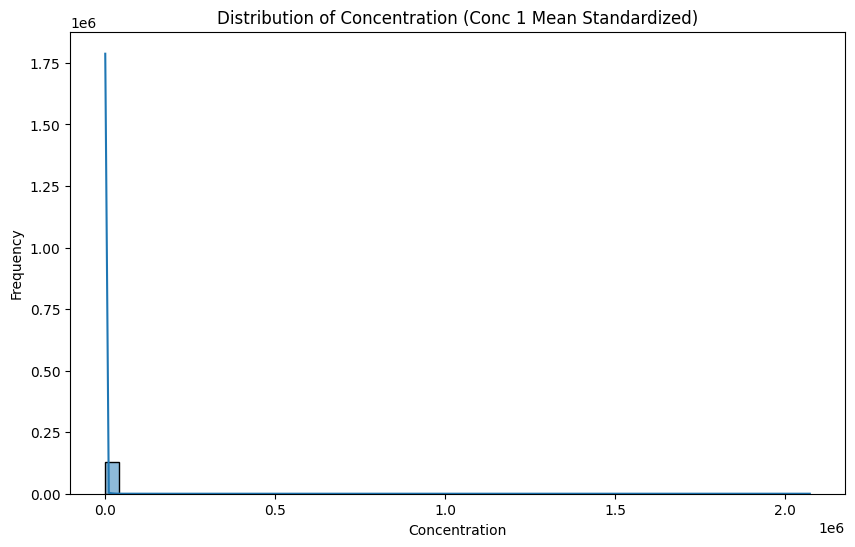

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and 'Conc 1 Mean (Standardized)' is the column with concentration values

# Plotting the distribution of the concentration
plt.figure(figsize=(10, 6))
sns.histplot(df_with_inchikey['Conc 1 Mean (Standardized)'], bins=50, kde=True)
plt.title('Distribution of Concentration (Conc 1 Mean Standardized)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

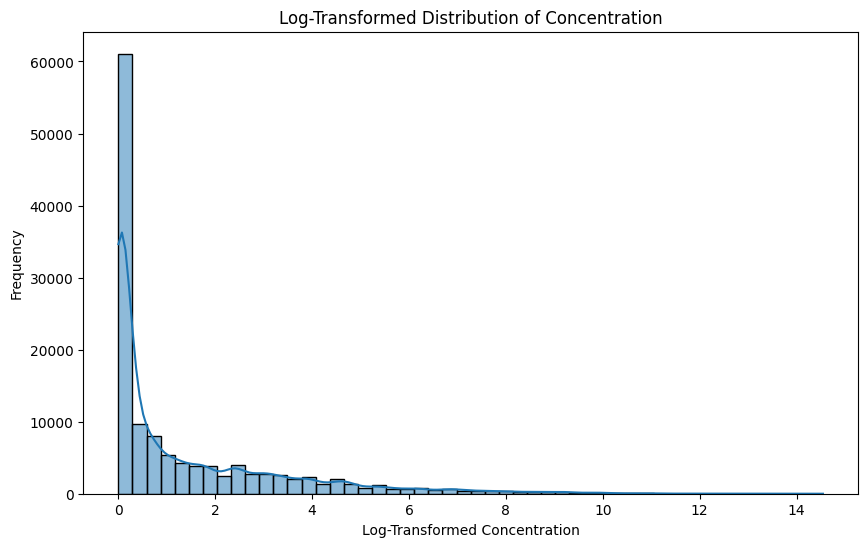

In [ ]:
import numpy as np

df_with_inchikey['Log Conc 1 Mean (Standardized)'] = np.log1p(df_with_inchikey['Conc 1 Mean (Standardized)'])

plt.figure(figsize=(10, 6))
sns.histplot(df_with_inchikey['Log Conc 1 Mean (Standardized)'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Concentration')
plt.xlabel('Log-Transformed Concentration')
plt.ylabel('Frequency')
plt.show()